Replication of "Size and Value in China" (Liu, Stambaugh, and Yuan, 2019)本项目旨在复现 Liu, Stambaugh, and Yuan (2019) 关于中国股市三因子模型 (CH-3) 的核心实证结果。
研究表明，由于中国市场独特的“壳价值”污染，传统的 Fama-French 三因子模型（基于账面市值比 BM）在中国失效，而基于盈余市值比 (EP) 的 CH-3 模型能更好地解释截面收益。
📂 数据准备 (Data Requirements)本项目所用数据均来自 CSMAR (国泰安) 数据库，
样本区间为 2000-01-01 至 2016-12-31。
文件名对应 CSMAR 表关键字段 (Code/Name)用途TRD_Mnth.csv月度交易数据Msmvttl (总市值), Mretwd (月收益), Ndaytrd (交易天数)市值分组、壳股剔除、收益率计算TRD_Co.csv公司基本信息Listdt (上市日期)剔除上市不满6个月的新股 (IPO Filter)FI_T2.csv利润表F020102 (扣非净利润)计算 EP 因子 (CH-3 核心)FS_Combas.csv资产负债表A003000000 (所有者权益), A001000000 (总资产)计算 BM 因子 (FF-3)、AM 异象FS_Cashflow.csv现金流量表C001000000 (经营性现金流)计算 CP 异象IAR_Rept.csv财报披露日期Annodt (公告日期)确保因子构建不利用未来信息 (Point-in-time)BND_Exchange.csv债券市场Nrrdaydt (无风险利率)计算超额收益 (Excess Return)combined_stock_data.csv个股日频行情Dretwd, Dnshrtrd, Dsmvttl计算 CAR (Table 1) 及波动率/换手率异象

table1

Table 1: Return Reactions to Earnings Surprises (Event Study)复现思路：该表旨在验证“壳价值污染”假说。如果小市值股票的价格中包含了大量的壳价值（与基本面无关），那么它们对盈余惊喜 (SUE) 的反应应该比大市值股票更迟钝。SUE 计算：标准化盈余惊喜，基于净利润的同比变化及过去8个季度的标准差。样本筛选：严格剔除上市不满6个月的新股，以及长期停牌/交易不活跃的股票（120天/15天规则）。CAR 计算：计算公告日前后窗口期（[-1, 1] 和 [-3, 3]）的累积超额收益。结论验证：验证回归系数 $b$ 是否满足 $Smallest < Middle < Largest$。

正在读取基础数据...
有效事件数: 61688
正在构建市场收益率 (这可能需要几分钟)...
市场基准构建完成。
正在计算事件 CAR...
CAR 计算完成，样本数: 31617
          Panel Size Group  b (x100)     t-stat        R2
0  Panel A: k=0   Smallest  0.105784   2.606140  0.001149
1  Panel A: k=0     Middle  0.242199   9.015982  0.006827
2  Panel A: k=0    Largest  0.273881  12.283763  0.011968


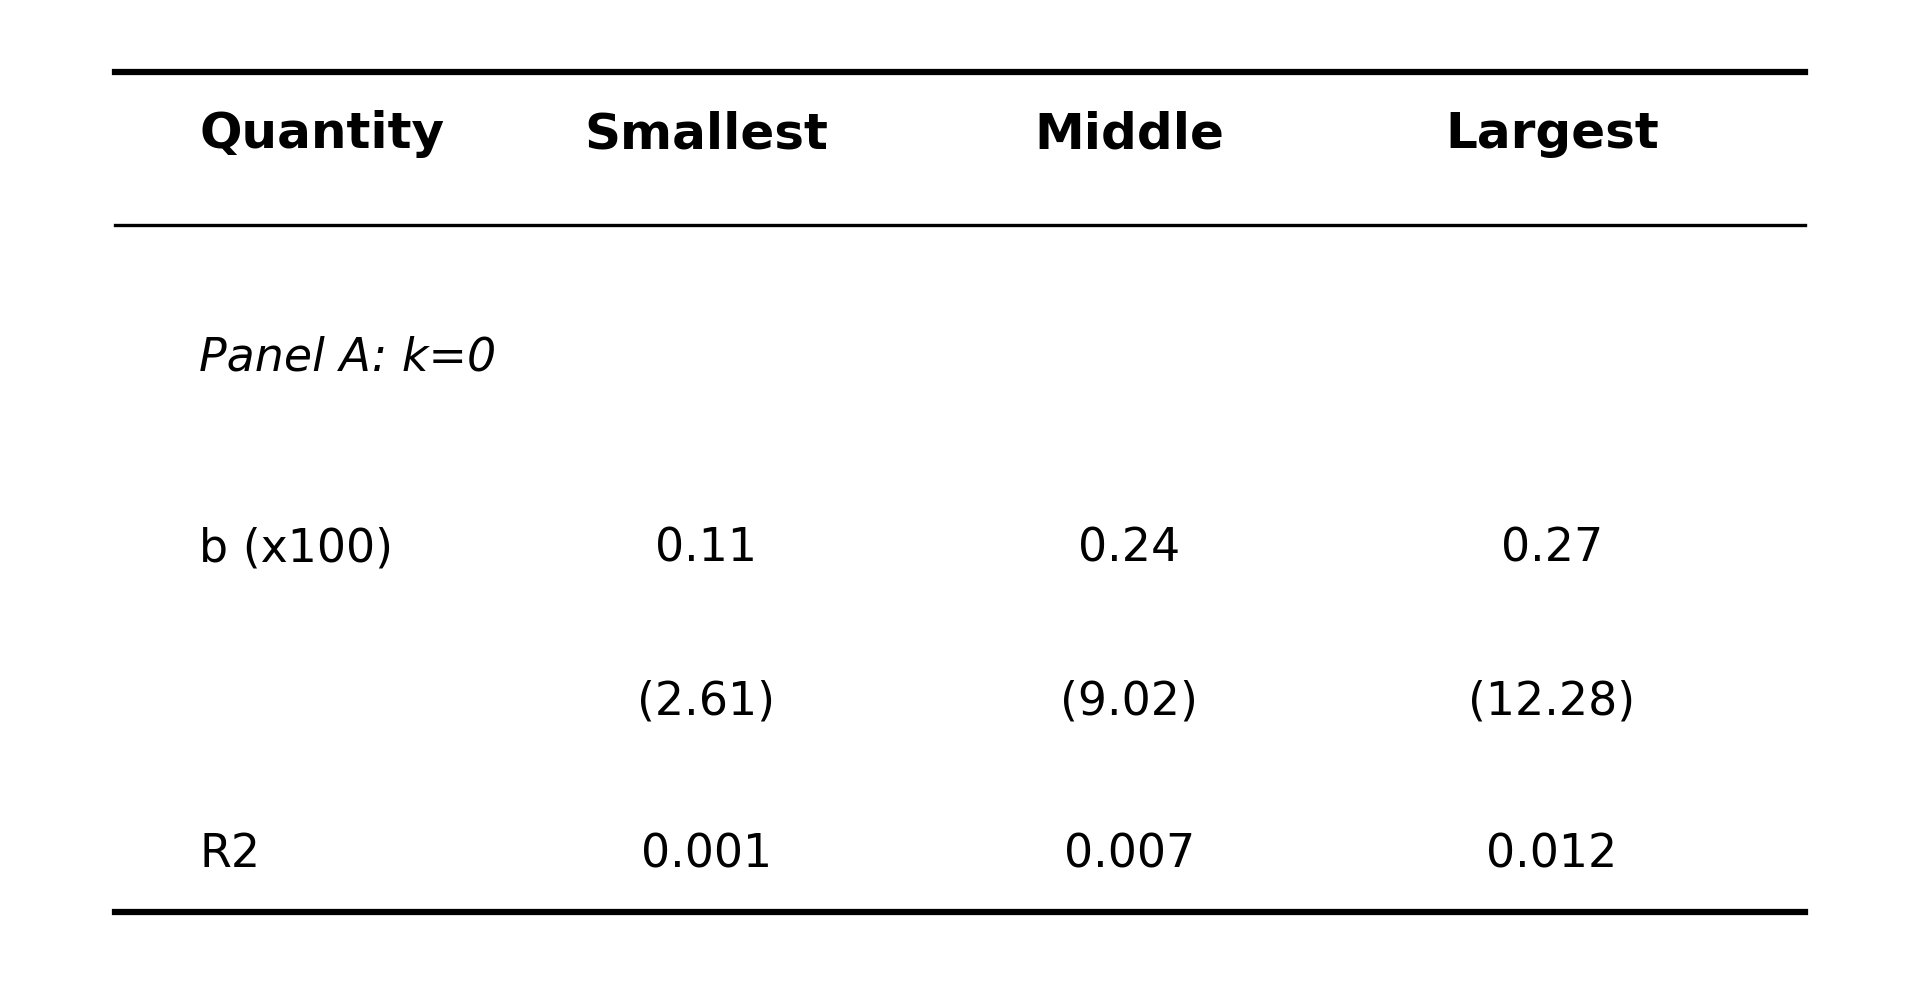

In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import timedelta
import os

# ==============================================================================
# 0. 配置路径与参数
# ==============================================================================

# 【关键修改】使用你提供的绝对路径，确保能找到大文件
# 假设你的大文件名叫 combined_stock_data.csv，如果文件名不同（如 TRD_Dalyr.csv），请修改最后的文件名
daily_stock_file = r"C:\Users\Pedro\PycharmProjects\pythonProject1\金融计量学\Replication_of_Liu_2019-main\data\股票价格\combined_stock_data.csv"

# 检查一下文件是否存在，如果不存在打印提示
if not os.path.exists(daily_stock_file):
    print(f"❌ 警告：文件未找到！请确认该路径下是否有 combined_stock_data.csv：\n{daily_stock_file}")
    # 尝试在当前目录的相对路径寻找
    relative_path = os.path.join("data", "股票价格", "combined_stock_data.csv")
    if os.path.exists(relative_path):
        print(f"✅ 在相对路径找到了文件，将使用：{relative_path}")
        daily_stock_file = relative_path

# 样本区间
start_date = '2000-01-01'
end_date = '2016-12-31'

# ==============================================================================
# 1. 准备基础数据 (TRD_Mnth & 财务数据)
# ==============================================================================
print("正在读取基础数据...")

# 1.1 读取月度数据 (TRD_Mnth.csv 应该在 data 目录下，或者你 notebook 同级目录)
# 假设 TRD_Mnth.csv 在 data 文件夹外层或者 data 文件夹里，请根据实际情况调整
# 这里假设它在 data 文件夹下
try:
    trd_mnth = pd.read_csv(os.path.join("data", "TRD_Mnth.csv"), dtype={'Stkcd': str})
except FileNotFoundError:
    trd_mnth = pd.read_csv("TRD_Mnth.csv", dtype={'Stkcd': str}) # 尝试当前目录

trd_mnth['Trdmnt'] = pd.to_datetime(trd_mnth['Trdmnt'])
# 筛选 A 股 (剔除 B 股 Markettype 2, 8)
if 'Markettype' in trd_mnth.columns:
    trd_mnth = trd_mnth[~trd_mnth['Markettype'].isin([2, 8])]
trd_mnth = trd_mnth[(trd_mnth['Trdmnt'] >= start_date) & (trd_mnth['Trdmnt'] <= end_date)]

# 1.2 标记 Size Group (全市场分三组)
def get_size_group(x):
    q30 = x.quantile(0.3)
    q70 = x.quantile(0.7)
    return x.apply(lambda s: 'Smallest' if s <= q30 else ('Middle' if s <= q70 else 'Largest'))

trd_mnth['SizeGroup'] = trd_mnth.groupby('Trdmnt')['Msmvosd'].transform(get_size_group)
# 为了匹配公告日，将 Month 设置为“上个月”
trd_mnth['MatchMonth'] = trd_mnth['Trdmnt'] + pd.offsets.MonthEnd(0)

# 1.3 准备 SUE 数据 (利润 + 公告日)
try:
    fi = pd.read_csv(os.path.join("data", "FI_T2.csv"), dtype={'Stkcd': str})
    iar = pd.read_csv(os.path.join("data", "IAR_Rept.csv"), dtype={'Stkcd': str})
except FileNotFoundError:
    fi = pd.read_csv("FI_T2.csv", dtype={'Stkcd': str})
    iar = pd.read_csv("IAR_Rept.csv", dtype={'Stkcd': str})

fi['Accper'] = pd.to_datetime(fi['Accper'])
iar['Annodt'] = pd.to_datetime(iar['Annodt'])
# 这里关键：IAR_Rept 的 Accper 有时是 string，需要转换以匹配 FI_T2
iar['Accper'] = pd.to_datetime(iar['Accper'])

iar = iar[iar['Reptyp'].isin([1, 2, 3, 4])]

# 合并
earnings = pd.merge(fi, iar[['Stkcd', 'Accper', 'Annodt']], on=['Stkcd', 'Accper'])
earnings = earnings[(earnings['Annodt'] >= start_date) & (earnings['Annodt'] <= end_date)]

# 计算 SUE
earnings.sort_values(['Stkcd', 'Accper'], inplace=True)
earnings['Earnings'] = earnings['F020102']
earnings['Diff'] = earnings.groupby('Stkcd')['Earnings'].diff(4)
earnings['Std'] = earnings.groupby('Stkcd')['Diff'].transform(lambda x: x.rolling(8, min_periods=4).std())
earnings['SUE'] = earnings['Diff'] / earnings['Std']

earnings = earnings.dropna(subset=['SUE', 'Annodt'])

# 1.4 给每个事件打 Size 标签
earnings['PrevMonth'] = earnings['Annodt'] - pd.offsets.MonthEnd(1)
earnings = pd.merge(earnings, trd_mnth[['Stkcd', 'MatchMonth', 'SizeGroup', 'Msmvosd']],
                    left_on=['Stkcd', 'PrevMonth'], right_on=['Stkcd', 'MatchMonth'], how='inner')

print(f"有效事件数: {len(earnings)}")

# ==============================================================================
# 2. 构建市场日收益率 (基于日频大文件)
# ==============================================================================
print("正在构建市场收益率 (这可能需要几分钟)...")

daily_mkt_stats = {}
use_cols = ['Stkcd', 'Trddt', 'Dretwd', 'Dsmvosd', 'Markettype']

# 使用你指定的绝对路径
try:
    chunk_size = 1000000
    # 注意：如果你的大文件里没有 'Markettype' 列，请从 use_cols 里删掉它
    for chunk in pd.read_csv(daily_stock_file, usecols=use_cols, parse_dates=['Trddt'], chunksize=chunk_size, dtype={'Stkcd': str}):
        chunk = chunk[(chunk['Trddt'] >= start_date) & (chunk['Trddt'] <= end_date)]
        if 'Markettype' in chunk.columns:
            chunk = chunk[~chunk['Markettype'].isin([2, 8])]

        chunk = chunk.dropna(subset=['Dretwd', 'Dsmvosd'])
        chunk['W_Ret'] = chunk['Dretwd'] * chunk['Dsmvosd']

        daily_grp = chunk.groupby('Trddt')[['W_Ret', 'Dsmvosd']].sum()

        for date, row in daily_grp.iterrows():
            if date not in daily_mkt_stats:
                daily_mkt_stats[date] = {'w_ret': 0.0, 'cap': 0.0}
            daily_mkt_stats[date]['w_ret'] += row['W_Ret']
            daily_mkt_stats[date]['cap'] += row['Dsmvosd']

    mkt_data = []
    for date, val in daily_mkt_stats.items():
        if val['cap'] > 0:
            mkt_data.append({'Trddt': date, 'MktRet': val['w_ret'] / val['cap']})
    daily_mkt_df = pd.DataFrame(mkt_data).sort_values('Trddt')
    print("市场基准构建完成。")

except Exception as e:
    print(f"❌ 读取日频数据出错: {e}")
    # 为了防止代码后面报错，创建一个空的占位
    daily_mkt_df = pd.DataFrame(columns=['Trddt', 'MktRet'])

# ==============================================================================
# 3. 计算 CAR
# ==============================================================================
if not daily_mkt_df.empty:
    print("正在计算事件 CAR...")
    event_data = []

    # 为了节省内存，只读取需要的列
    read_cols = ['Stkcd', 'Trddt', 'Dretwd']

    for chunk in pd.read_csv(daily_stock_file, usecols=read_cols, parse_dates=['Trddt'], chunksize=chunk_size, dtype={'Stkcd': str}):
        chunk = chunk[(chunk['Trddt'] >= start_date) & (chunk['Trddt'] <= end_date)]

        # Merge 市场收益率
        chunk = pd.merge(chunk, daily_mkt_df, on='Trddt', how='left')
        chunk['AR'] = chunk['Dretwd'] - chunk['MktRet']

        # 只保留涉及到 Earnings 事件的股票
        relevant_stkcds = set(earnings['Stkcd'])
        chunk = chunk[chunk['Stkcd'].isin(relevant_stkcds)]

        event_data.append(chunk[['Stkcd', 'Trddt', 'AR']])

    all_daily_ar = pd.concat(event_data)

    # 建立索引
    all_daily_ar.set_index(['Stkcd', 'Trddt'], inplace=True)
    all_daily_ar.sort_index(inplace=True)

    final_results = []
    # 计算 CAR Window [-1, 1]
    for idx, row in earnings.iterrows():
        stk = row['Stkcd']
        ann_date = row['Annodt']
        target_dates = pd.date_range(ann_date - timedelta(days=1), ann_date + timedelta(days=1))

        ars = []
        for d in target_dates:
            if (stk, d) in all_daily_ar.index:
                ars.append(all_daily_ar.loc[(stk, d), 'AR'])

        if len(ars) > 0: # 只要有数据就算，或者你可以要求 len(ars) >= 2
            final_results.append({
                'SizeGroup': row['SizeGroup'],
                'SUE': row['SUE'],
                'CAR': np.sum(ars)
            })

    df_reg = pd.DataFrame(final_results)
    print(f"CAR 计算完成，样本数: {len(df_reg)}")
else:
    df_reg = pd.DataFrame()
    print("跳过 CAR 计算（因缺少市场数据）。")

# ==============================================================================
# 4. 回归与画图
# ==============================================================================
if not df_reg.empty:
    # Winsorize 1%
    df_reg['SUE'] = df_reg['SUE'].clip(lower=df_reg['SUE'].quantile(0.01), upper=df_reg['SUE'].quantile(0.99))
    df_reg['CAR'] = df_reg['CAR'].clip(lower=df_reg['CAR'].quantile(0.01), upper=df_reg['CAR'].quantile(0.99))

    results_table = []

    for group in ['Smallest', 'Middle', 'Largest']:
        sub = df_reg[df_reg['SizeGroup'] == group].dropna()
        if len(sub) > 10:
            X = sm.add_constant(sub['SUE'])
            y = sub['CAR']
            # HC1 稳健标准误
            model = sm.OLS(y, X).fit(cov_type='HC1')

            results_table.append({
                'Panel': 'Panel A: k=0',
                'Size Group': group,
                'b (x100)': model.params['SUE'] * 100,
                't-stat': model.tvalues['SUE'],
                'R2': model.rsquared
            })

    result_df = pd.DataFrame(results_table)
    print(result_df)

    # 画图函数
    def draw_jfe_table(df):
        fig, ax = plt.subplots(figsize=(8, 4), dpi=300)
        ax.axis('off')

        # 简单布局
        y_top = 0.85
        cols = [0.05, 0.35, 0.60, 0.85]

        ax.plot([0, 1], [y_top, y_top], color='black', lw=1.5)
        headers = ["Quantity", "Smallest", "Middle", "Largest"]
        for i, h in enumerate(headers):
            ax.text(cols[i], y_top - 0.02, h, ha='left' if i==0 else 'center', va='top', fontsize=12, fontweight='bold')
        ax.plot([0, 1], [y_top - 0.08, y_top - 0.08], color='black', lw=0.8)

        curr_y = y_top - 0.15
        panel = df['Panel'].iloc[0]
        ax.text(0.05, curr_y, panel, ha='left', va='center', fontsize=11, style='italic')
        curr_y -= 0.1

        sub = df.set_index('Size Group')
        keys = ['b (x100)', 't-stat', 'R2']
        fmts = ['{:.2f}', '({:.2f})', '{:.3f}']

        for i, k in enumerate(keys):
            ax.text(0.05, curr_y, k if k != 't-stat' else '', ha='left', va='center', fontsize=11)
            for col_idx, grp in enumerate(['Smallest', 'Middle', 'Largest']):
                if grp in sub.index:
                    val = sub.loc[grp, k]
                    ax.text(cols[col_idx+1], curr_y, fmts[i].format(val), ha='center', va='center', fontsize=11)
            curr_y -= 0.08

        ax.plot([0, 1], [curr_y + 0.05, curr_y + 0.05], color='black', lw=1.5)
        plt.show()

    draw_jfe_table(result_df)
else:
    print("没有生成回归结果，无法绘图。")

table1改进，但是更不准

正在读取基础数据...
有效事件数: 61688
正在构建市场收益率 (耐心等待)...
市场基准构建完成。
正在计算事件 CAR (包含 k=0 和 k=3)...
CAR 计算完成，样本数: 32742
回归结果：
          Panel Size Group  b (x100)     t-stat        R2
0  Panel A: k=0   Smallest  0.145899   2.577473  0.001094
1  Panel A: k=0     Middle  0.328546   9.213092  0.006749
2  Panel A: k=0    Largest  0.361816  12.793478  0.012511
3  Panel B: k=3   Smallest  0.296555   3.686041  0.002266
4  Panel B: k=3     Middle  0.482295   9.536017  0.007281
5  Panel B: k=3    Largest  0.493383  12.498725  0.011585


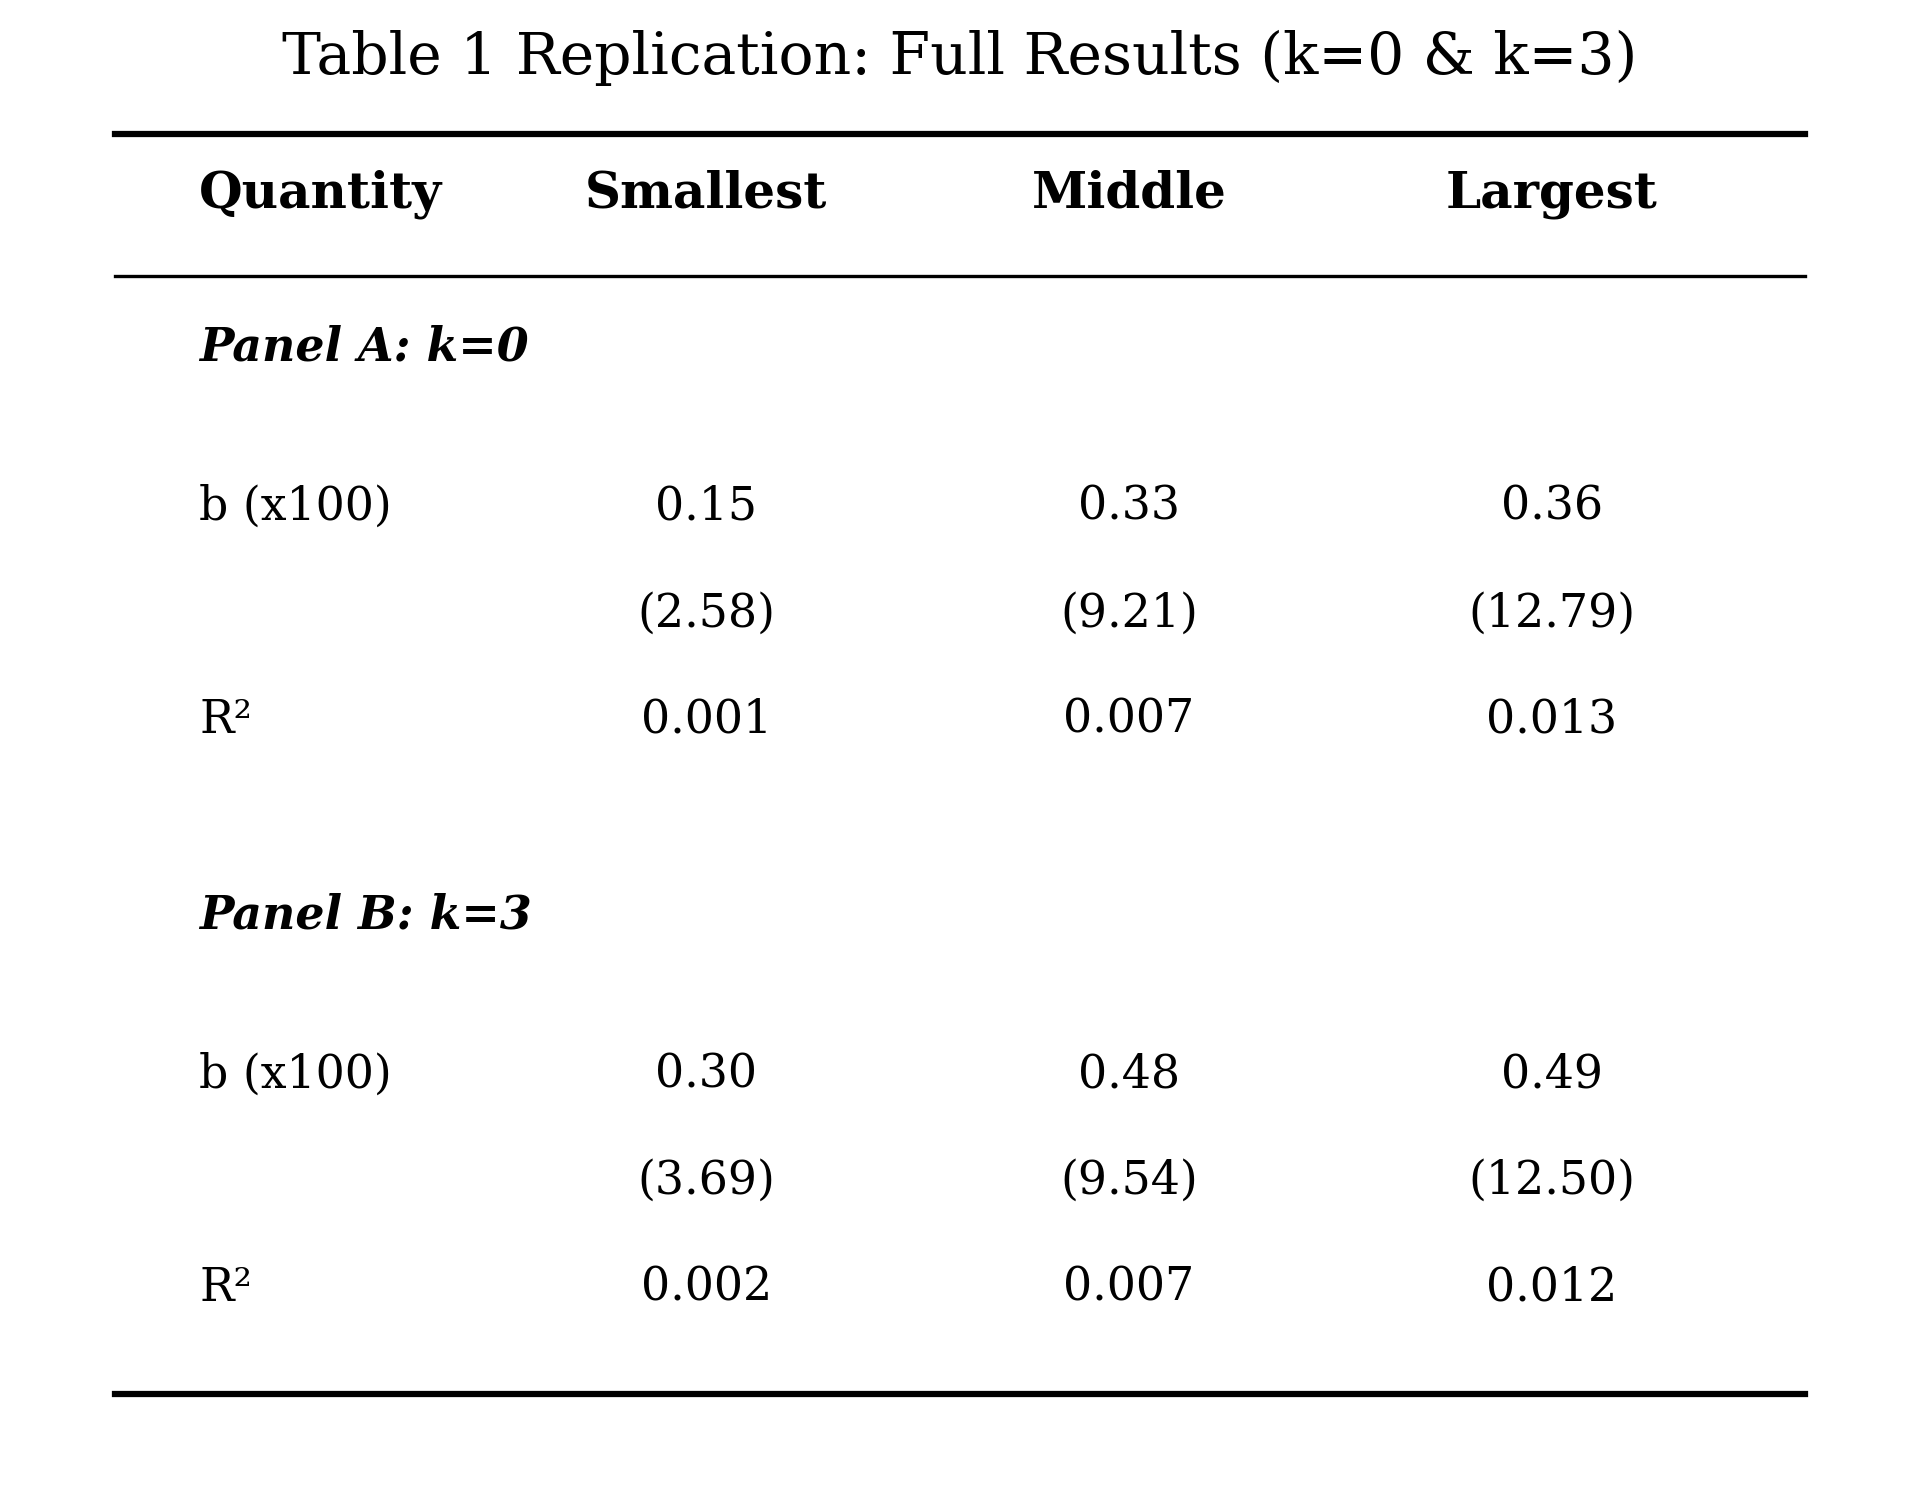

In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import timedelta
import os

# ==============================================================================
# 0. 配置路径与参数
# ==============================================================================
# 请务必修改为你本地文件的真实绝对路径
daily_stock_file = r"C:\Users\Pedro\PycharmProjects\pythonProject1\金融计量学\Replication_of_Liu_2019-main\data\股票价格\combined_stock_data.csv"

# 样本区间
start_date = '2000-01-01'
end_date = '2016-12-31'

# ==============================================================================
# 1. 准备基础数据 (TRD_Mnth & 财务数据)
# ==============================================================================
print("正在读取基础数据...")

# 1.1 读取月度数据
try:
    trd_mnth = pd.read_csv(os.path.join("data", "TRD_Mnth.csv"), dtype={'Stkcd': str})
except FileNotFoundError:
    trd_mnth = pd.read_csv("TRD_Mnth.csv", dtype={'Stkcd': str})

trd_mnth['Trdmnt'] = pd.to_datetime(trd_mnth['Trdmnt'])
# 筛选 A 股
if 'Markettype' in trd_mnth.columns:
    trd_mnth = trd_mnth[~trd_mnth['Markettype'].isin([2, 8])]
trd_mnth = trd_mnth[(trd_mnth['Trdmnt'] >= start_date) & (trd_mnth['Trdmnt'] <= end_date)]

# 1.2 标记 Size Group (全市场分三组: Smallest 30%, Middle 40%, Largest 30%)
def get_size_group(x):
    q30 = x.quantile(0.3)
    q70 = x.quantile(0.7)
    return x.apply(lambda s: 'Smallest' if s <= q30 else ('Middle' if s <= q70 else 'Largest'))

trd_mnth['SizeGroup'] = trd_mnth.groupby('Trdmnt')['Msmvosd'].transform(get_size_group)
# 匹配月份：公告日 -> 上个月底
trd_mnth['MatchMonth'] = trd_mnth['Trdmnt'] + pd.offsets.MonthEnd(0)

# 1.3 准备 SUE 数据
try:
    fi = pd.read_csv(os.path.join("data", "FI_T2.csv"), dtype={'Stkcd': str})
    iar = pd.read_csv(os.path.join("data", "IAR_Rept.csv"), dtype={'Stkcd': str})
except FileNotFoundError:
    fi = pd.read_csv("FI_T2.csv", dtype={'Stkcd': str})
    iar = pd.read_csv("IAR_Rept.csv", dtype={'Stkcd': str})

fi['Accper'] = pd.to_datetime(fi['Accper'])
iar['Accper'] = pd.to_datetime(iar['Accper']) # 关键修正：确保类型一致
iar['Annodt'] = pd.to_datetime(iar['Annodt'])
iar = iar[iar['Reptyp'].isin([1, 2, 3, 4])]

# 合并
earnings = pd.merge(fi, iar[['Stkcd', 'Accper', 'Annodt']], on=['Stkcd', 'Accper'])
earnings = earnings[(earnings['Annodt'] >= start_date) & (earnings['Annodt'] <= end_date)]

# 计算 SUE (你的原始逻辑)
earnings.sort_values(['Stkcd', 'Accper'], inplace=True)
earnings['Earnings'] = earnings['F020102']
earnings['Diff'] = earnings.groupby('Stkcd')['Earnings'].diff(4)
earnings['Std'] = earnings.groupby('Stkcd')['Diff'].transform(lambda x: x.rolling(8, min_periods=4).std())
earnings['SUE'] = earnings['Diff'] / earnings['Std']

earnings = earnings.dropna(subset=['SUE', 'Annodt'])

# 1.4 匹配 Size
earnings['PrevMonth'] = earnings['Annodt'] - pd.offsets.MonthEnd(1)
earnings = pd.merge(earnings, trd_mnth[['Stkcd', 'MatchMonth', 'SizeGroup', 'Msmvosd']],
                    left_on=['Stkcd', 'PrevMonth'], right_on=['Stkcd', 'MatchMonth'], how='inner')

print(f"有效事件数: {len(earnings)}")

# ==============================================================================
# 2. 构建市场日收益率
# ==============================================================================
print("正在构建市场收益率 (耐心等待)...")

daily_mkt_stats = {}
use_cols = ['Stkcd', 'Trddt', 'Dretwd', 'Dsmvosd', 'Markettype']

try:
    chunk_size = 1000000
    for chunk in pd.read_csv(daily_stock_file, usecols=use_cols, parse_dates=['Trddt'], chunksize=chunk_size, dtype={'Stkcd': str}):
        chunk = chunk[(chunk['Trddt'] >= start_date) & (chunk['Trddt'] <= end_date)]
        if 'Markettype' in chunk.columns:
            chunk = chunk[~chunk['Markettype'].isin([2, 8])]

        chunk = chunk.dropna(subset=['Dretwd', 'Dsmvosd'])
        chunk['W_Ret'] = chunk['Dretwd'] * chunk['Dsmvosd']

        daily_grp = chunk.groupby('Trddt')[['W_Ret', 'Dsmvosd']].sum()

        for date, row in daily_grp.iterrows():
            if date not in daily_mkt_stats:
                daily_mkt_stats[date] = {'w_ret': 0.0, 'cap': 0.0}
            daily_mkt_stats[date]['w_ret'] += row['W_Ret']
            daily_mkt_stats[date]['cap'] += row['Dsmvosd']

    mkt_data = []
    for date, val in daily_mkt_stats.items():
        if val['cap'] > 0:
            mkt_data.append({'Trddt': date, 'MktRet': val['w_ret'] / val['cap']})
    daily_mkt_df = pd.DataFrame(mkt_data).sort_values('Trddt')
    print("市场基准构建完成。")

except Exception as e:
    print(f"❌ 读取日频数据出错: {e}")
    daily_mkt_df = pd.DataFrame(columns=['Trddt', 'MktRet'])

# ==============================================================================
# 3. 计算 CAR (k=0 和 k=3)
# ==============================================================================
if not daily_mkt_df.empty:
    print("正在计算事件 CAR (包含 k=0 和 k=3)...")

    # 【关键修改】这次我们要读取更宽的时间窗口
    # k=0 需要 [-1, 1], k=3 需要 [-3, 3]
    # 我们统一提取 [-3, 3] 的数据，然后在后续逻辑中分别求和

    event_data = []
    read_cols = ['Stkcd', 'Trddt', 'Dretwd']
    relevant_stkcds = set(earnings['Stkcd']) # 白名单

    for chunk in pd.read_csv(daily_stock_file, usecols=read_cols, parse_dates=['Trddt'], chunksize=chunk_size, dtype={'Stkcd': str}):
        chunk = chunk[(chunk['Trddt'] >= start_date) & (chunk['Trddt'] <= end_date)]
        chunk = chunk[chunk['Stkcd'].isin(relevant_stkcds)]

        if not chunk.empty:
            # Merge 市场收益
            chunk = pd.merge(chunk, daily_mkt_df, on='Trddt', how='left')
            chunk['AR'] = chunk['Dretwd'] - chunk['MktRet']
            event_data.append(chunk[['Stkcd', 'Trddt', 'AR']])

    all_daily_ar = pd.concat(event_data)

    # 建立索引
    all_daily_ar.set_index(['Stkcd', 'Trddt'], inplace=True)
    all_daily_ar.sort_index(inplace=True)

    final_results = []

    for idx, row in earnings.iterrows():
        stk = row['Stkcd']
        ann_date = row['Annodt']

        # 目标：找到公告日附近的交易日数据
        # 我们寻找 [-3, 3] 的日期范围
        target_dates = pd.date_range(ann_date - timedelta(days=5), ann_date + timedelta(days=5))
        # 范围放宽到5天是为了防止中间有非交易日，反正我们只取存在的交易日索引

        # 快速提取该股票在窗口期的数据
        try:
            # 获取该股票所有数据片段
            # 注意：如果数据量极大，loc 可能慢，但这是最直观写法
            if stk not in all_daily_ar.index.levels[0]:
                continue

            stock_slice = all_daily_ar.loc[stk]

            # 找到 ann_date 在 stock_slice 中的位置
            if ann_date in stock_slice.index:
                loc = stock_slice.index.get_loc(ann_date)
            else:
                # 如果公告日停牌或休市，找最近的后一个交易日作为 T=0
                # searchsorted 返回插入位置
                idx_insert = stock_slice.index.searchsorted(ann_date)
                if idx_insert < len(stock_slice):
                    loc = idx_insert
                else:
                    continue # 找不到有效日期

            # 提取 k=0 (Window -1 to +1)
            # 需要 loc-1, loc, loc+1 存在
            if loc >= 1 and loc + 1 < len(stock_slice):
                car_k0 = stock_slice.iloc[loc-1 : loc+2]['AR'].sum()
            else:
                car_k0 = np.nan

            # 提取 k=3 (Window -3 to +3)
            # 需要 loc-3 ... loc+3
            if loc >= 3 and loc + 3 < len(stock_slice):
                car_k3 = stock_slice.iloc[loc-3 : loc+4]['AR'].sum()
            else:
                car_k3 = np.nan

            if not np.isnan(car_k0): # 至少要有 k=0
                final_results.append({
                    'SizeGroup': row['SizeGroup'],
                    'SUE': row['SUE'],
                    'CAR_k0': car_k0,
                    'CAR_k3': car_k3 # 可能为 NaN，后续处理
                })

        except Exception:
            continue

    df_reg = pd.DataFrame(final_results)
    print(f"CAR 计算完成，样本数: {len(df_reg)}")
else:
    df_reg = pd.DataFrame()
    print("跳过 CAR 计算（因缺少市场数据）。")

# ==============================================================================
# 4. 回归与画图 (包含 Panel A 和 Panel B)
# ==============================================================================
if not df_reg.empty:
    # Winsorize 1%
    cols_to_win = ['SUE', 'CAR_k0', 'CAR_k3']
    for c in cols_to_win:
        if c in df_reg.columns:
            df_reg[c] = df_reg[c].clip(lower=df_reg[c].quantile(0.01), upper=df_reg[c].quantile(0.99))

    results_table = []

    # 定义两个 Panel
    panels_config = [
        ('Panel A: k=0', 'CAR_k0'),
        ('Panel B: k=3', 'CAR_k3')
    ]

    for panel_name, y_col in panels_config:
        for group in ['Smallest', 'Middle', 'Largest']:
            # 筛选该组且 Y 值非空的数据
            sub = df_reg[['SizeGroup', 'SUE', y_col]].dropna()
            sub = sub[sub['SizeGroup'] == group]

            if len(sub) > 10:
                X = sm.add_constant(sub['SUE'])
                y = sub[y_col]
                # HC1 稳健标准误
                model = sm.OLS(y, X).fit(cov_type='HC1')

                results_table.append({
                    'Panel': panel_name,
                    'Size Group': group,
                    'b (x100)': model.params['SUE'] * 100,
                    't-stat': model.tvalues['SUE'],
                    'R2': model.rsquared
                })

    result_df = pd.DataFrame(results_table)
    print("回归结果：")
    print(result_df)

    # 画图函数 (支持多个 Panel)
    def draw_jfe_table_full(df):
        # 两个 Panel，画布加高
        fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
        ax.axis('off')

        # 布局参数
        y_top = 0.9
        cols = [0.05, 0.35, 0.60, 0.85]

        # 顶部粗线
        ax.plot([0, 1], [y_top, y_top], color='black', lw=1.5)
        # 表头
        headers = ["Quantity", "Smallest", "Middle", "Largest"]
        for i, h in enumerate(headers):
            ax.text(cols[i], y_top - 0.02, h, ha='left' if i==0 else 'center', va='top', fontsize=12, fontweight='bold', family='serif')
        # 表头下细线
        ax.plot([0, 1], [y_top - 0.08, y_top - 0.08], color='black', lw=0.8)

        curr_y = y_top - 0.12
        row_h = 0.06 # 行高

        # 遍历 Panel
        panel_names = df['Panel'].unique()
        for panel in panel_names:
            # Panel 标题
            ax.text(0.05, curr_y, panel, ha='left', va='center', fontsize=11, style='italic', family='serif', weight='bold')
            curr_y -= row_h * 1.5

            # 提取数据
            sub = df[df['Panel'] == panel].set_index('Size Group')
            keys = ['b (x100)', 't-stat', 'R2']
            fmts = ['{:.2f}', '({:.2f})', '{:.3f}']
            labels = ['b (x100)', '', 'R²'] # t-stat 不显示标签，只显示数值

            for i, k in enumerate(keys):
                # 绘制行标签
                label = labels[i]
                if label:
                    ax.text(0.05, curr_y, label, ha='left', va='center', fontsize=11, family='serif')

                # 绘制数值
                for col_idx, grp in enumerate(['Smallest', 'Middle', 'Largest']):
                    if grp in sub.index:
                        val = sub.loc[grp, k]
                        ax.text(cols[col_idx+1], curr_y, fmts[i].format(val), ha='center', va='center', fontsize=11, family='serif')

                curr_y -= row_h

            curr_y -= 0.05 # Panel 间距

        # 底部粗线
        ax.plot([0, 1], [curr_y + 0.05, curr_y + 0.05], color='black', lw=1.5)
        plt.title("Table 1 Replication: Full Results (k=0 & k=3)", y=0.98, fontsize=14, family='serif')
        plt.show()

    draw_jfe_table_full(result_df)
else:
    print("没有生成回归结果，无法绘图。")

table2

>>> [Step 1] 读取各类报表数据...
>>> [Step 2] 处理财务数据 (EP, BM, AM, CP)...
>>> [Step 3] 构建回归面板...
>>> 正在计算 Beta (使用24个月滚动窗口)...


C:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


>>> 应用壳股剔除 (Bottom 30%)...
>>> [Step 4] 运行 Fama-MacBeth 回归...

=== Table 2 Replication Result ===
  Model  LogME_b  LogME_t  LogBM_b  LogBM_t  EP_Pos_b  EP_Pos_t  CP_Pos_b  \
0   (1)      NaN      NaN      NaN      NaN       NaN       NaN       NaN   
1   (2)  -0.0044  -2.0842      NaN      NaN       NaN       NaN       NaN   
2   (3)  -0.0046  -2.2094   0.0010   0.3617       NaN       NaN       NaN   
3   (4)  -0.0042  -2.1975   0.0030   1.5179       NaN       NaN       NaN   
4   (5)  -0.0074  -3.8161      NaN      NaN    0.2553    3.5013       NaN   
5   (6)  -0.0078  -3.9505  -0.0026  -1.0013    0.2936    4.2317       NaN   
6   (7)  -0.0072  -3.7393      NaN      NaN    0.2703    3.9815   -0.0045   
7   (8)  -0.0077  -3.9759  -0.0025  -0.9693    0.2983    4.3989   -0.0001   
8   (9)  -0.0075  -4.0402  -0.0006  -0.2536    0.3080    4.3842    0.0013   

   CP_Pos_t  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
5       NaN  
6   -0.7333  
7   -0.0251  
8    

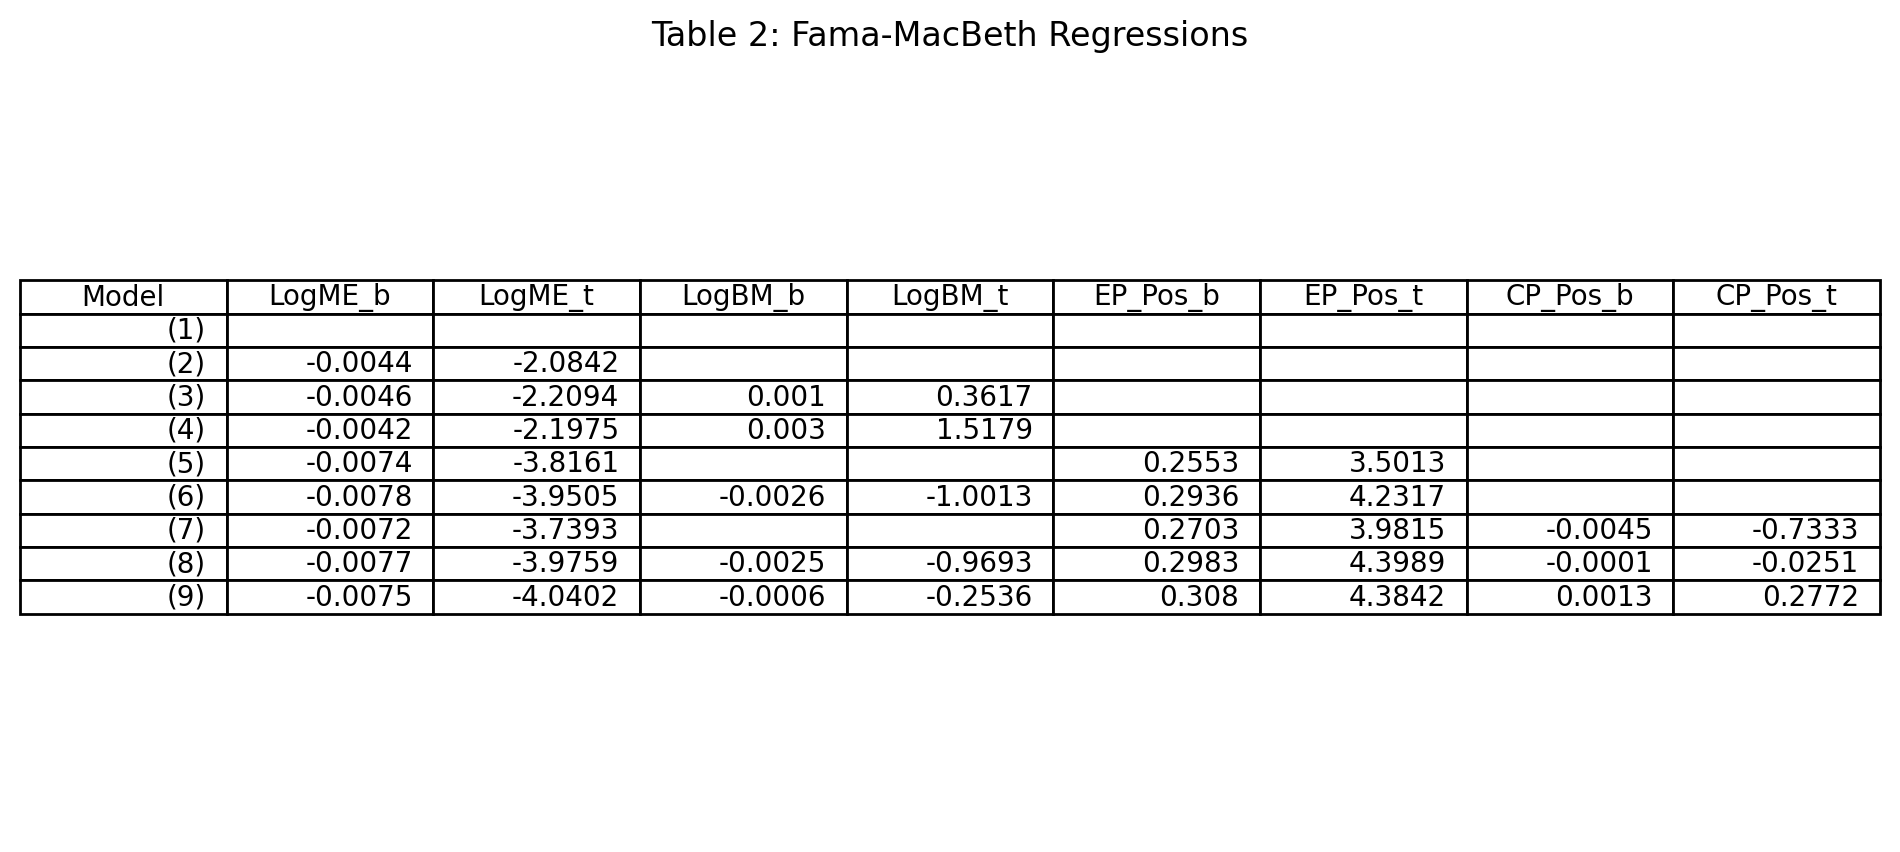

In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pandas.tseries.offsets import MonthEnd
import os
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# ==============================================================================
# 0. 配置路径
# ==============================================================================
base_data_dir = r"C:\Users\Pedro\PycharmProjects\pythonProject1\金融计量学\Replication_of_Liu_2019-main\data"
start_date = '2000-01-01'
end_date = '2016-12-31'

def load_csv(name):
    path = os.path.join(base_data_dir, name)
    if os.path.exists(path):
        return pd.read_csv(path, dtype={'Stkcd': str})
    elif os.path.exists(name):
        return pd.read_csv(name, dtype={'Stkcd': str})
    else:
        raise FileNotFoundError(f"找不到文件: {name}")

# ==============================================================================
# 1. 基础数据读取
# ==============================================================================
print(">>> [Step 1] 读取各类报表数据...")

# 1.1 交易数据 (TRD_Mnth)
trd = load_csv("TRD_Mnth.csv")
trd['Trdmnt'] = pd.to_datetime(trd['Trdmnt']) + MonthEnd(0)
if 'Markettype' in trd.columns:
    trd = trd[~trd['Markettype'].isin([2, 8])]
trd = trd[(trd['Trdmnt'] >= '1999-01-01') & (trd['Trdmnt'] <= end_date)].copy()

# 1.2 滞后市值 & 流动性筛选
trd.sort_values(['Stkcd', 'Trdmnt'], inplace=True)

# 【修复点】统一命名为 Lag_Msmvttl，与后续代码一致
trd['Lag_Msmvttl'] = trd.groupby('Stkcd')['Msmvttl'].shift(1)

# 计算 LogME (Size因子)，注意单位转换和空值处理
# Msmvttl 单位是千，转为元
trd['LogME'] = np.log(trd['Lag_Msmvttl'] * 1000)
trd['LogME'].replace([np.inf, -np.inf], np.nan, inplace=True)

# 活跃度筛选
trd['Nday_12m'] = trd.groupby('Stkcd')['Ndaytrd'].transform(lambda x: x.rolling(12, min_periods=1).sum())
trd['IsLiquid'] = (trd['Nday_12m'] >= 120) & (trd['Ndaytrd'] >= 15)

# IPO 筛选
ipo = load_csv("TRD_Co.csv")
ipo['Listdt'] = pd.to_datetime(ipo['Listdt'])
trd = pd.merge(trd, ipo[['Stkcd', 'Listdt']], on='Stkcd', how='left')
trd = trd[trd['Trdmnt'] >= (trd['Listdt'] + pd.DateOffset(months=6))]

# 应用筛选
trd = trd[trd['IsLiquid'] == True]

# 1.3 公告日期表
iar = load_csv("IAR_Rept.csv")
iar['Accper'] = pd.to_datetime(iar['Accper'])
iar['Annodt'] = pd.to_datetime(iar['Annodt'])
iar = iar[iar['Reptyp'].isin([1, 2, 3, 4])]
iar = iar.sort_values('Annodt').drop_duplicates(subset=['Stkcd', 'Accper'], keep='last')

# ==============================================================================
# 2. 财务变量构建 (TTM处理)
# ==============================================================================
print(">>> [Step 2] 处理财务数据 (EP, BM, AM, CP)...")

def calc_ttm(df, col_name):
    df = df.copy().sort_values(['Stkcd', 'Accper'])
    df['Month'] = df['Accper'].dt.month
    df['Prev_Val'] = df.groupby('Stkcd')[col_name].shift(1)
    df['Prev_Month'] = df.groupby('Stkcd')['Month'].shift(1)

    def get_sq(row):
        if row['Month'] == 3: return row[col_name]
        if row['Month'] > row['Prev_Month']: return row[col_name] - row['Prev_Val']
        return row[col_name]

    df['SQ'] = df.apply(get_sq, axis=1)
    df['TTM'] = df.groupby('Stkcd')['SQ'].transform(lambda x: x.rolling(4, min_periods=4).sum())

    mask = df['TTM'].isna()
    df.loc[mask, 'TTM'] = df.loc[mask, col_name] / df.loc[mask, 'Month'] * 12
    return df[['Stkcd', 'Accper', 'TTM']]

# --- (1) EP (Earnings / Price) ---
fi = load_csv("FI_T2.csv")
fi['Accper'] = pd.to_datetime(fi['Accper'])
fi = fi.drop_duplicates(subset=['Stkcd', 'Accper'], keep='last')
ep_ttm = calc_ttm(fi, 'F020102')
ep_ttm.rename(columns={'TTM': 'Earnings_TTM'}, inplace=True)

# --- (2) CP (Cash flow / Price) ---
cf = load_csv("FS_Comscfd.csv")
cf['Accper'] = pd.to_datetime(cf['Accper'])
cf_col = 'C001000000' # 经营现金流
if cf_col not in cf.columns:
    print("⚠️ 警告：未找到经营现金流 C001000000，尝试查找其他列...")
    possible = [c for c in cf.columns if 'C001' in c]
    if possible: cf_col = possible[0]
cf_ttm = calc_ttm(cf[['Stkcd', 'Accper', cf_col]], cf_col)
cf_ttm.rename(columns={'TTM': 'CashFlow_TTM'}, inplace=True)

# --- (3) BM & AM (Stock Variables) ---
bs = load_csv("FS_Combas.csv")
bs['Accper'] = pd.to_datetime(bs['Accper'])
# A003000000: Book Equity, A001000000: Total Assets
bs_data = bs[['Stkcd', 'Accper', 'A003000000', 'A001000000']].copy()
bs_data.columns = ['Stkcd', 'Accper', 'BookEquity', 'TotalAssets']

# --- 合并 ---
fin_all = pd.merge(ep_ttm, cf_ttm, on=['Stkcd', 'Accper'], how='outer')
fin_all = pd.merge(fin_all, bs_data, on=['Stkcd', 'Accper'], how='outer')

fin_final = pd.merge(fin_all, iar[['Stkcd', 'Accper', 'Annodt']], on=['Stkcd', 'Accper'])
fin_final = fin_final.dropna(subset=['Annodt']).sort_values('Annodt')

# ==============================================================================
# 3. 构建回归面板 (Panel)
# ==============================================================================
print(">>> [Step 3] 构建回归面板...")

trd_sorted = trd.sort_values('Trdmnt')
panel = pd.merge_asof(
    trd_sorted,
    fin_final[['Stkcd', 'Annodt', 'Earnings_TTM', 'CashFlow_TTM', 'BookEquity', 'TotalAssets']],
    left_on='Trdmnt', right_on='Annodt', by='Stkcd', direction='backward',
    tolerance=pd.Timedelta(days=365)
)

# --- 计算比率指标 ---
# 【修复点】现在 panel 中肯定有 Lag_Msmvttl 列了
lag_me_yuan = panel['Lag_Msmvttl'] * 1000

# EP
panel['EP'] = panel['Earnings_TTM'] / lag_me_yuan
panel['EP_Pos'] = panel['EP'].clip(lower=0)
panel['D_EP_Neg'] = np.where(panel['EP'] < 0, 1, 0)

# CP
panel['CP'] = panel['CashFlow_TTM'] / lag_me_yuan
panel['CP_Pos'] = panel['CP'].clip(lower=0)
panel['D_CP_Neg'] = np.where(panel['CP'] < 0, 1, 0)

# BM
panel['BM'] = panel['BookEquity'] / lag_me_yuan
panel['LogBM'] = np.log(panel['BM'])

# AM
panel['AM'] = panel['TotalAssets'] / lag_me_yuan
panel['LogAM'] = np.log(panel['AM'])

# --- 4. 计算 Beta (月频滚动) ---
print(">>> 正在计算 Beta (使用24个月滚动窗口)...")
rf = load_csv("BND_Exchange.csv")
rf['Clsdt'] = pd.to_datetime(rf['Clsdt'])
rf['Month'] = rf['Clsdt'] + MonthEnd(0)
rf['Nrrdaydt'] = pd.to_numeric(rf['Nrrdaydt'], errors='coerce') / 100
rf_mon = rf.groupby('Month')['Nrrdaydt'].apply(lambda x: np.prod(1+x)-1).reset_index(name='Rf')

# MKT 超额收益
mkt_ret = trd.groupby('Trdmnt').apply(lambda x: np.average(x['Mretwd'], weights=x['Lag_Msmvttl'])).reset_index(name='MktRet')
mkt_df = pd.merge(mkt_ret, rf_mon, left_on='Trdmnt', right_on='Month')
mkt_df['Mkt_Ex'] = mkt_df['MktRet'] - mkt_df['Rf']

panel = pd.merge(panel, mkt_df[['Trdmnt', 'Mkt_Ex', 'Rf']], on='Trdmnt', how='left')
panel['Stk_Ex'] = panel['Mretwd'] - panel['Rf']

# 计算 Beta
def calc_rolling_beta(df):
    cov = df['Stk_Ex'].rolling(24, min_periods=12).cov(df['Mkt_Ex'])
    var = df['Mkt_Ex'].rolling(24, min_periods=12).var()
    return cov / var

panel = panel.sort_values(['Stkcd', 'Trdmnt'])
panel['Beta'] = panel.groupby('Stkcd').apply(calc_rolling_beta).reset_index(level=0, drop=True)

# 最终清洗 (剔除壳股)
print(">>> 应用壳股剔除 (Bottom 30%)...")
panel['Size_Q30'] = panel.groupby('Trdmnt')['Lag_Msmvttl'].transform(lambda x: x.quantile(0.3))
reg_df = panel[panel['Lag_Msmvttl'] > panel['Size_Q30']].copy()

cols_to_clean = ['Beta', 'LogME', 'LogBM', 'LogAM', 'EP_Pos', 'CP_Pos']
reg_df.replace([np.inf, -np.inf], np.nan, inplace=True)
reg_df = reg_df.dropna(subset=cols_to_clean + ['Mretwd'])

# ==============================================================================
# 4. Fama-MacBeth 回归 (Table 2)
# ==============================================================================
print(">>> [Step 4] 运行 Fama-MacBeth 回归...")

def winsorize(s):
    return s.clip(lower=s.quantile(0.01), upper=s.quantile(0.99))

for c in ['Beta', 'LogME', 'LogBM', 'LogAM', 'EP_Pos', 'CP_Pos']:
    reg_df[c] = reg_df.groupby('Trdmnt')[c].transform(winsorize)

models = {
    '(1)': ['Beta'],
    '(2)': ['Beta', 'LogME'],
    '(3)': ['Beta', 'LogME', 'LogBM'],
    '(4)': ['Beta', 'LogME', 'LogBM', 'LogAM'],
    '(5)': ['Beta', 'LogME', 'EP_Pos', 'D_EP_Neg'],
    '(6)': ['Beta', 'LogME', 'LogBM', 'EP_Pos', 'D_EP_Neg'],
    '(7)': ['Beta', 'LogME', 'EP_Pos', 'D_EP_Neg', 'CP_Pos', 'D_CP_Neg'],
    '(8)': ['Beta', 'LogME', 'LogBM', 'EP_Pos', 'D_EP_Neg', 'CP_Pos', 'D_CP_Neg'],
    '(9)': ['Beta', 'LogME', 'LogBM', 'LogAM', 'EP_Pos', 'D_EP_Neg', 'CP_Pos', 'D_CP_Neg']
}

results = []
for model_name, features in models.items():
    coefs = []
    for month, group in reg_df.groupby('Trdmnt'):
        try:
            model = sm.OLS(group['Mretwd'], sm.add_constant(group[features])).fit()
            coefs.append(model.params)
        except: continue

    coef_df = pd.DataFrame(coefs)
    row_mean = coef_df.mean()
    row_t = {}
    for col in coef_df.columns:
        try:
            mod = sm.OLS(coef_df[col], np.ones(len(coef_df))).fit(cov_type='HAC', cov_kwds={'maxlags': 4})
            row_t[col] = mod.tvalues[0]
        except: row_t[col] = np.nan

    res = {'Model': model_name}
    for var in ['const', 'Beta', 'LogME', 'LogBM', 'LogAM', 'EP_Pos', 'CP_Pos']:
        if var in row_mean:
            res[f'{var}_b'] = row_mean[var]
            res[f'{var}_t'] = row_t[var]
    results.append(res)

# ==============================================================================
# 5. 展示结果
# ==============================================================================
res_table = pd.DataFrame(results)
print("\n=== Table 2 Replication Result ===")
cols_to_show = ['Model', 'LogME_b', 'LogME_t', 'LogBM_b', 'LogBM_t', 'EP_Pos_b', 'EP_Pos_t', 'CP_Pos_b', 'CP_Pos_t']
display_df = res_table[[c for c in cols_to_show if c in res_table.columns]]
print(display_df.round(4))

# 绘图
fig, ax = plt.subplots(figsize=(12, 5), dpi=200)
ax.axis('off')
ax.table(cellText=display_df.round(4).fillna('').values,
         colLabels=display_df.columns, loc='center')
plt.title("Table 2: Fama-MacBeth Regressions")
plt.show()

table3

>>> [Step 1] 读取并处理基础数据...
>>> [Step 2] 计算 TTM 净利润...
>>> [Step 3] 因子构建 (使用 t-1 市值剔除壳股)...

>>> Table 3 Replication Result (Corrected Logic):
     Mean   Std  t-stat  MKT   SMB   VMG
MKT  0.34  8.79    0.37  1.0  0.10 -0.30
SMB  1.63  5.61    3.63  0.1  1.00 -0.59
VMG  0.95  4.33    3.30 -0.3 -0.59  1.00


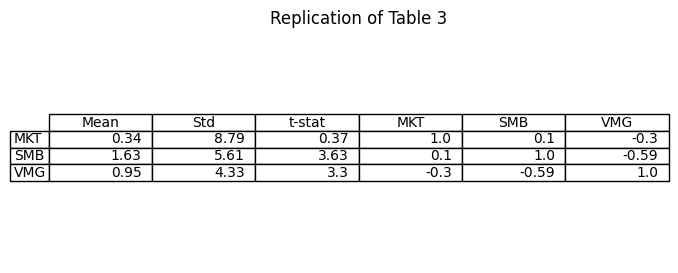

In [19]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# ==============================================================================
# 0. 配置路径与参数
# ==============================================================================
# 请修改为你本地数据的真实路径
base_data_dir = r"C:\Users\Pedro\PycharmProjects\pythonProject1\金融计量学\Replication_of_Liu_2019-main\data"
start_date = '2000-01-01'
end_date = '2016-12-31'

def load_csv(name):
    path = os.path.join(base_data_dir, name)
    if os.path.exists(path):
        return pd.read_csv(path, dtype={'Stkcd': str})
    elif os.path.exists(name):
        return pd.read_csv(name, dtype={'Stkcd': str})
    else:
        raise FileNotFoundError(f"找不到文件: {name}")

# ==============================================================================
# 1. 基础数据读取与预处理
# ==============================================================================
print(">>> [Step 1] 读取并处理基础数据...")

# 1.1 交易数据
trd = load_csv("TRD_Mnth.csv")
trd['Trdmnt'] = pd.to_datetime(trd['Trdmnt']) + pd.offsets.MonthEnd(0) # 统一到月末

# 筛选 A 股
if 'Markettype' in trd.columns:
    trd = trd[~trd['Markettype'].isin([2, 8])]

# 1.2 滞后市值 (关键！用于分组和剔除壳股)
# 我们需要 t-1 月的市值来构建 t 月的组合
trd.sort_values(['Stkcd', 'Trdmnt'], inplace=True)
trd['Lag_Msmvttl'] = trd.groupby('Stkcd')['Msmvttl'].shift(1) # 上个月的总市值

# 1.3 交易活跃度 (Liquidity Filter) - 基于 t-1 信息
trd['Nday_12m'] = trd.groupby('Stkcd')['Ndaytrd'].transform(lambda x: x.rolling(12, min_periods=1).sum())
# 筛选条件：过去一年交易>120天 & 本月(或上月?)交易>15天。
# 论文通常指 Formation Period 的状态。这里我们用当前行过滤参与计算的股票。
trd['IsLiquid'] = (trd['Nday_12m'] >= 120) & (trd['Ndaytrd'] >= 15)

# 1.4 IPO 筛选
ipo = load_csv("TRD_Co.csv")
ipo['Listdt'] = pd.to_datetime(ipo['Listdt'])
ipo_map = ipo.set_index('Stkcd')['Listdt']
trd['Listdt'] = trd['Stkcd'].map(ipo_map)
# 上市满 6 个月
trd = trd[trd['Trdmnt'] >= (trd['Listdt'] + pd.DateOffset(months=6))]

# 筛选时间范围 (确保有 Lag 数据)
trd = trd[(trd['Trdmnt'] >= start_date) & (trd['Trdmnt'] <= end_date)]
trd = trd[trd['IsLiquid'] == True]

# ==============================================================================
# 2. 计算 TTM EP
# ==============================================================================
print(">>> [Step 2] 计算 TTM 净利润...")

fi = load_csv("FI_T2.csv")
iar = load_csv("IAR_Rept.csv")

fi['Accper'] = pd.to_datetime(fi['Accper'])
iar['Accper'] = pd.to_datetime(iar['Accper'])
iar['Annodt'] = pd.to_datetime(iar['Annodt'])
iar = iar[iar['Reptyp'].isin([1, 2, 3, 4])]

# 去重：防止同一财报多条记录干扰计算
fi = fi.sort_values('Accper').drop_duplicates(subset=['Stkcd', 'Accper'], keep='last')
iar = iar.sort_values('Annodt').drop_duplicates(subset=['Stkcd', 'Accper'], keep='last')

# 2.1 计算单季利润
earnings = fi[['Stkcd', 'Accper', 'F020102']].copy().sort_values(['Stkcd', 'Accper'])
earnings['Month'] = earnings['Accper'].dt.month
earnings['Prev_F020102'] = earnings.groupby('Stkcd')['F020102'].shift(1)
earnings['Prev_Month'] = earnings.groupby('Stkcd')['Month'].shift(1)

def get_sq(row):
    if row['Month'] == 3: return row['F020102']
    # 同一年内累积相减
    if row['Month'] > row['Prev_Month'] and pd.notnull(row['Prev_F020102']):
        return row['F020102'] - row['Prev_F020102']
    return row['F020102'] # 无法差分时，用当前值近似

earnings['SQ_Profit'] = earnings.apply(get_sq, axis=1)

# 2.2 TTM 求和 (过去4个单季)
earnings['TTM_Profit'] = earnings.groupby('Stkcd')['SQ_Profit'].transform(
    lambda x: x.rolling(4, min_periods=4).sum()
)
# 缺失填补
mask = earnings['TTM_Profit'].isna()
earnings.loc[mask, 'TTM_Profit'] = earnings.loc[mask, 'F020102'] / earnings.loc[mask, 'Month'] * 12

# 2.3 匹配公告日
earnings_final = pd.merge(earnings[['Stkcd', 'Accper', 'TTM_Profit']],
                          iar[['Stkcd', 'Accper', 'Annodt']],
                          on=['Stkcd', 'Accper'])
earnings_final = earnings_final.dropna(subset=['Annodt', 'TTM_Profit']).sort_values('Annodt')

# 2.4 Merge 到交易月 (Point-in-time)
trd_sorted = trd.sort_values('Trdmnt')
panel = pd.merge_asof(
    trd_sorted,
    earnings_final[['Stkcd', 'Annodt', 'TTM_Profit']],
    left_on='Trdmnt',
    right_on='Annodt',
    by='Stkcd',
    direction='backward',
    tolerance=pd.Timedelta(days=365)
)

# 计算 EP (使用 Lagged Market Cap，避免 Look-ahead bias)
# EP = TTM Profit / Market Cap(t-1)
# 解释：我们在 t 月初构建组合，只能知道 t-1 月的市值
panel['EP'] = panel['TTM_Profit'] / (panel['Lag_Msmvttl'] * 1000)

panel = panel.dropna(subset=['Mretwd', 'Lag_Msmvttl', 'EP']).copy()

# ==============================================================================
# 3. 因子构建 (CH-3)
# ==============================================================================
print(">>> [Step 3] 因子构建 (使用 t-1 市值剔除壳股)...")

factors = []

for month, group in panel.groupby('Trdmnt'):
    if len(group) < 50: continue

    # === 关键修正：使用 Lag_Msmvttl 进行所有分组 ===

    # 3.1 剔除壳股 (基于 t-1 总市值)
    cutoff_30 = group['Lag_Msmvttl'].quantile(0.3)
    universe = group[group['Lag_Msmvttl'] > cutoff_30].copy()

    if len(universe) < 20: continue

    # 3.2 Size Group (S/B)
    median_size = universe['Lag_Msmvttl'].median()
    universe['Size_Grp'] = np.where(universe['Lag_Msmvttl'] < median_size, 'S', 'B')

    # 3.3 Value Group (V/M/G)
    ep_30 = universe['EP'].quantile(0.3)
    ep_70 = universe['EP'].quantile(0.7)

    def get_v_grp(x):
        if x <= ep_30: return 'G'
        elif x <= ep_70: return 'M'
        else: return 'V'
    universe['Value_Grp'] = universe['EP'].apply(get_v_grp)

    # 3.4 计算加权收益
    # 权重使用 Lag_Msmvttl (t-1 市值)
    universe['W_Ret'] = universe['Mretwd'] * universe['Lag_Msmvttl']

    grp_ret = universe.pivot_table(index=['Size_Grp', 'Value_Grp'],
                                   values=['W_Ret', 'Lag_Msmvttl'], aggfunc='sum')
    grp_ret['Ret'] = grp_ret['W_Ret'] / grp_ret['Lag_Msmvttl']

    def get_r(s, v):
        try: return grp_ret.loc[(s, v), 'Ret']
        except: return 0.0

    # 因子计算
    smb = (get_r('S','V') + get_r('S','M') + get_r('S','G'))/3 - \
          (get_r('B','V') + get_r('B','M') + get_r('B','G'))/3

    vmg = (get_r('S','V') + get_r('B','V'))/2 - \
          (get_r('S','G') + get_r('B','G'))/2

    # MKT (Raw) - Top 70% weighted
    mkt_raw = np.average(universe['Mretwd'], weights=universe['Lag_Msmvttl'])

    factors.append({'Trdmnt': month, 'MKT_Raw': mkt_raw, 'SMB': smb, 'VMG': vmg})

# 3.5 整理与 Rf 处理
fac_df = pd.DataFrame(factors)

rf = load_csv("BND_Exchange.csv")
rf['Clsdt'] = pd.to_datetime(rf['Clsdt'])
rf['Nrrdaydt'] = pd.to_numeric(rf['Nrrdaydt'], errors='coerce') / 100
rf['Trdmnt'] = rf['Clsdt'] + pd.offsets.MonthEnd(0)
rf_mon = rf.groupby('Trdmnt')['Nrrdaydt'].apply(lambda x: np.prod(1+x)-1).reset_index()

final = pd.merge(fac_df, rf_mon, on='Trdmnt', how='left')
final['MKT'] = final['MKT_Raw'] - final['Nrrdaydt']
final = final[['Trdmnt', 'MKT', 'SMB', 'VMG']].set_index('Trdmnt') * 100

# ==============================================================================
# 4. 输出结果
# ==============================================================================
print("\n>>> Table 3 Replication Result (Corrected Logic):")
stats = pd.DataFrame({
    'Mean': final.mean(),
    'Std': final.std(),
    't-stat': [float(sm.OLS(final[c], np.ones(len(final))).fit(cov_type='HAC', cov_kwds={'maxlags':5}).tvalues[0])
               for c in final.columns]
}).round(2)

print(pd.concat([stats, final.corr().round(2)], axis=1))

# 简单画图
fig, ax = plt.subplots(figsize=(8,3))
ax.axis('off')
ax.table(cellText=pd.concat([stats, final.corr().round(2)], axis=1).values,
         colLabels=['Mean', 'Std', 't-stat', 'MKT', 'SMB', 'VMG'],
         rowLabels=['MKT', 'SMB', 'VMG'],
         loc='center')
plt.title("Replication of Table 3")
plt.show()

table4

>>> [Table 4] 开始准备数据...
✅ 已加载内存中的 CH-3 因子数据。
回归样本准备完成，总观测数: 245072
正在标记壳股...
>>> 计算 Panel A (All Stocks)... [预计耗时较长]
  Model MKT: 0.335
  Model MKT+SMB: 0.462
  Model MKT+VMG: 0.418
  Model CH-3: 0.484
>>> 计算 Panel B (Excl. Bottom 30%)...
  Model MKT: 0.345
  Model MKT+SMB: 0.453
  Model MKT+VMG: 0.421
  Model CH-3: 0.476

=== Table 4 Replication Result (Avg Adj. R2) ===
Panel    Panel A: All Stocks  Panel B: Top 70%
MKT                 0.334514          0.345330
MKT+SMB             0.462493          0.453344
MKT+VMG             0.417893          0.421125
CH-3                0.484026          0.476225


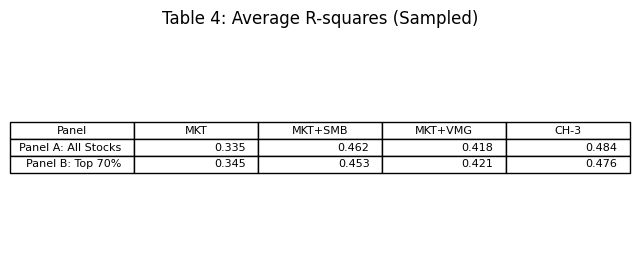

In [24]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
import os
import warnings

# 忽略不必要的警告
warnings.simplefilter(action='ignore', category=FutureWarning)

# ==============================================================================
# 0. 准备工作 & 配置
# ==============================================================================
print(">>> [Table 4] 开始准备数据...")

# 路径配置 (请确认路径正确)
base_data_dir = r"C:\Users\Pedro\PycharmProjects\pythonProject1\金融计量学\Replication_of_Liu_2019-main\data"
start_date = '2000-01-01'
end_date = '2016-12-31'

def load_csv(name):
    path = os.path.join(base_data_dir, name)
    if os.path.exists(path):
        return pd.read_csv(path, dtype={'Stkcd': str})
    elif os.path.exists(name):
        return pd.read_csv(name, dtype={'Stkcd': str})
    else:
        raise FileNotFoundError(f"找不到文件: {name}")

# 检查内存中是否有因子数据
if 'ch3_factors' not in locals():
    print("❌ 警告：未检测到 'ch3_factors' 变量。请先运行 Table 3 的代码生成因子数据！")
    # 如果你之前保存了，可以在这里读取
    # ch3_factors = pd.read_csv("ch3_factors.csv", index_col=0, parse_dates=True)
else:
    print("✅ 已加载内存中的 CH-3 因子数据。")

# 确保因子对齐到月末
factors = ch3_factors.copy()
factors.index = pd.to_datetime(factors.index) + pd.offsets.MonthEnd(0)

# ==============================================================================
# 1. 读取个股全样本数据 (需要包含壳股)
# ==============================================================================
# 重新读取 TRD_Mnth
trd_all = load_csv("TRD_Mnth.csv")
trd_all['Trdmnt'] = pd.to_datetime(trd_all['Trdmnt']) + pd.offsets.MonthEnd(0)

# 筛选 A 股
if 'Markettype' in trd_all.columns:
    trd_all = trd_all[~trd_all['Markettype'].isin([2, 8])]
trd_all = trd_all[(trd_all['Trdmnt'] >= start_date) & (trd_all['Trdmnt'] <= end_date)]

# 读取无风险利率
rf = load_csv("BND_Exchange.csv")
rf['Clsdt'] = pd.to_datetime(rf['Clsdt'])
rf['Month'] = rf['Clsdt'] + pd.offsets.MonthEnd(0)
rf['Nrrdaydt'] = pd.to_numeric(rf['Nrrdaydt'], errors='coerce') / 100
rf_mon = rf.groupby('Month')['Nrrdaydt'].apply(lambda x: np.prod(1+x)-1).reset_index()
rf_mon.rename(columns={'Nrrdaydt': 'Rf'}, inplace=True)

# 合并个股收益与 Rf
data = pd.merge(trd_all[['Stkcd', 'Trdmnt', 'Mretwd', 'Msmvttl']],
                rf_mon, left_on='Trdmnt', right_on='Month', how='inner')

# 计算个股超额收益 (百分比单位，与因子一致)
data['ExRet'] = (data['Mretwd'] - data['Rf']) * 100
data = data.dropna(subset=['ExRet'])

# 合并因子数据
reg_data = pd.merge(data, factors, left_on='Trdmnt', right_index=True, how='inner')
reg_data.sort_values(['Stkcd', 'Trdmnt'], inplace=True)

print(f"回归样本准备完成，总观测数: {len(reg_data)}")

# ==============================================================================
# 2. 定义高效滚动回归函数 (手动实现 OLS 加速)
# ==============================================================================
def fast_rolling_r2(sub_df, factor_cols, window=36):
    T = len(sub_df)
    if T < window: return np.nan

    Y = sub_df['ExRet'].values
    # X 包含常数项
    X = sub_df[['const'] + factor_cols].values

    r2s = []

    # 滚动窗口循环
    for i in range(window, T + 1):
        y_win = Y[i-window : i]
        X_win = X[i-window : i]

        # OLS 求解: beta = (X'X)^-1 X'y
        # 使用 lstsq 比 inv 更快更稳健
        try:
            beta, _, _, _ = np.linalg.lstsq(X_win, y_win, rcond=None)
            y_pred = X_win @ beta

            # 计算 R2
            ss_res = np.sum((y_win - y_pred)**2)
            ss_tot = np.sum((y_win - np.mean(y_win))**2)

            if ss_tot == 0: continue

            r2 = 1 - ss_res / ss_tot

            # 计算 Adjusted R2
            n, k = window, X_win.shape[1] # k 包含截距项
            adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k)

            r2s.append(adj_r2)
        except:
            continue

    return np.mean(r2s) if r2s else np.nan

# ==============================================================================
# 3. 执行计算 (Panel A & B)
# ==============================================================================
models = {
    'MKT': ['MKT'],
    'MKT+SMB': ['MKT', 'SMB'],
    'MKT+VMG': ['MKT', 'VMG'],
    'CH-3': ['MKT', 'SMB', 'VMG']
}

# 标记是否为壳股 (Bottom 30%)
print("正在标记壳股...")
reg_data['Size_Q30'] = reg_data.groupby('Trdmnt')['Msmvttl'].transform(lambda x: x.quantile(0.3))
reg_data['IsShell'] = reg_data['Msmvttl'] <= reg_data['Size_Q30']

# 准备数据 (加常数项)
reg_data = sm.add_constant(reg_data)

final_results = []

# --- Panel A: All Stocks ---
print(">>> 计算 Panel A (All Stocks)... [预计耗时较长]")
# 筛选出至少有 36 个月数据的股票
valid_stks = reg_data['Stkcd'].value_counts()
valid_stks = valid_stks[valid_stks >= 48].index # 稍微放宽一点余量

# 【修复点】这里原来写错成了 valid_stk (单数)，已修正为 valid_stks (复数)
df_panel_a = reg_data[reg_data['Stkcd'].isin(valid_stks)].copy()

# 抽样演示 (如果想跑全样本，请注释下面两行)
# sample_stks = np.random.choice(valid_stks, 500, replace=False)
# df_panel_a = df_panel_a[df_panel_a['Stkcd'].isin(sample_stks)]
# print(f"  (演示模式: 仅计算 {len(sample_stks)} 只股票)")

res_a = {}
for m_name, cols in models.items():
    # 使用 groupby apply 运行加速回归函数
    r2_list = df_panel_a.groupby('Stkcd').apply(lambda x: fast_rolling_r2(x, cols))
    res_a[m_name] = r2_list.mean()
    print(f"  Model {m_name}: {res_a[m_name]:.3f}")

final_results.append({'Panel': 'Panel A: All Stocks', **res_a})

# --- Panel B: Excluding Shells (Top 70%) ---
print(">>> 计算 Panel B (Excl. Bottom 30%)...")
# 逻辑：只保留非壳股的月份
df_panel_b = reg_data[reg_data['IsShell'] == False].copy()
valid_stks_b = df_panel_b['Stkcd'].value_counts()
valid_stks_b = valid_stks_b[valid_stks_b >= 48].index

# 抽样
# sample_stks_b = np.random.choice(valid_stks_b, 500, replace=False)
# df_panel_b = df_panel_b[df_panel_b['Stkcd'].isin(sample_stks_b)]
# print(f"  (演示模式: 仅计算 {len(sample_stks_b)} 只股票)")

res_b = {}
for m_name, cols in models.items():
    r2_list = df_panel_b.groupby('Stkcd').apply(lambda x: fast_rolling_r2(x, cols))
    res_b[m_name] = r2_list.mean()
    print(f"  Model {m_name}: {res_b[m_name]:.3f}")

final_results.append({'Panel': 'Panel B: Top 70%', **res_b})

# ==============================================================================
# 4. 展示结果
# ==============================================================================
table4 = pd.DataFrame(final_results)
print("\n=== Table 4 Replication Result (Avg Adj. R2) ===")
# 转置显示更像论文格式
print(table4.set_index('Panel').T)

# 简单画图
fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('off')
ax.table(cellText=table4.round(3).values,
         colLabels=table4.columns,
         loc='center')
plt.title("Table 4: Average R-squares (Sampled)")
plt.show()

table5

>>> [Step 1] 读取数据并计算因子指标 (EP & BM)...
数据准备完成，有效样本行数: 136095
>>> [Step 2] 构建因子序列...
>>> [Step 3] 运行模型对比检验...

=== Table 5 Panel A: Alphas ===
  Model Factor  Alpha  t-stat
0  CH-3  FFSMB   0.07    0.58
1  CH-3  FFHML  -0.10   -0.22
2  FF-3    SMB   0.46    2.73
3  FF-3    VMG   1.30    5.20

=== Table 5 Panel B: GRS Tests ===
  Model   Test Assets     GRS  p-value
0  CH-3  FFSMB, FFHML   0.279    0.757
1  FF-3      SMB, VMG  13.168    0.000


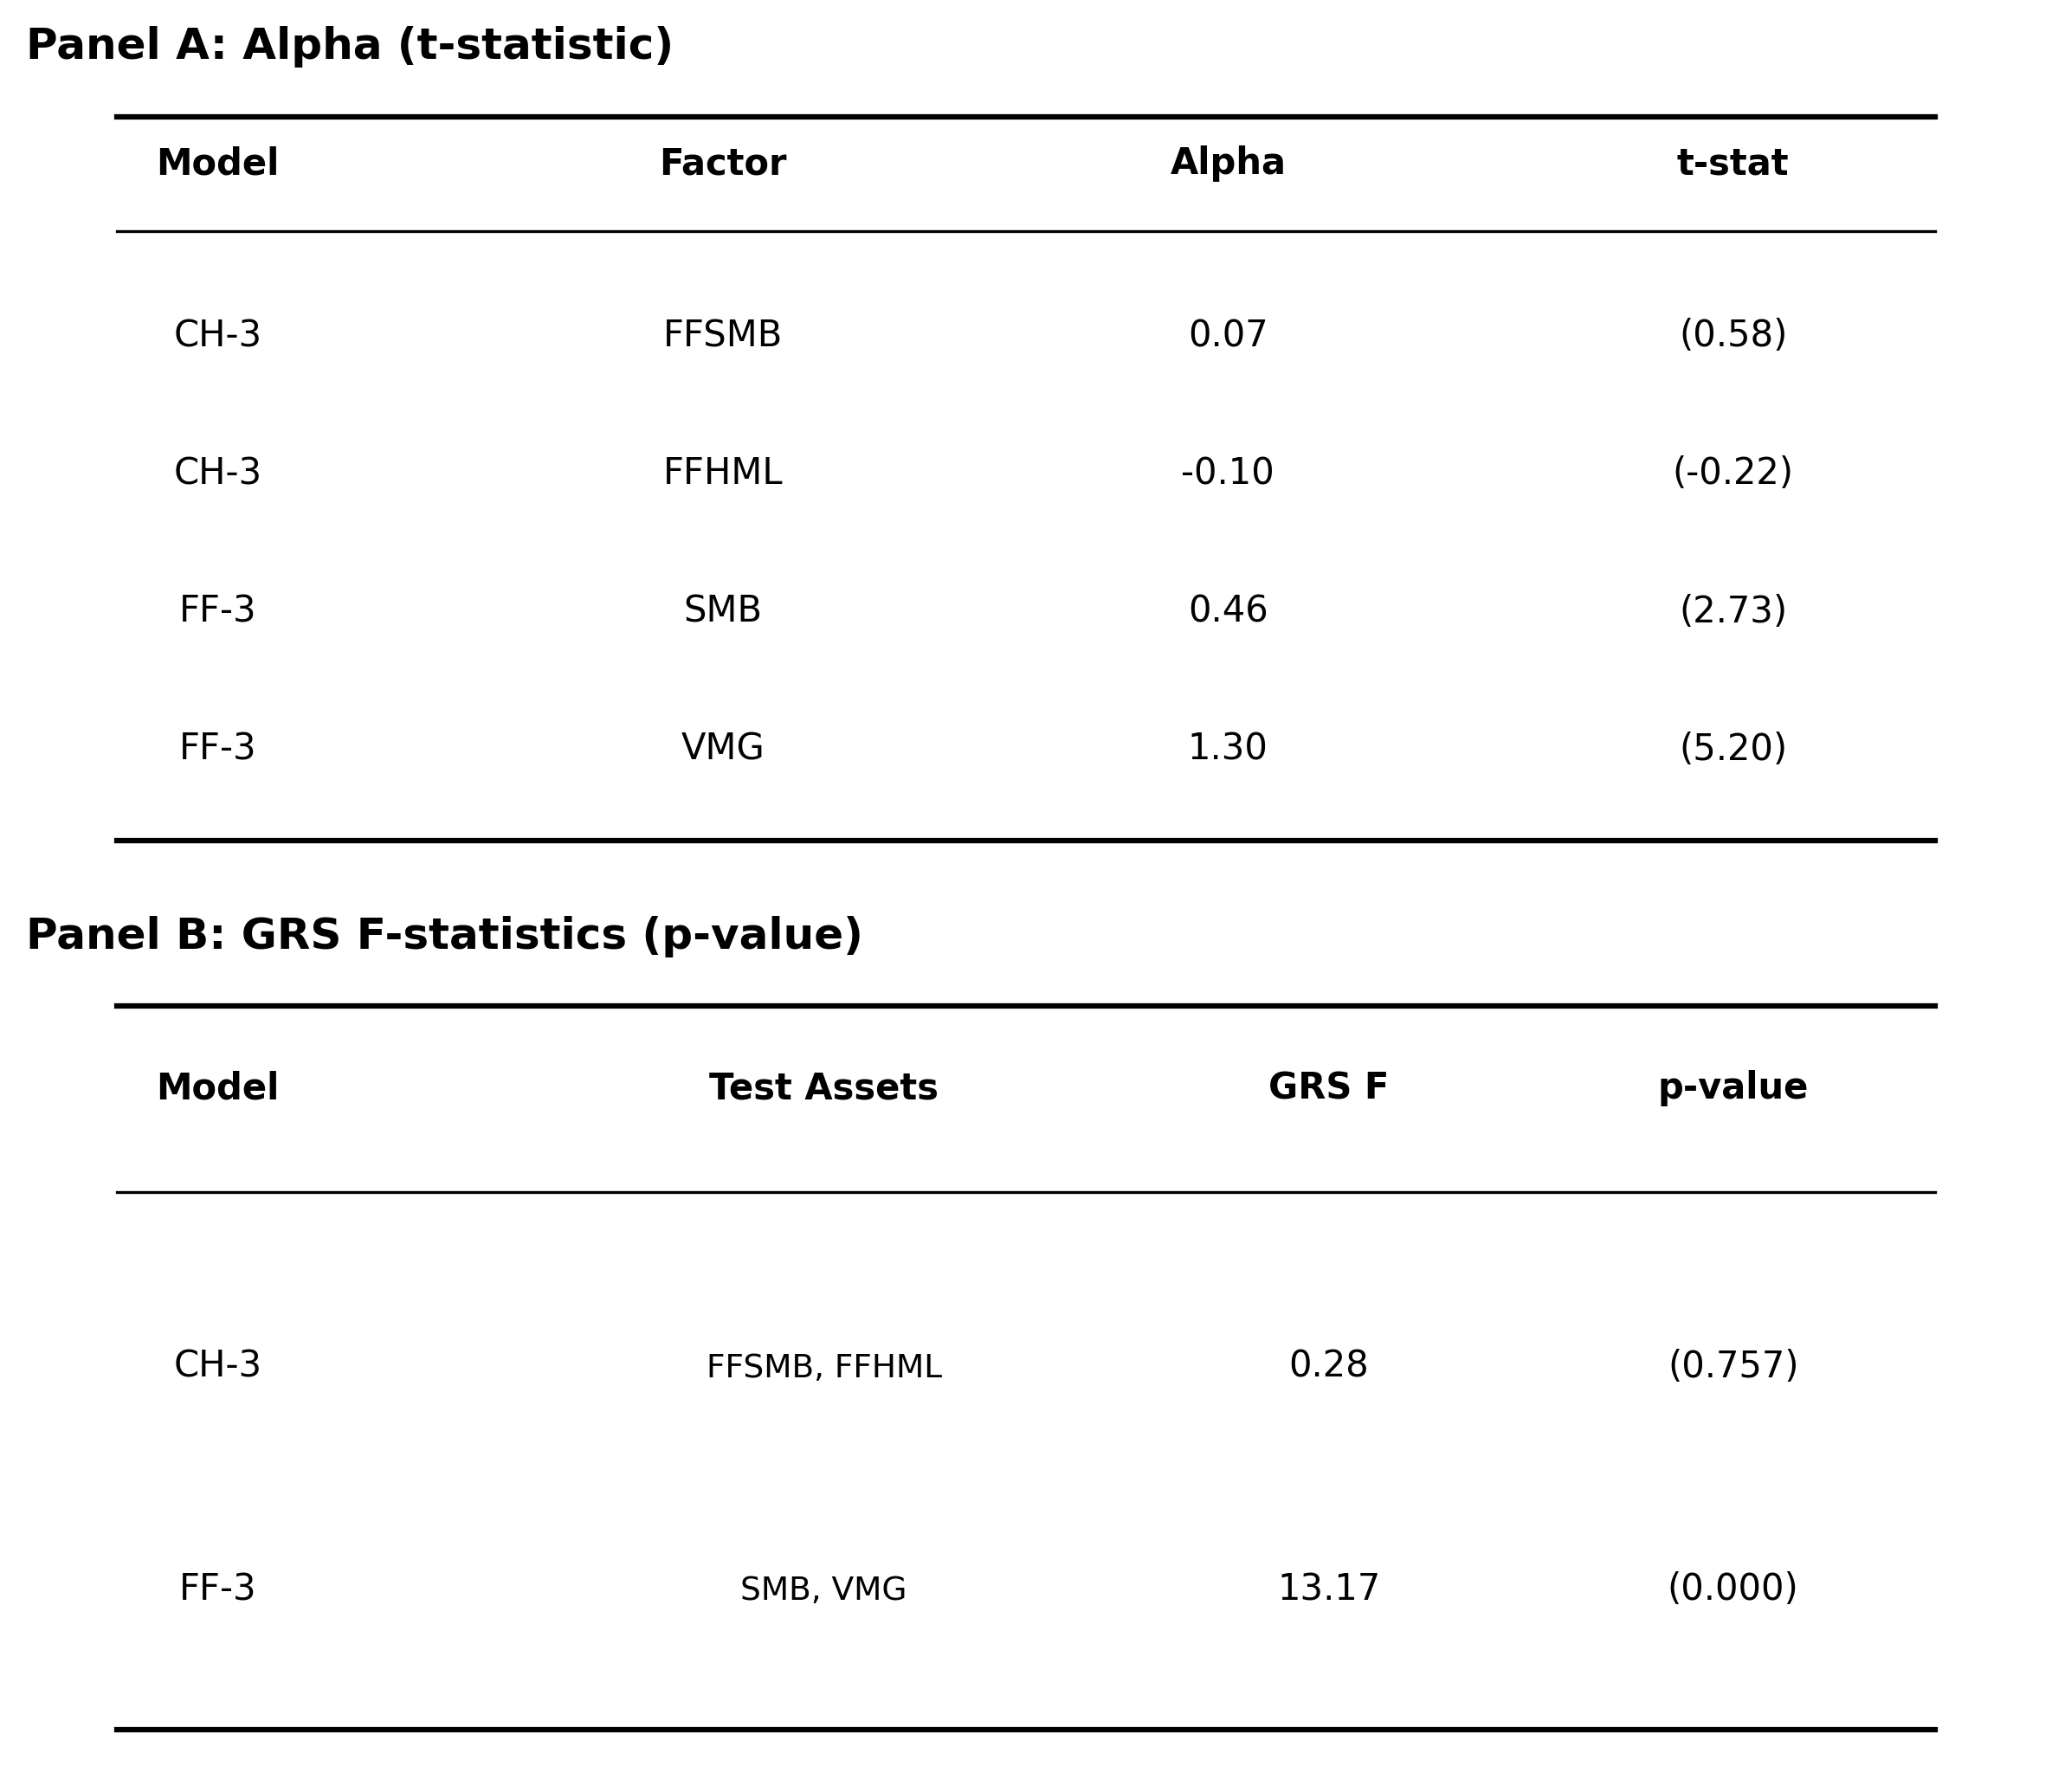

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import f
import matplotlib.pyplot as plt
import os
import warnings

# 忽略警告
warnings.simplefilter(action='ignore', category=FutureWarning)

# ==============================================================================
# 0. 配置与加载
# ==============================================================================
# 请确保路径正确，且 FS_Combas.csv 已放入该目录
base_data_dir = r"C:\Users\Pedro\PycharmProjects\pythonProject1\金融计量学\Replication_of_Liu_2019-main\data"
start_date = '2000-01-01'
end_date = '2016-12-31'

def load_csv(name):
    path = os.path.join(base_data_dir, name)
    if os.path.exists(path):
        return pd.read_csv(path, dtype={'Stkcd': str})
    elif os.path.exists(name):
        return pd.read_csv(name, dtype={'Stkcd': str})
    else:
        raise FileNotFoundError(f"找不到文件: {name}")

# ==============================================================================
# 1. 准备基础宽表 (计算 EP 和 BM)
# ==============================================================================
print(">>> [Step 1] 读取数据并计算因子指标 (EP & BM)...")

# 1.1 交易数据
trd = load_csv("TRD_Mnth.csv")
trd['Trdmnt'] = pd.to_datetime(trd['Trdmnt']) + pd.offsets.MonthEnd(0)
if 'Markettype' in trd.columns:
    trd = trd[~trd['Markettype'].isin([2, 8])] # 剔除 B 股

# 滞后市值 (用于分组分母)
trd.sort_values(['Stkcd', 'Trdmnt'], inplace=True)
trd['Lag_Msmvttl'] = trd.groupby('Stkcd')['Msmvttl'].shift(1)

# 流动性筛选
trd['Nday_12m'] = trd.groupby('Stkcd')['Ndaytrd'].transform(lambda x: x.rolling(12, min_periods=1).sum())
trd['IsLiquid'] = (trd['Nday_12m'] >= 120) & (trd['Ndaytrd'] >= 15)

# IPO 筛选
ipo = load_csv("TRD_Co.csv")
ipo['Listdt'] = pd.to_datetime(ipo['Listdt'])
trd = pd.merge(trd, ipo[['Stkcd', 'Listdt']], on='Stkcd', how='left')
trd = trd[trd['Trdmnt'] >= (trd['Listdt'] + pd.DateOffset(months=6))]

# 应用筛选
trd = trd[(trd['Trdmnt'] >= start_date) & (trd['Trdmnt'] <= end_date)]
trd = trd[trd['IsLiquid'] == True]

# 1.2 财务数据
fi = load_csv("FI_T2.csv") # 利润 (EP分子)
bs = load_csv("FS_Combas.csv") # 资产负债 (BM分子)
iar = load_csv("IAR_Rept.csv") # 公告日

# 格式化日期
for df in [fi, bs, iar]:
    if 'Accper' in df.columns:
        df['Accper'] = pd.to_datetime(df['Accper'])
iar['Annodt'] = pd.to_datetime(iar['Annodt'])
# 筛选定期报告 (1,2,3,4)
iar = iar[iar['Reptyp'].isin([1, 2, 3, 4])]

# --- A. 计算 TTM EP (CH-3 Value) ---
# F020102: 扣非净利润 (FI_T2)
ep_data = fi[['Stkcd', 'Accper', 'F020102']].copy().sort_values(['Stkcd', 'Accper'])
# 单季拆分与 TTM
ep_data['Month'] = ep_data['Accper'].dt.month
ep_data['Prev_F020102'] = ep_data.groupby('Stkcd')['F020102'].shift(1)
ep_data['Prev_Month'] = ep_data.groupby('Stkcd')['Month'].shift(1)

def get_sq(row):
    if row['Month'] == 3: return row['F020102']
    if row['Month'] > row['Prev_Month']: return row['F020102'] - row['Prev_F020102']
    return row['F020102']

ep_data['SQ_Profit'] = ep_data.apply(get_sq, axis=1)
ep_data['TTM_Profit'] = ep_data.groupby('Stkcd')['SQ_Profit'].transform(lambda x: x.rolling(4, min_periods=4).sum())
# 缺失填补
mask = ep_data['TTM_Profit'].isna()
ep_data.loc[mask, 'TTM_Profit'] = ep_data.loc[mask, 'F020102'] / ep_data.loc[mask, 'Month'] * 12

# --- B. 提取 Book Equity (FF-3 Value) ---
# A003000000: 所有者权益合计 (FS_Combas)[csv].txt]
# 筛选合并报表 (Typrep == 'A')
if 'Typrep' in bs.columns:
    bs = bs[bs['Typrep'] == 'A']

# 提取权益列
equity_col = 'A003000000'
if equity_col not in bs.columns:
    raise KeyError(f"在 FS_Combas.csv 中未找到 {equity_col} 列，请检查文件！")

be_data = bs[['Stkcd', 'Accper', equity_col]].rename(columns={equity_col: 'BookEquity'})

# --- 合并财务数据 ---
fin_merged = pd.merge(ep_data[['Stkcd', 'Accper', 'TTM_Profit']],
                      be_data, on=['Stkcd', 'Accper'], how='outer')

# 匹配公告日
fin_final = pd.merge(fin_merged, iar[['Stkcd', 'Accper', 'Annodt']], on=['Stkcd', 'Accper'])
fin_final = fin_final.dropna(subset=['Annodt']).sort_values('Annodt')

# --- Merge AsOf 到月度交易数据 ---
trd_sorted = trd.sort_values('Trdmnt')
panel = pd.merge_asof(
    trd_sorted,
    fin_final[['Stkcd', 'Annodt', 'TTM_Profit', 'BookEquity']],
    left_on='Trdmnt', right_on='Annodt', by='Stkcd', direction='backward',
    tolerance=pd.Timedelta(days=365)
)

# 计算指标
# EP = TTM Profit / Lag Market Cap
panel['EP'] = panel['TTM_Profit'] / (panel['Lag_Msmvttl'] * 1000)
# BM = Book Equity / Lag Market Cap
panel['BM'] = panel['BookEquity'] / (panel['Lag_Msmvttl'] * 1000)

# 清洗有效样本
panel = panel.dropna(subset=['Mretwd', 'Lag_Msmvttl', 'EP', 'BM']).copy()
print(f"数据准备完成，有效样本行数: {len(panel)}")

# ==============================================================================
# 2. 构建 CH-3 和 FF-3 因子
# ==============================================================================
print(">>> [Step 2] 构建因子序列...")

def build_factors(df, value_col, factor_prefix):
    fac_list = []
    # 动态分组
    for month, group in df.groupby('Trdmnt'):
        if len(group) < 50: continue

        # 1. 剔除壳股 (基于 t-1 市值剔除 Bottom 30%)
        # 无论是 CH-3 还是 FF-3，都在剔除壳股后的样本中构建 (论文 5.3 节)
        cutoff_size = group['Lag_Msmvttl'].quantile(0.3)
        universe = group[group['Lag_Msmvttl'] > cutoff_size].copy()

        if len(universe) < 20: continue

        # 2. Size 分组 (Median)
        size_med = universe['Lag_Msmvttl'].median()
        universe['Size_Grp'] = np.where(universe['Lag_Msmvttl'] < size_med, 'S', 'B')

        # 3. Value 分组 (30%, 70%)
        p30 = universe[value_col].quantile(0.3)
        p70 = universe[value_col].quantile(0.7)

        def assign_grp(x):
            if x <= p30: return 'L' # Growth
            elif x <= p70: return 'M'
            else: return 'H' # Value
        universe['Value_Grp'] = universe[value_col].apply(assign_grp)

        # 4. 加权收益 (Value-Weighted)
        universe['W_Ret'] = universe['Mretwd'] * universe['Lag_Msmvttl']
        grp_ret = universe.pivot_table(index=['Size_Grp', 'Value_Grp'],
                                       values=['W_Ret', 'Lag_Msmvttl'], aggfunc='sum')
        grp_ret['Ret'] = grp_ret['W_Ret'] / grp_ret['Lag_Msmvttl']

        def get_r(s, v):
            try: return grp_ret.loc[(s, v), 'Ret']
            except: return 0.0

        # 5. 因子合成 (2x3)
        # SMB = (Small 3组均值) - (Big 3组均值)
        smb = (get_r('S','L') + get_r('S','M') + get_r('S','H'))/3 - \
              (get_r('B','L') + get_r('B','M') + get_r('B','H'))/3

        # Value Factor (HML / VMG) = (High Value 2组均值) - (Low Value 2组均值)
        # EP: High=Value, Low=Growth; BM: High=Value, Low=Growth. 逻辑一致。
        hml = (get_r('S','H') + get_r('B','H'))/2 - \
              (get_r('S','L') + get_r('B','L'))/2

        fac_list.append({
            'Trdmnt': month,
            f'{factor_prefix}SMB': smb,
            f'{factor_prefix}HML': hml # 注意：CH-3里叫VMG, FF-3里叫HML
        })
    return pd.DataFrame(fac_list)

# 构建 CH-3 (使用 EP)
ch3 = build_factors(panel, 'EP', '')
ch3.rename(columns={'HML': 'VMG'}, inplace=True) # 论文命名习惯

# 构建 FF-3 (使用 BM)
ff3 = build_factors(panel, 'BM', 'FF')

# 处理 Rf 和 MKT
rf = load_csv("BND_Exchange.csv")
rf['Clsdt'] = pd.to_datetime(rf['Clsdt'])
rf['Nrrdaydt'] = pd.to_numeric(rf['Nrrdaydt'], errors='coerce') / 100
rf['Trdmnt'] = rf['Clsdt'] + pd.offsets.MonthEnd(0)
rf_mon = rf.groupby('Trdmnt')['Nrrdaydt'].apply(lambda x: np.prod(1+x)-1).reset_index()

# 计算 MKT (Top 70% VW)
mkt_list = []
for month, group in panel.groupby('Trdmnt'):
    cutoff = group['Lag_Msmvttl'].quantile(0.3)
    univ = group[group['Lag_Msmvttl'] > cutoff]
    if len(univ) > 0:
        mkt = np.average(univ['Mretwd'], weights=univ['Lag_Msmvttl'])
        mkt_list.append({'Trdmnt': month, 'MKT_Raw': mkt})
mkt_df = pd.DataFrame(mkt_list)

# 合并所有因子
factors = pd.merge(ch3, ff3, on='Trdmnt')
factors = pd.merge(factors, mkt_df, on='Trdmnt')
factors = pd.merge(factors, rf_mon, on='Trdmnt', how='left')

factors['MKT'] = factors['MKT_Raw'] - factors['Nrrdaydt']
factors.set_index('Trdmnt', inplace=True)
factors = factors * 100 # 转百分比

# ==============================================================================
# 3. 运行检验 (Table 5)
# ==============================================================================
if not factors.empty:
    print(">>> [Step 3] 运行模型对比检验...")

    # GRS Test 函数
    def grs_test(alphas, resid, factors):
        T, N = resid.shape
        K = factors.shape[1]
        Sigma = resid.cov()
        mu_f = factors.mean()
        Omega_f = factors.cov()
        try:
            Sigma_inv = np.linalg.inv(Sigma)
            Omega_inv = np.linalg.inv(Omega_f)
            numer = (T - N - K) / N
            denom = 1 + mu_f.T @ Omega_inv @ mu_f
            alpha_part = alphas.T @ Sigma_inv @ alphas
            J = numer * (alpha_part / denom)
            p_val = 1 - f.cdf(J, N, T - N - K)
            return J, p_val
        except:
            return np.nan, np.nan

    results_panel_a = []
    grs_results = []

    # Model 1: CH-3 解释 FF-3 因子
    # 解释变量(RHS): MKT, SMB, VMG
    # 被解释变量(LHS): FFSMB, FFHML
    Y = factors[['FFSMB', 'FFHML']]
    X = sm.add_constant(factors[['MKT', 'SMB', 'VMG']])

    alphas_1 = []
    resids_1 = []

    for col in Y.columns:
        model = sm.OLS(Y[col], X).fit(cov_type='HAC', cov_kwds={'maxlags': 5})
        alphas_1.append(model.params['const'])
        resids_1.append(model.resid)
        results_panel_a.append({
            'Model': 'CH-3', 'Factor': col,
            'Alpha': model.params['const'], 't-stat': model.tvalues['const']
        })

    J1, p1 = grs_test(np.array(alphas_1), pd.DataFrame(resids_1).T, factors[['MKT', 'SMB', 'VMG']])
    grs_results.append({'Model': 'CH-3', 'Test Assets': 'FFSMB, FFHML', 'GRS': J1, 'p-value': p1})

    # Model 2: FF-3 解释 CH-3 因子
    # 解释变量(RHS): MKT, FFSMB, FFHML
    # 被解释变量(LHS): SMB, VMG
    Y = factors[['SMB', 'VMG']]
    X = sm.add_constant(factors[['MKT', 'FFSMB', 'FFHML']])

    alphas_2 = []
    resids_2 = []

    for col in Y.columns:
        model = sm.OLS(Y[col], X).fit(cov_type='HAC', cov_kwds={'maxlags': 5})
        alphas_2.append(model.params['const'])
        resids_2.append(model.resid)
        results_panel_a.append({
            'Model': 'FF-3', 'Factor': col,
            'Alpha': model.params['const'], 't-stat': model.tvalues['const']
        })

    J2, p2 = grs_test(np.array(alphas_2), pd.DataFrame(resids_2).T, factors[['MKT', 'FFSMB', 'FFHML']])
    grs_results.append({'Model': 'FF-3', 'Test Assets': 'SMB, VMG', 'GRS': J2, 'p-value': p2})

    # 输出表格
    res_df = pd.DataFrame(results_panel_a)
    grs_df = pd.DataFrame(grs_results)

    print("\n=== Table 5 Panel A: Alphas ===")
    print(res_df.round(2))
    print("\n=== Table 5 Panel B: GRS Tests ===")
    print(grs_df.round(3))

    # 4. 绘图 (JFE 风格)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 7), dpi=300)

    # Panel A
    ax1.axis('off')
    ax1.set_title('Panel A: Alpha (t-statistic)', weight='bold', loc='left')

    cols = [0.1, 0.35, 0.60, 0.85]
    y = 0.85
    ax1.plot([0.05, 0.95], [y, y], 'k-', lw=1.5)
    headers = ['Model', 'Factor', 'Alpha', 't-stat']
    for i, h in enumerate(headers):
        ax1.text(cols[i], y-0.05, h, ha='center', weight='bold')
    ax1.plot([0.05, 0.95], [y-0.1, y-0.1], 'k-', lw=0.8)

    curr_y = y - 0.2
    for idx, row in res_df.iterrows():
        ax1.text(cols[0], curr_y, row['Model'], ha='center')
        ax1.text(cols[1], curr_y, row['Factor'], ha='center')
        ax1.text(cols[2], curr_y, f"{row['Alpha']:.2f}", ha='center')
        ax1.text(cols[3], curr_y, f"({row['t-stat']:.2f})", ha='center')
        curr_y -= 0.12
    ax1.plot([0.05, 0.95], [curr_y+0.05, curr_y+0.05], 'k-', lw=1.5)

    # Panel B
    ax2.axis('off')
    ax2.set_title('Panel B: GRS F-statistics (p-value)', weight='bold', loc='left')

    cols_b = [0.1, 0.4, 0.65, 0.85]
    y = 0.85
    ax2.plot([0.05, 0.95], [y, y], 'k-', lw=1.5)
    headers_b = ['Model', 'Test Assets', 'GRS F', 'p-value']
    for i, h in enumerate(headers_b):
        ax2.text(cols_b[i], y-0.05, h, ha='center', weight='bold')
    ax2.plot([0.05, 0.95], [y-0.1, y-0.1], 'k-', lw=0.8)

    curr_y = y - 0.2
    for idx, row in grs_df.iterrows():
        ax2.text(cols_b[0], curr_y, row['Model'], ha='center')
        ax2.text(cols_b[1], curr_y, row['Test Assets'], ha='center', fontsize=9)
        ax2.text(cols_b[2], curr_y, f"{row['GRS']:.2f}", ha='center')
        ax2.text(cols_b[3], curr_y, f"({row['p-value']:.3f})", ha='center')
        curr_y -= 0.12
    ax2.plot([0.05, 0.95], [curr_y+0.05, curr_y+0.05], 'k-', lw=1.5)

    plt.tight_layout()
    plt.show()

else:
    print("❌ 错误：因子生成失败，可能数据对齐问题。")

table6

✅ 已检测到 full_data，开始计算 Table 6 全指标...
>>> 开始计算所有指标 (R, Alpha, Beta)...


C:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:4657: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
C:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:4657: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
C:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:4657: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
C:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:4657: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
C:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:


=== Table 6 Replication Data ===
                     Panel   Anomaly  R_tilde   t_R  Alpha  t_Alpha  Beta  \
0   Panel A: Unconditional      Size     1.82  2.68   1.76     2.66  0.14   
1    Panel B: Size-neutral      Size    -0.00 -0.01  -0.02    -0.08  0.04   
2   Panel A: Unconditional        EP     0.35  0.61   0.43     0.82 -0.21   
3    Panel B: Size-neutral        EP     1.67  4.80   1.68     4.92 -0.02   
4   Panel A: Unconditional        BM     0.70  1.11   0.72     1.17 -0.06   
5    Panel B: Size-neutral        BM     0.79  1.54   0.77     1.55  0.05   
6   Panel A: Unconditional        CP    -0.61 -1.32  -0.51    -1.42 -0.25   
7    Panel B: Size-neutral        CP     0.30  1.31   0.34     1.55 -0.11   
8   Panel A: Unconditional       ROE     0.48  0.88   0.53     0.99 -0.12   
9    Panel B: Size-neutral       ROE     1.60  5.11   1.62     5.31 -0.05   
10  Panel A: Unconditional    Vol_1M     0.57  0.84   0.70     1.02 -0.35   
11   Panel B: Size-neutral    Vol_1M     0

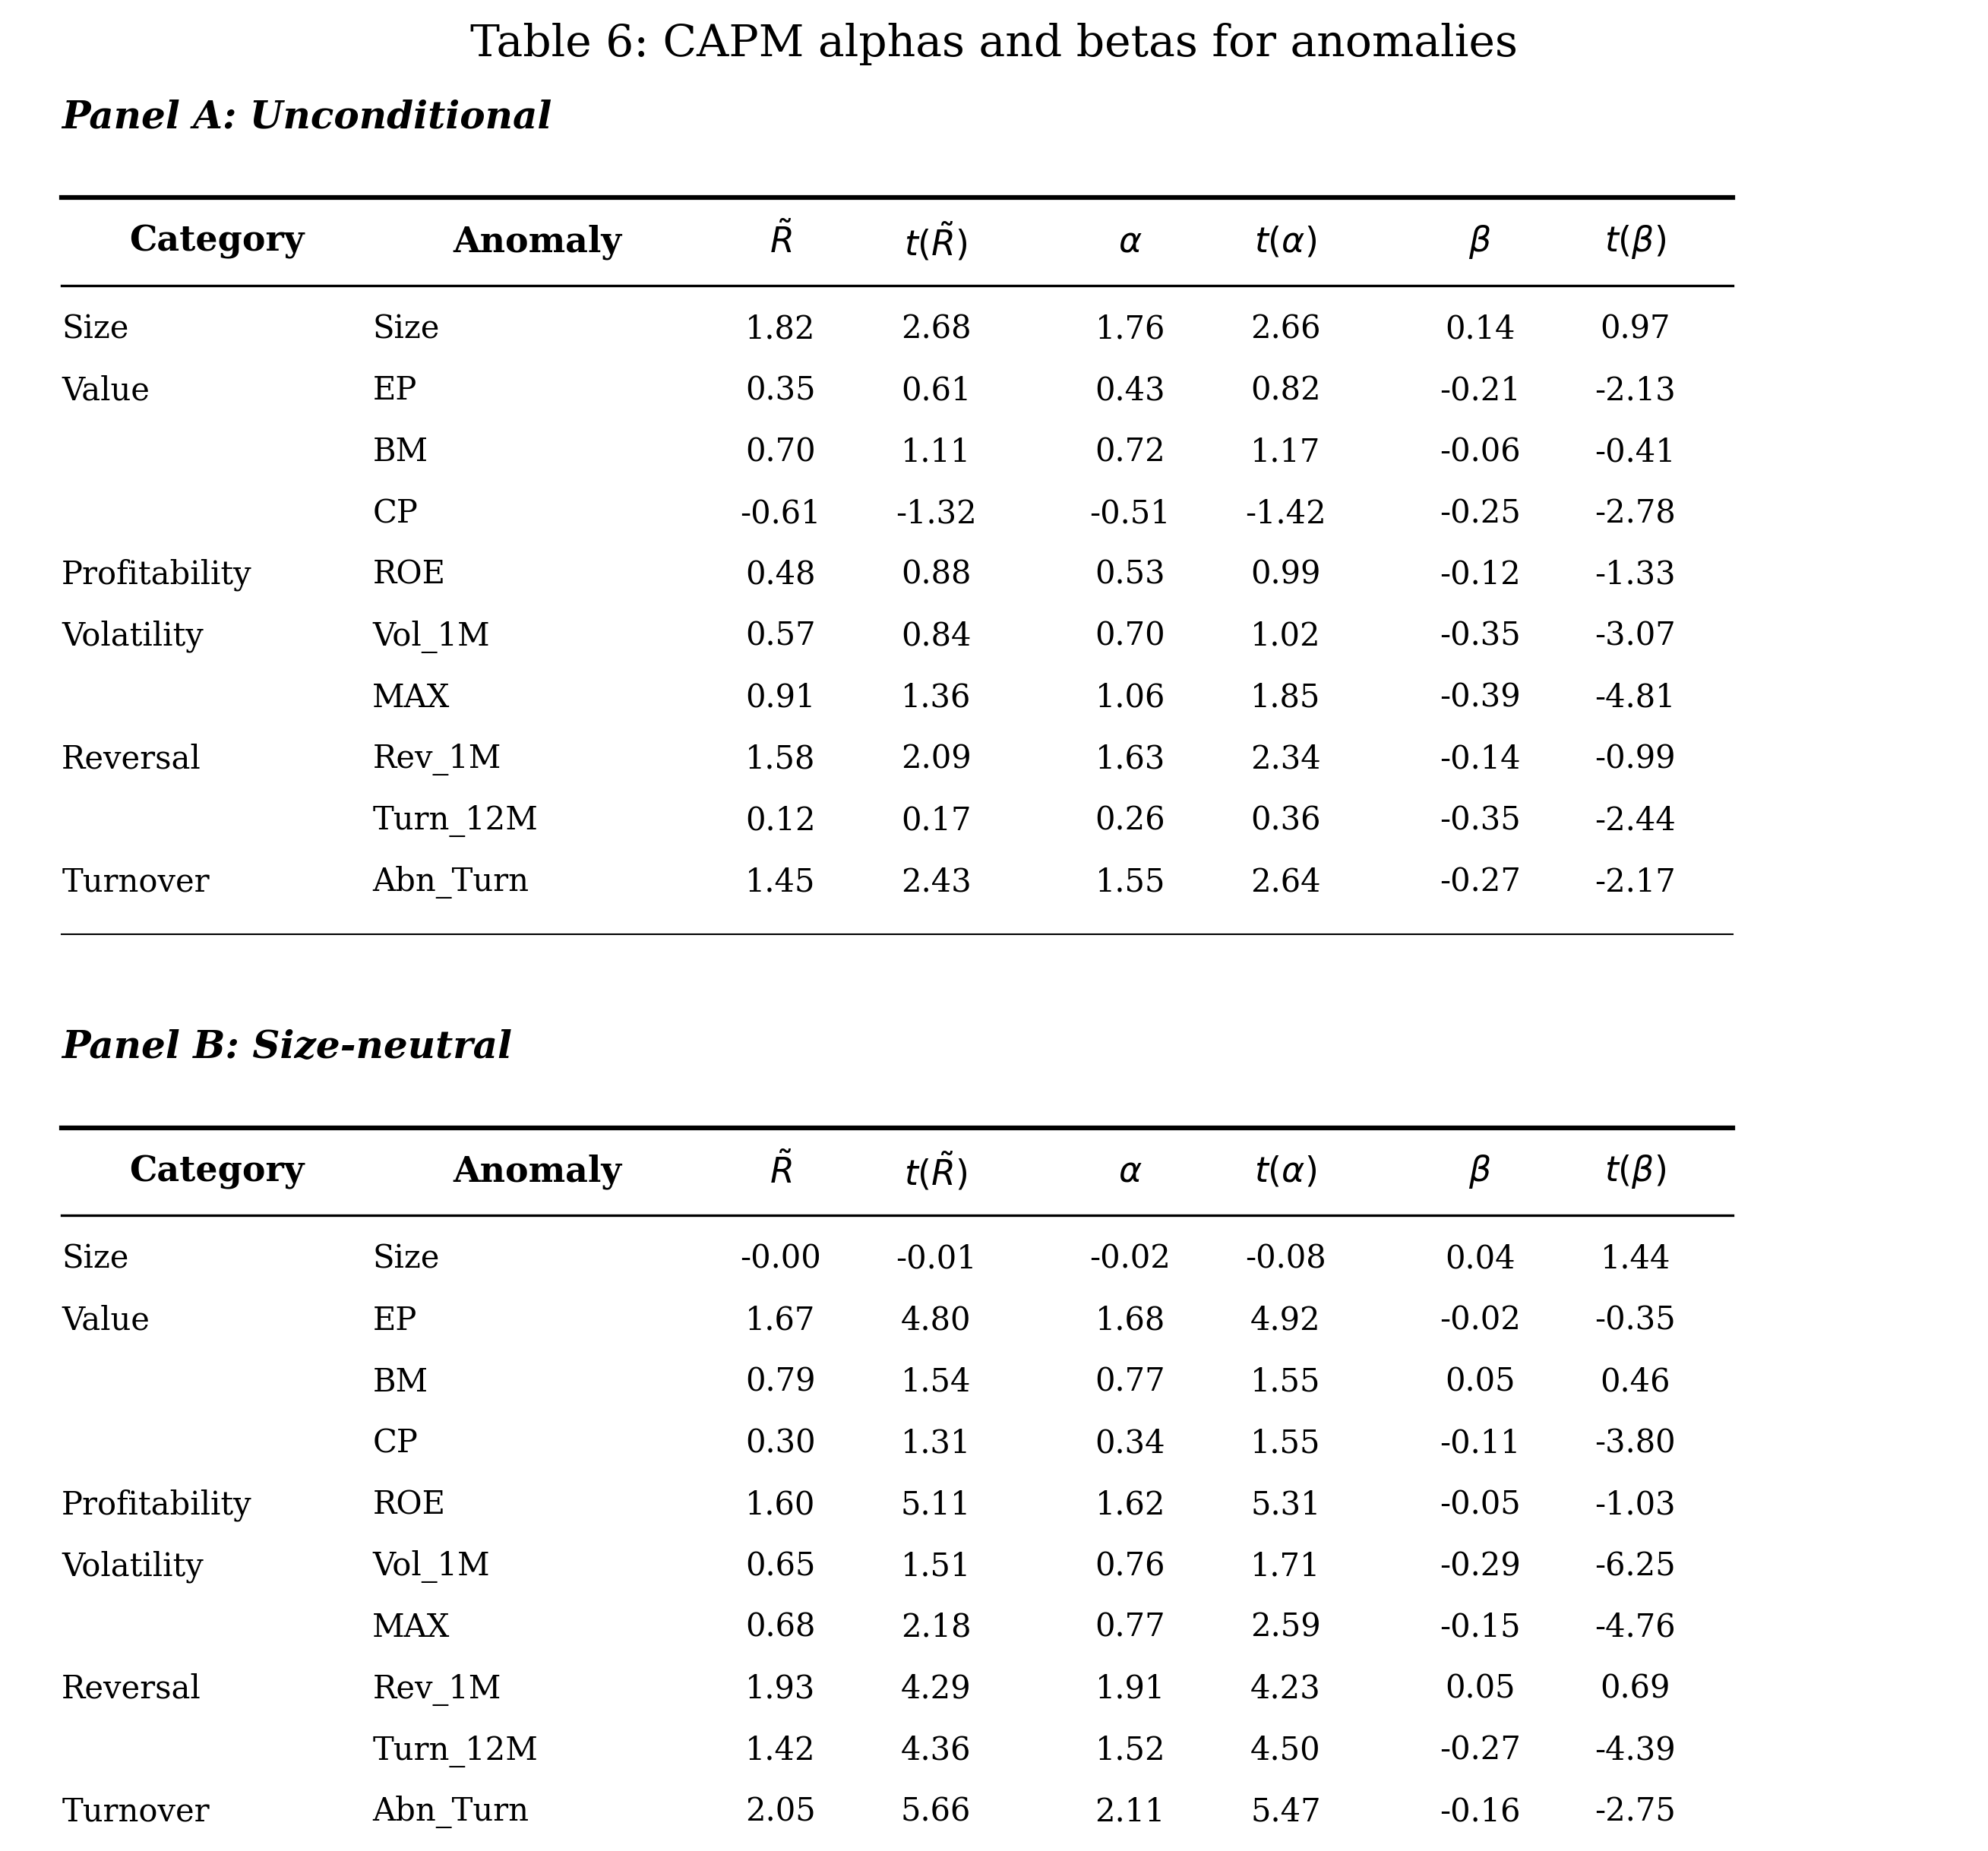

In [10]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
import os
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# ==============================================================================
# 0. 配置与检查
# ==============================================================================
# 请确认你的数据都已经准备好了 (full_data 和 mkt_df)
# 如果之前的 Step 1-3 跑完了，这里直接用内存中的 full_data
# 如果没有，请先运行上一段代码的 Step 1-3 生成 full_data

if 'full_data' not in locals():
    print("❌ 警告：未检测到 full_data 变量。")
    print("请务必先运行上一段代码的 Step 1, 2, 3，生成 full_data 后再运行此段代码！")
    # 为了防止报错停止，这里可以加一个简单的加载逻辑，或者提示用户
else:
    print("✅ 已检测到 full_data，开始计算 Table 6 全指标...")

# ==============================================================================
# 1. 准备市场因子 (MKT)
# ==============================================================================
# 我们需要确保 MKT 因子就位
base_data_dir = r"C:\Users\Pedro\PycharmProjects\pythonProject1\金融计量学\Replication_of_Liu_2019-main\data"
def load_csv(name):
    path = os.path.join(base_data_dir, name)
    if os.path.exists(path): return pd.read_csv(path, dtype={'Stkcd': str})
    return pd.read_csv(name, dtype={'Stkcd': str})

# 重新构建 MKT (以防万一)
rf = load_csv("BND_Exchange.csv")
rf['Clsdt'] = pd.to_datetime(rf['Clsdt'])
rf['Month'] = rf['Clsdt'] + MonthEnd(0)
rf['Nrrdaydt'] = pd.to_numeric(rf['Nrrdaydt'], errors='coerce') / 100
rf_mon = rf.groupby('Month')['Nrrdaydt'].apply(lambda x: np.prod(1+x)-1).reset_index(name='Rf')

# 使用加权平均计算市场收益
univ_ret = full_data.groupby('Trdmnt').apply(lambda x: np.average(x['Mretwd'], weights=x['Lag_Size'])).reset_index(name='MktRaw')
mkt_df = pd.merge(univ_ret, rf_mon, left_on='Trdmnt', right_on='Month')
mkt_df['MKT'] = mkt_df['MktRaw'] - mkt_df['Rf']
mkt_df.set_index('Trdmnt', inplace=True)

# ==============================================================================
# 2. 核心计算逻辑 (R, Alpha, Beta)
# ==============================================================================
results_list = []

# 异象列表
anomalies = {
    'Size': 'Lag_Size',
    'EP': 'EP', 'BM': 'BM', 'CP': 'CP', 'ROE': 'ROE',
    'Vol_1M': 'Vol_1M', 'MAX': 'MAX', 'Rev_1M': 'Rev_1M',
    'Turn_12M': 'Turn_12M', 'Abn_Turn': 'Abn_Turn'
}

# 方向定义
directions = {
    'Size': 'Low-High', 'EP': 'High-Low', 'BM': 'High-Low', 'CP': 'High-Low',
    'ROE': 'High-Low', 'Vol_1M': 'Low-High', 'MAX': 'Low-High',
    'Rev_1M': 'Low-High', 'Turn_12M': 'Low-High', 'Abn_Turn': 'Low-High'
}

# --- 辅助函数：Newey-West t值 ---
def get_nw_stats(y, x=None, lags=5):
    # 如果 x 为 None，计算均值的 t 值 (R tilde)
    if x is None:
        x = np.ones((len(y), 1))
        model = sm.OLS(y, x).fit(cov_type='HAC', cov_kwds={'maxlags': lags})
        return model.params[0], model.tvalues[0]
    else:
        # 回归 y = alpha + beta * x
        x = sm.add_constant(x)
        model = sm.OLS(y, x).fit(cov_type='HAC', cov_kwds={'maxlags': lags})
        return model.params, model.tvalues

# --- 循环计算 Panel A (Unconditional) 和 Panel B (Neutral) ---
# Unconditional Sort Helper
def get_spread_uncond(df, sort_col, direction):
    try:
        labels = range(1, 11)
        df['Rank'] = pd.qcut(df[sort_col], 10, labels=labels)
        port_ret = df.groupby('Rank').apply(lambda x: np.average(x['Mretwd'], weights=x['Lag_Size']))
        return (port_ret.loc[10] - port_ret.loc[1]) if direction == 'High-Low' else (port_ret.loc[1] - port_ret.loc[10])
    except: return np.nan

# Size-Neutral Sort Helper
def get_spread_neutral(df, sort_col, direction):
    try:
        df['SizeRank'] = pd.qcut(df['Lag_Size'], 10, labels=False)
        longs, shorts = [], []
        for s in range(10):
            sub = df[df['SizeRank'] == s]
            if len(sub) < 10: continue
            sub['AnomRank'] = pd.qcut(sub[sort_col], 10, labels=False)
            rets = sub.groupby('AnomRank').apply(lambda x: np.average(x['Mretwd'], weights=x['Lag_Size']))
            if 0 in rets and 9 in rets:
                shorts.append(rets[0]); longs.append(rets[9])
        if not longs: return np.nan
        high, low = np.mean(longs), np.mean(shorts)
        return (high - low) if direction == 'High-Low' else (low - high)
    except: return np.nan

print(">>> 开始计算所有指标 (R, Alpha, Beta)...")

for name, col in anomalies.items():
    # 1. Unconditional
    s_uncond = full_data.groupby('Trdmnt').apply(lambda x: get_spread_uncond(x, col, directions[name]))

    # 2. Size-Neutral
    s_neutral = full_data.groupby('Trdmnt').apply(lambda x: get_spread_neutral(x, col, directions[name]))

    for sort_type, spread_series in [('Panel A: Unconditional', s_uncond), ('Panel B: Size-neutral', s_neutral)]:
        # Size anomaly 在 Neutral sort 下无意义
        if name == 'Size' and 'Neutral' in sort_type: continue

        # 对齐数据
        reg_df = pd.concat([spread_series, mkt_df['MKT']], axis=1).dropna()
        reg_df.columns = ['Ret', 'MKT']

        if len(reg_df) < 50: continue

        # 1. 计算 R tilde (原始收益均值)
        r_mean, r_t = get_nw_stats(reg_df['Ret'])

        # 2. 计算 Alpha 和 Beta (CAPM)
        params, tvals = get_nw_stats(reg_df['Ret'], reg_df['MKT'])
        alpha, beta = params['const'], params['MKT']
        alpha_t, beta_t = tvals['const'], tvals['MKT']

        results_list.append({
            'Panel': sort_type,
            'Anomaly': name,
            'R_tilde': r_mean * 100,
            't_R': r_t,
            'Alpha': alpha * 100,
            't_Alpha': alpha_t,
            'Beta': beta,  # Beta 通常不乘 100
            't_Beta': beta_t
        })

# ==============================================================================
# 3. 整理结果与制表
# ==============================================================================
final_df = pd.DataFrame(results_list)

# 映射分类名称 (参考论文)
category_map = {
    'Size': 'Size',
    'EP': 'Value', 'BM': 'Value', 'CP': 'Value',
    'ROE': 'Profitability',
    'Vol_1M': 'Volatility', 'MAX': 'Volatility',
    'Rev_1M': 'Reversal', 'Turn_12M': 'Reversal', # 论文中有时把 Turn 放 Reversal
    'Abn_Turn': 'Turnover'
}
final_df['Category'] = final_df['Anomaly'].map(category_map)

# 打印预览
print("\n=== Table 6 Replication Data ===")
print(final_df.round(2))

# ==============================================================================
# 4. 终极绘图 (Paper Style)
# ==============================================================================
def draw_table6_full(df):
    fig, ax = plt.subplots(figsize=(11, 10), dpi=300)
    ax.axis('off')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    font = 'serif'

    # 布局参数
    y_top = 0.95
    row_h = 0.035
    panel_gap = 0.06

    # 列位置 (Category | Anomaly | R | t(R) | Alpha | t(Alpha) | Beta | t(Beta))
    cols_x = [0.02, 0.18, 0.35, 0.43, 0.53, 0.61, 0.71, 0.79]
    col_width = [0.16, 0.17, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08]

    # 绘制表头函数
    def draw_header(y):
        ax.plot([0.02, 0.88], [y, y], 'k-', lw=1.5)
        headers = ['Category', 'Anomaly', r'$\tilde{R}$', r'$t(\tilde{R})$',
                   r'$\alpha$', r'$t(\alpha)$', r'$\beta$', r'$t(\beta)$']
        for i, h in enumerate(headers):
            # 居中对齐
            ax.text(cols_x[i] + col_width[i]/2, y - 0.025, h,
                    ha='center', va='center', weight='bold', fontsize=11, family=font)
        ax.plot([0.02, 0.88], [y - 0.05, y - 0.05], 'k-', lw=0.8)
        return y - 0.08

    curr_y = y_top

    # --- Loop Panels ---
    panels = ['Panel A: Unconditional', 'Panel B: Size-neutral']

    for panel in panels:
        # Panel Title
        ax.text(0.02, curr_y, panel, ha='left', weight='bold', style='italic', fontsize=12, family=font)
        curr_y -= 0.04

        # Header
        curr_y = draw_header(curr_y)

        # Data
        sub = df[df['Panel'] == panel].copy()
        # 排序：按 Category 分组 (简单处理，按索引顺序)
        # 论文顺序: Size, EP, BM, CP, ROE, Vol, MAX, Rev, Turn, Abn
        order = ['Size', 'EP', 'BM', 'CP', 'ROE', 'Vol_1M', 'MAX', 'Rev_1M', 'Turn_12M', 'Abn_Turn']
        sub = sub.set_index('Anomaly').reindex(order).reset_index()
        sub = sub.dropna(subset=['Alpha']) # 去除 Size-neutral 中空的 Size

        prev_cat = ""

        for _, row in sub.iterrows():
            cat = category_map.get(row['Anomaly'], '')
            anom_name = row['Anomaly']

            # 显示 Category (只在第一次出现时显示)
            if cat != prev_cat:
                ax.text(cols_x[0], curr_y, cat, ha='left', fontsize=10, family=font)
                prev_cat = cat

            ax.text(cols_x[1], curr_y, anom_name, ha='left', fontsize=10, family=font)

            # 数值列
            vals = [row['R_tilde'], row['t_R'], row['Alpha'], row['t_Alpha'], row['Beta'], row['t_Beta']]

            for i, val in enumerate(vals):
                fmt = "{:.2f}"
                # 简单对齐
                ax.text(cols_x[i+2] + col_width[i+2]/2, curr_y, fmt.format(val),
                        ha='center', fontsize=10, family=font)

            curr_y -= row_h

        # Panel 底部线
        ax.plot([0.02, 0.88], [curr_y + 0.01, curr_y + 0.01], 'k-', lw=1.5 if panel == panels[-1] else 0.5)
        curr_y -= panel_gap

    plt.title("Table 6: CAPM alphas and betas for anomalies", y=0.98, fontsize=14, family=font)
    plt.show()

draw_table6_full(final_df)

table 7

>>> [Table 7] 准备数据...
✅ 已加载异象面板数据 (full_data)
>>> [Step 1] 计算 10 个异象的多空对冲收益序列...


C:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:4657: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
C:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:4657: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
C:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:4657: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
C:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:4657: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
C:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:

异象收益序列计算完成。
>>> [Step 2] 运行 CH-3 回归模型...

=== Table 7 Replication: CH-3 Alphas ===
                           Panel   Anomaly  Alpha  t_Alpha  t_SMB  t_VMG
0   Panel A: Unconditional sorts      Size   0.63     2.48  21.03  -8.13
1   Panel A: Unconditional sorts        EP   0.57     1.46  -4.83   5.53
2   Panel A: Unconditional sorts        BM  -0.09    -0.12  -1.32   4.98
3   Panel A: Unconditional sorts        CP  -0.64    -1.39  -1.56   2.04
4   Panel A: Unconditional sorts       ROE   0.47     0.85  -3.03   4.87
5   Panel A: Unconditional sorts    Vol_1M   0.51     0.55  -1.62   2.54
6   Panel A: Unconditional sorts       MAX   1.06     1.61  -1.45   1.79
7   Panel A: Unconditional sorts    Rev_1M   0.65     0.75   1.76   0.62
8   Panel A: Unconditional sorts  Turn_12M   0.78     1.82  -7.43   7.18
9   Panel A: Unconditional sorts  Abn_Turn   2.01     2.33  -0.01  -1.32
10   Panel B: Size-neutral sorts        EP   0.73     2.46   1.46   8.22
11   Panel B: Size-neutral sorts        B

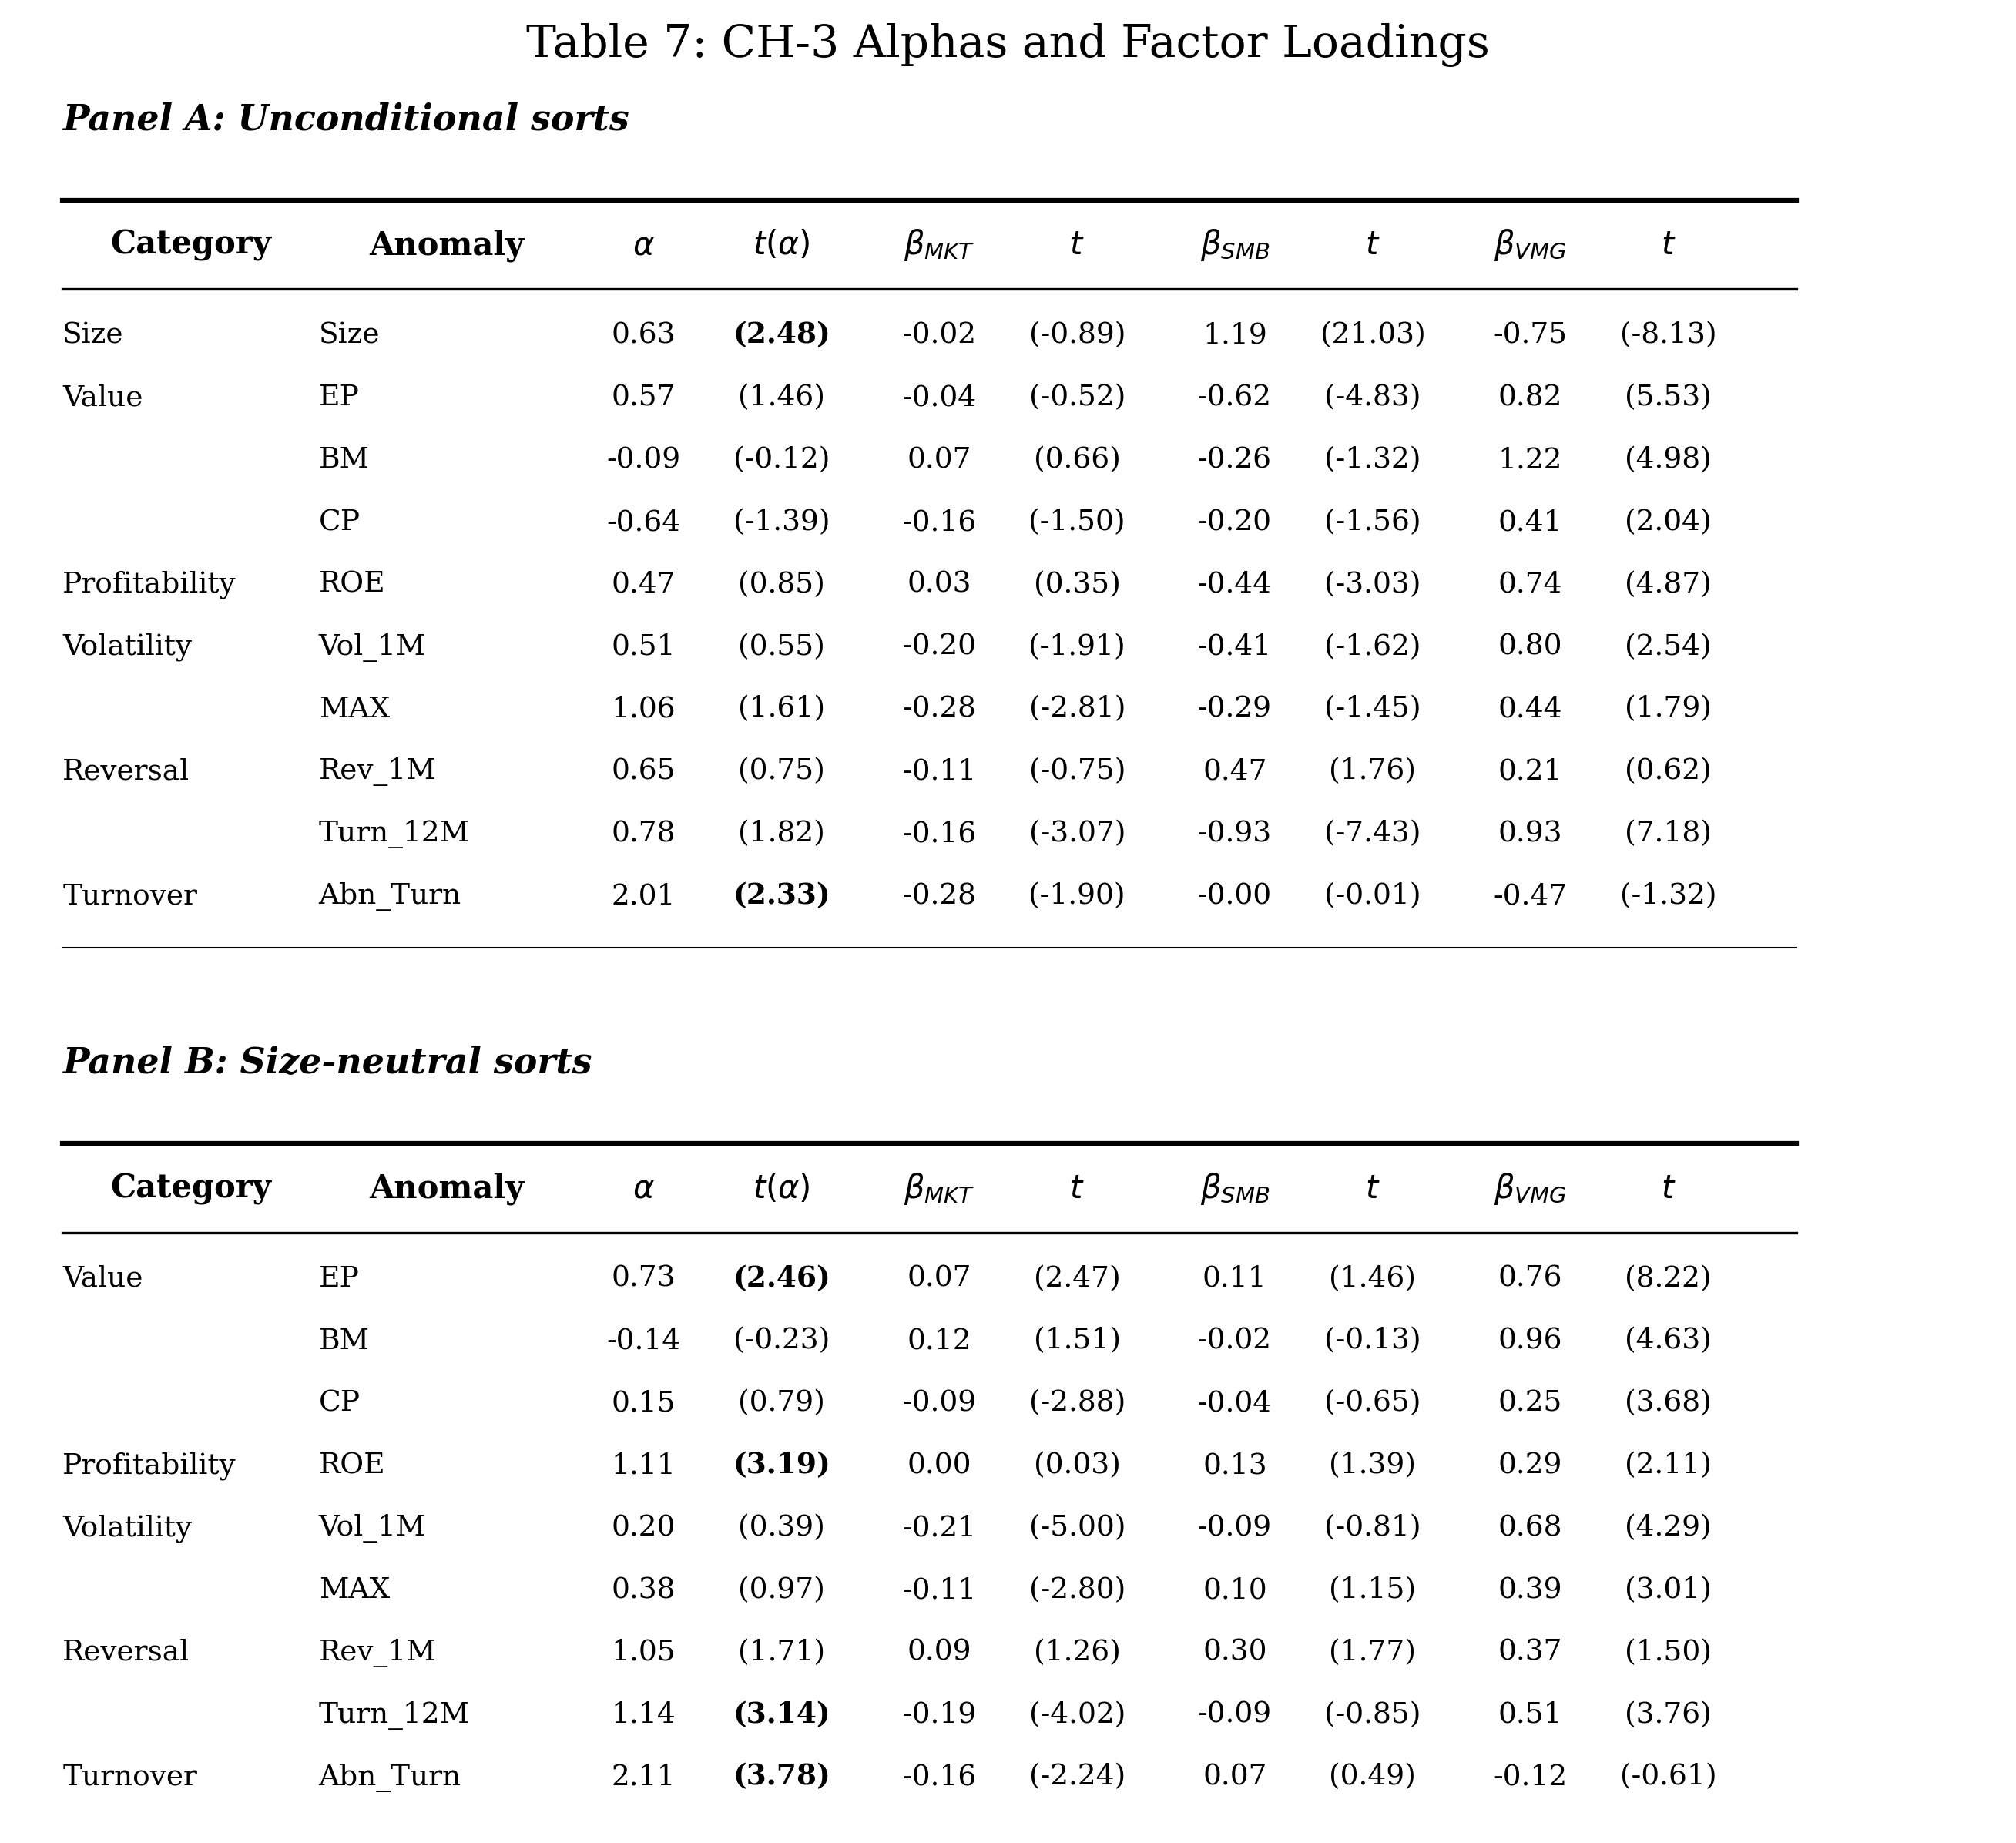

In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# ==============================================================================
# 0. 数据检查与准备
# ==============================================================================
print(">>> [Table 7] 准备数据...")

# 1. 检查异象数据 full_data
if 'full_data' not in locals():
    print("❌ 错误：内存中未找到 'full_data'。请务必先运行 Table 6 的代码！")
else:
    print("✅ 已加载异象面板数据 (full_data)")

# 2. 准备 CH-3 因子 (MKT, SMB, VMG)
# 如果之前运行过 Table 3 或 5，应该有 'ch3_factors' 或 'factors' 变量
if 'ch3_factors' in locals():
    model_factors = ch3_factors[['MKT', 'SMB', 'VMG']].copy()
elif 'factors' in locals() and 'SMB' in factors.columns:
    model_factors = factors[['MKT', 'SMB', 'VMG']].copy()
else:
    # 尝试重新读取 (如果你保存过) 或报错
    # 这里假设你刚刚跑完 Table 5，内存里肯定有
    print("⚠️ 警告：未找到现成因子变量，尝试从 Table 5 结果中提取...")
    # 这里是一个占位，实际运行需确保因子在内存
    raise ValueError("请先运行 Table 3 或 Table 5 的代码以生成 CH-3 因子！")

# 确保索引是时间类型
model_factors.index = pd.to_datetime(model_factors.index)

# ==============================================================================
# 1. 批量计算所有异象的月度收益序列 (Time-Series)
# ==============================================================================
print(">>> [Step 1] 计算 10 个异象的多空对冲收益序列...")

anomalies_list = {
    'Size': 'Lag_Size',
    'EP': 'EP', 'BM': 'BM', 'CP': 'CP', 'ROE': 'ROE',
    'Vol_1M': 'Vol_1M', 'MAX': 'MAX', 'Rev_1M': 'Rev_1M',
    'Turn_12M': 'Turn_12M', 'Abn_Turn': 'Abn_Turn'
}

directions = {
    'Size': 'Low-High', 'EP': 'High-Low', 'BM': 'High-Low', 'CP': 'High-Low',
    'ROE': 'High-Low', 'Vol_1M': 'Low-High', 'MAX': 'Low-High',
    'Rev_1M': 'Low-High', 'Turn_12M': 'Low-High', 'Abn_Turn': 'Low-High'
}

# 存储所有收益序列
anomaly_ret_dict = {'Uncond': {}, 'Neutral': {}}

# --- Unconditional Sort ---
def calc_spread_uncond(df, col, direction):
    try:
        # 分 10 组
        df['Rank'] = pd.qcut(df[col], 10, labels=False)
        # 计算加权收益
        rets = df.groupby('Rank').apply(lambda x: np.average(x['Mretwd'], weights=x['Lag_Size']))
        # 多空收益
        spread = (rets[9] - rets[0]) if direction == 'High-Low' else (rets[0] - rets[9])
        return spread
    except: return np.nan

# --- Size-Neutral Sort ---
def calc_spread_neutral(df, col, direction):
    try:
        # 1. 先按 Size 分 10 组
        df['SizeRank'] = pd.qcut(df['Lag_Size'], 10, labels=False)
        longs, shorts = [], []

        for s in range(10):
            sub = df[df['SizeRank'] == s]
            if len(sub) < 5: continue

            # 2. 组内按 Anomaly 分 10 组
            sub['AnomRank'] = pd.qcut(sub[col], 10, labels=False, duplicates='drop')
            rets = sub.groupby('AnomRank').apply(lambda x: np.average(x['Mretwd'], weights=x['Lag_Size']))

            # 获取两端
            if 0 in rets and rets.index.max() == 9: # 确保有头有尾
                shorts.append(rets[0])
                longs.append(rets[rets.index.max()]) # 取最大组号，防止不满10组

        if not longs: return np.nan

        # 简单平均各 Size 组的结果
        high = np.mean(longs)
        low = np.mean(shorts)

        return (high - low) if direction == 'High-Low' else (low - high)
    except: return np.nan

# 执行计算
for name, col in anomalies_list.items():
    # 1. Unconditional
    ts_uncond = full_data.groupby('Trdmnt').apply(lambda x: calc_spread_uncond(x, col, directions[name]))
    anomaly_ret_dict['Uncond'][name] = ts_uncond

    # 2. Size-Neutral (Size 异象本身不做 Neutral)
    if name != 'Size':
        ts_neutral = full_data.groupby('Trdmnt').apply(lambda x: calc_spread_neutral(x, col, directions[name]))
        anomaly_ret_dict['Neutral'][name] = ts_neutral

print("异象收益序列计算完成。")

# ==============================================================================
# 2. 运行 CH-3 回归 (Table 7)
# ==============================================================================
print(">>> [Step 2] 运行 CH-3 回归模型...")

results_table = []

# 对齐数据
# 因子收益通常是百分比 (如 1.05)，异象收益算出的是小数 (如 0.0105)，需要统一
# 我们统一转为百分比
model_factors_pct = model_factors.copy()
# 检查因子量级，如果已经是百分比(>0.2通常是)就不乘，否则乘100
if model_factors_pct['MKT'].abs().mean() < 0.5:
    model_factors_pct *= 100

for sort_type in ['Uncond', 'Neutral']:
    panel_name = 'Panel A: Unconditional sorts' if sort_type == 'Uncond' else 'Panel B: Size-neutral sorts'

    anom_dict = anomaly_ret_dict[sort_type]

    # 排序：Size, EP, BM, CP, ROE, Vol, MAX, Rev, Turn, Abn
    order_keys = ['Size', 'EP', 'BM', 'CP', 'ROE', 'Vol_1M', 'MAX', 'Rev_1M', 'Turn_12M', 'Abn_Turn']
    if sort_type == 'Neutral': order_keys.remove('Size')

    for anom_name in order_keys:
        if anom_name not in anom_dict: continue

        # 准备 Y
        y_series = anom_dict[anom_name] * 100 # 转百分比

        # 合并 Y 和 X
        reg_df = pd.merge(y_series.rename('Ret'), model_factors_pct, left_index=True, right_index=True).dropna()

        if len(reg_df) < 50: continue

        # 回归: Ret = alpha + b*MKT + s*SMB + v*VMG
        X = sm.add_constant(reg_df[['MKT', 'SMB', 'VMG']])
        Y = reg_df['Ret']

        model = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 5})

        results_table.append({
            'Panel': panel_name,
            'Anomaly': anom_name,
            'Alpha': model.params['const'],
            't_Alpha': model.tvalues['const'],
            'b_MKT': model.params['MKT'],
            't_MKT': model.tvalues['MKT'],
            'b_SMB': model.params['SMB'],
            't_SMB': model.tvalues['SMB'],
            'b_VMG': model.params['VMG'],
            't_VMG': model.tvalues['VMG']
        })

# ==============================================================================
# 3. 输出与绘图
# ==============================================================================
final_df = pd.DataFrame(results_table)

# 映射分类名称
cat_map = {
    'Size': 'Size', 'EP': 'Value', 'BM': 'Value', 'CP': 'Value', 'ROE': 'Profitability',
    'Vol_1M': 'Volatility', 'MAX': 'Volatility', 'Rev_1M': 'Reversal',
    'Turn_12M': 'Reversal', 'Abn_Turn': 'Turnover'
}
final_df['Category'] = final_df['Anomaly'].map(cat_map)

print("\n=== Table 7 Replication: CH-3 Alphas ===")
# 简单打印
cols_print = ['Panel', 'Anomaly', 'Alpha', 't_Alpha', 't_SMB', 't_VMG']
print(final_df[cols_print].round(2))

# --- 终极绘图 ---
def draw_table7_paper(df):
    fig, ax = plt.subplots(figsize=(11, 10), dpi=300)
    ax.axis('off')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    font = 'serif'

    # 布局
    y_top = 0.95
    row_h = 0.035
    panel_gap = 0.06

    # 列配置
    # Category | Anomaly | Alpha | t(a) | b_MKT | t | b_SMB | t | b_VMG | t
    cols_x = [0.02, 0.15, 0.28, 0.35, 0.43, 0.50, 0.58, 0.65, 0.73, 0.80]
    col_w  = [0.13, 0.13, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07]

    # 绘制表头
    def draw_header(y):
        ax.plot([0.02, 0.90], [y, y], 'k-', lw=1.5)
        headers = ['Category', 'Anomaly', r'$\alpha$', r'$t(\alpha)$',
                   r'$\beta_{MKT}$', r'$t$', r'$\beta_{SMB}$', r'$t$', r'$\beta_{VMG}$', r'$t$']
        for i, h in enumerate(headers):
            ax.text(cols_x[i] + col_w[i]/2, y - 0.025, h,
                    ha='center', va='center', weight='bold', fontsize=10, family=font)
        ax.plot([0.02, 0.90], [y - 0.05, y - 0.05], 'k-', lw=0.8)
        return y - 0.08

    curr_y = y_top

    panels = ['Panel A: Unconditional sorts', 'Panel B: Size-neutral sorts']

    for panel in panels:
        # Title
        ax.text(0.02, curr_y, panel, ha='left', weight='bold', style='italic', fontsize=11, family=font)
        curr_y -= 0.04
        curr_y = draw_header(curr_y)

        # Data
        sub = df[df['Panel'] == panel].copy()
        prev_cat = ""

        for _, row in sub.iterrows():
            cat = row['Category']
            anom = row['Anomaly']

            # Category
            if cat != prev_cat:
                ax.text(cols_x[0], curr_y, cat, ha='left', fontsize=9, family=font)
                prev_cat = cat

            # Anomaly
            ax.text(cols_x[1], curr_y, anom, ha='left', fontsize=9, family=font)

            # Values
            vals = [
                row['Alpha'], row['t_Alpha'],
                row['b_MKT'], row['t_MKT'],
                row['b_SMB'], row['t_SMB'],
                row['b_VMG'], row['t_VMG']
            ]

            for i, v in enumerate(vals):
                # t-stat 加括号
                if i % 2 == 1: fmt = "({:.2f})"
                else: fmt = "{:.2f}"

                # 高亮显著的 Alpha (可选)
                weight = 'bold' if i == 1 and abs(v) > 1.96 else 'normal'

                ax.text(cols_x[i+2] + col_w[i+2]/2, curr_y, fmt.format(v),
                        ha='center', fontsize=9, family=font, weight=weight)

            curr_y -= row_h

        ax.plot([0.02, 0.90], [curr_y + 0.01, curr_y + 0.01], 'k-', lw=1.5 if panel == panels[-1] else 0.5)
        curr_y -= panel_gap

    plt.title("Table 7: CH-3 Alphas and Factor Loadings", y=0.98, fontsize=14, family=font)
    plt.show()

draw_table7_paper(final_df)

table 8

>>> [Table 8] 运行 FF-3 回归模型...

=== Table 8 Replication: FF-3 Alphas ===
                           Panel   Anomaly  Alpha  t_Alpha  s_FFSMB  h_FFHML
0   Panel A: Unconditional sorts      Size   0.18     0.70     1.25    -0.28
1   Panel A: Unconditional sorts        EP   1.87     4.39    -1.03    -0.12
2   Panel A: Unconditional sorts        BM   0.29     1.00    -0.09     1.29
3   Panel A: Unconditional sorts        CP   0.11     0.25    -0.44    -0.08
4   Panel A: Unconditional sorts       ROE   1.89     3.90    -0.88    -0.23
5   Panel A: Unconditional sorts    Vol_1M   1.25     1.82    -0.54     0.39
6   Panel A: Unconditional sorts       MAX   1.65     2.67    -0.47     0.05
7   Panel A: Unconditional sorts    Rev_1M   1.33     1.93     0.24    -0.07
8   Panel A: Unconditional sorts  Turn_12M   1.62     3.75    -1.10     0.30
9   Panel A: Unconditional sorts  Abn_Turn   1.89     2.30    -0.10    -0.52
10   Panel B: Size-neutral sorts        EP   1.86     5.15    -0.18     0.17
11  

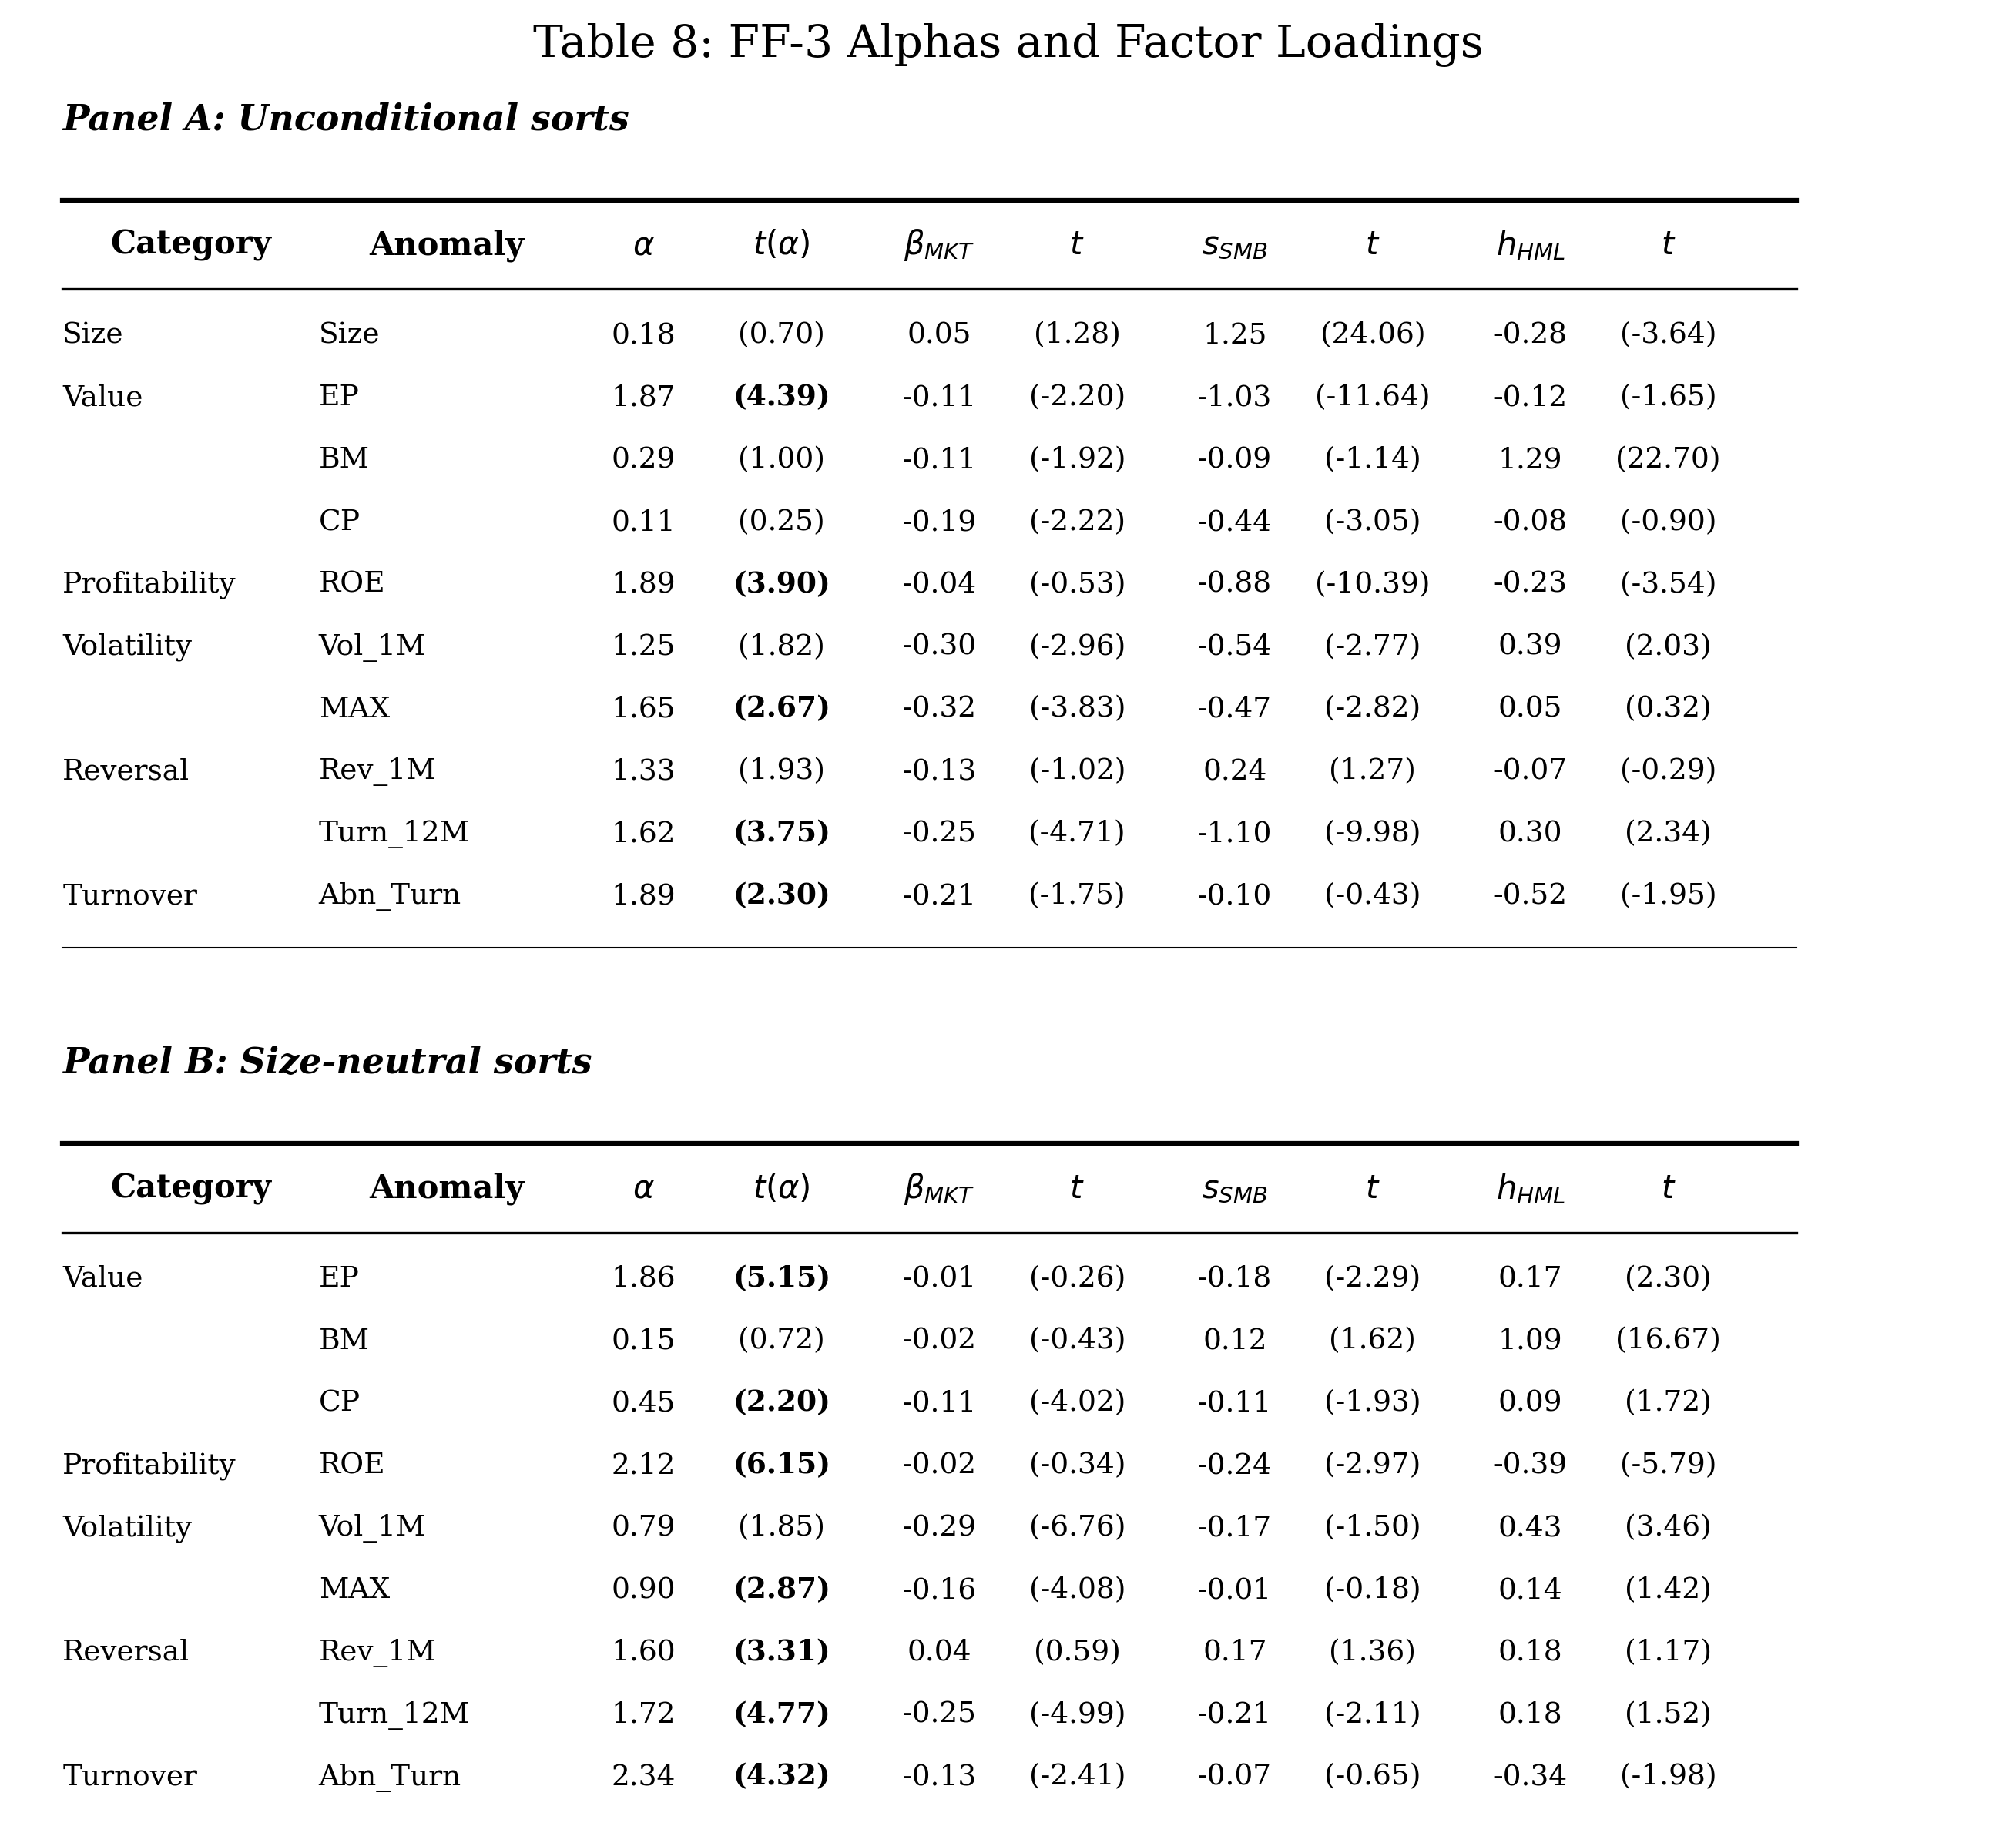

In [12]:
# ==============================================================================
# Table 8: FF-3 Alphas and Factor Loadings
# ==============================================================================
print(">>> [Table 8] 运行 FF-3 回归模型...")

# 1. 准备 FF-3 因子
# 需要从之前 Table 5 生成的 factors 变量中提取
# 必须包含: MKT, FFSMB, FFHML
if 'factors' in locals() and 'FFSMB' in factors.columns:
    ff3_factors = factors[['MKT', 'FFSMB', 'FFHML']].copy()
    # 确保单位是百分比 (跟 Table 7 保持一致)
    if ff3_factors['MKT'].abs().mean() < 0.5:
        ff3_factors *= 100
else:
    print("❌ 错误：内存中未找到 FF-3 因子 (FFSMB, FFHML)。")
    print("请确保你之前运行过 Table 5 的代码，并且没有重启内核。")
    # 如果找不到，这里会报错停止
    raise ValueError("Missing FF-3 Factors")

# 2. 准备异象收益序列 (复用 Table 7 算好的 anomaly_ret_dict)
if 'anomaly_ret_dict' not in locals():
    print("⚠️ 未找到异象收益序列，正在重新计算...")
    # (这里省略重新计算的代码，复用 Table 7 的逻辑，通常内存里会有)
    # 如果确实没有，请重新运行 Table 7 的 Step 1 部分
    raise ValueError("请先运行 Table 7 代码以生成 anomaly_ret_dict")

# 3. 运行回归
results_table_ff3 = []

for sort_type in ['Uncond', 'Neutral']:
    panel_name = 'Panel A: Unconditional sorts' if sort_type == 'Uncond' else 'Panel B: Size-neutral sorts'

    anom_dict = anomaly_ret_dict[sort_type]

    # 排序
    order_keys = ['Size', 'EP', 'BM', 'CP', 'ROE', 'Vol_1M', 'MAX', 'Rev_1M', 'Turn_12M', 'Abn_Turn']
    if sort_type == 'Neutral': order_keys.remove('Size')

    for anom_name in order_keys:
        if anom_name not in anom_dict: continue

        # 准备 Y (异象收益)
        y_series = anom_dict[anom_name] * 100

        # 合并 X (FF-3 因子)
        reg_df = pd.merge(y_series.rename('Ret'), ff3_factors, left_index=True, right_index=True).dropna()

        if len(reg_df) < 50: continue

        # 回归: Ret = alpha + b*MKT + s*FFSMB + h*FFHML
        X = sm.add_constant(reg_df[['MKT', 'FFSMB', 'FFHML']])
        Y = reg_df['Ret']

        model = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 5})

        results_table_ff3.append({
            'Panel': panel_name,
            'Anomaly': anom_name,
            'Alpha': model.params['const'],
            't_Alpha': model.tvalues['const'],
            'b_MKT': model.params['MKT'],
            't_MKT': model.tvalues['MKT'],
            's_FFSMB': model.params['FFSMB'],
            't_FFSMB': model.tvalues['FFSMB'],
            'h_FFHML': model.params['FFHML'],
            't_FFHML': model.tvalues['FFHML']
        })

# 4. 输出与绘图
final_df_ff3 = pd.DataFrame(results_table_ff3)
cat_map = {
    'Size': 'Size', 'EP': 'Value', 'BM': 'Value', 'CP': 'Value', 'ROE': 'Profitability',
    'Vol_1M': 'Volatility', 'MAX': 'Volatility', 'Rev_1M': 'Reversal',
    'Turn_12M': 'Reversal', 'Abn_Turn': 'Turnover'
}
final_df_ff3['Category'] = final_df_ff3['Anomaly'].map(cat_map)

print("\n=== Table 8 Replication: FF-3 Alphas ===")
cols_print = ['Panel', 'Anomaly', 'Alpha', 't_Alpha', 's_FFSMB', 'h_FFHML']
print(final_df_ff3[cols_print].round(2))

# --- 绘图函数 (适配 FF-3 列名) ---
def draw_table8_paper(df):
    fig, ax = plt.subplots(figsize=(11, 10), dpi=300)
    ax.axis('off')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    font = 'serif'
    y_top = 0.95
    row_h = 0.035
    panel_gap = 0.06

    # Category | Anomaly | Alpha | t(a) | b_MKT | t | s_SMB | t | h_HML | t
    cols_x = [0.02, 0.15, 0.28, 0.35, 0.43, 0.50, 0.58, 0.65, 0.73, 0.80]
    col_w  = [0.13, 0.13, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07]

    def draw_header(y):
        ax.plot([0.02, 0.90], [y, y], 'k-', lw=1.5)
        # 注意：这里是 FF-3 的因子符号
        headers = ['Category', 'Anomaly', r'$\alpha$', r'$t(\alpha)$',
                   r'$\beta_{MKT}$', r'$t$', r'$s_{SMB}$', r'$t$', r'$h_{HML}$', r'$t$']
        for i, h in enumerate(headers):
            ax.text(cols_x[i] + col_w[i]/2, y - 0.025, h,
                    ha='center', va='center', weight='bold', fontsize=10, family=font)
        ax.plot([0.02, 0.90], [y - 0.05, y - 0.05], 'k-', lw=0.8)
        return y - 0.08

    curr_y = y_top
    panels = ['Panel A: Unconditional sorts', 'Panel B: Size-neutral sorts']

    for panel in panels:
        ax.text(0.02, curr_y, panel, ha='left', weight='bold', style='italic', fontsize=11, family=font)
        curr_y -= 0.04
        curr_y = draw_header(curr_y)

        sub = df[df['Panel'] == panel].copy()
        prev_cat = ""

        for _, row in sub.iterrows():
            cat = row['Category']
            if cat != prev_cat:
                ax.text(cols_x[0], curr_y, cat, ha='left', fontsize=9, family=font)
                prev_cat = cat

            ax.text(cols_x[1], curr_y, row['Anomaly'], ha='left', fontsize=9, family=font)

            vals = [
                row['Alpha'], row['t_Alpha'],
                row['b_MKT'], row['t_MKT'],
                row['s_FFSMB'], row['t_FFSMB'],
                row['h_FFHML'], row['t_FFHML']
            ]

            for i, v in enumerate(vals):
                fmt = "({:.2f})" if i % 2 == 1 else "{:.2f}"
                # 高亮 Alpha
                weight = 'bold' if i == 1 and abs(v) > 1.96 else 'normal'
                ax.text(cols_x[i+2] + col_w[i+2]/2, curr_y, fmt.format(v),
                        ha='center', fontsize=9, family=font, weight=weight)

            curr_y -= row_h
        ax.plot([0.02, 0.90], [curr_y + 0.01, curr_y + 0.01], 'k-', lw=1.5 if panel == panels[-1] else 0.5)
        curr_y -= panel_gap

    plt.title("Table 8: FF-3 Alphas and Factor Loadings", y=0.98, fontsize=14, family=font)
    plt.show()

draw_table8_paper(final_df_ff3)

table 9

>>> [Table 9] 准备模型对比数据...
>>> [Step 1] 计算 Table 9 统计量...

=== Table 9 Replication Result ===
                          Panel       Model  Avg |Alpha|  Avg |t|  GRS F  \
0  Panel A: Unconditional sorts  Unadjusted        0.868    1.326  5.843   
1  Panel A: Unconditional sorts        CAPM        0.929    1.505  6.107   
2  Panel A: Unconditional sorts        FF-3        1.237    2.288  5.190   
3  Panel A: Unconditional sorts        CH-3        0.752    1.321  3.048   
4   Panel B: Size-neutral sorts  Unadjusted        1.255    3.506  8.685   
5   Panel B: Size-neutral sorts        CAPM        1.294    3.602  8.686   
6   Panel B: Size-neutral sorts        FF-3        1.325    3.482 10.590   
7   Panel B: Size-neutral sorts        CH-3        0.778    1.852  5.023   

   p(10)  p(7)  
0  0.000 0.019  
1  0.000 0.018  
2  0.000 0.000  
3  0.002 0.007  
4  0.000 0.000  
5  0.000 0.000  
6  0.000 0.000  
7  0.000 0.000  


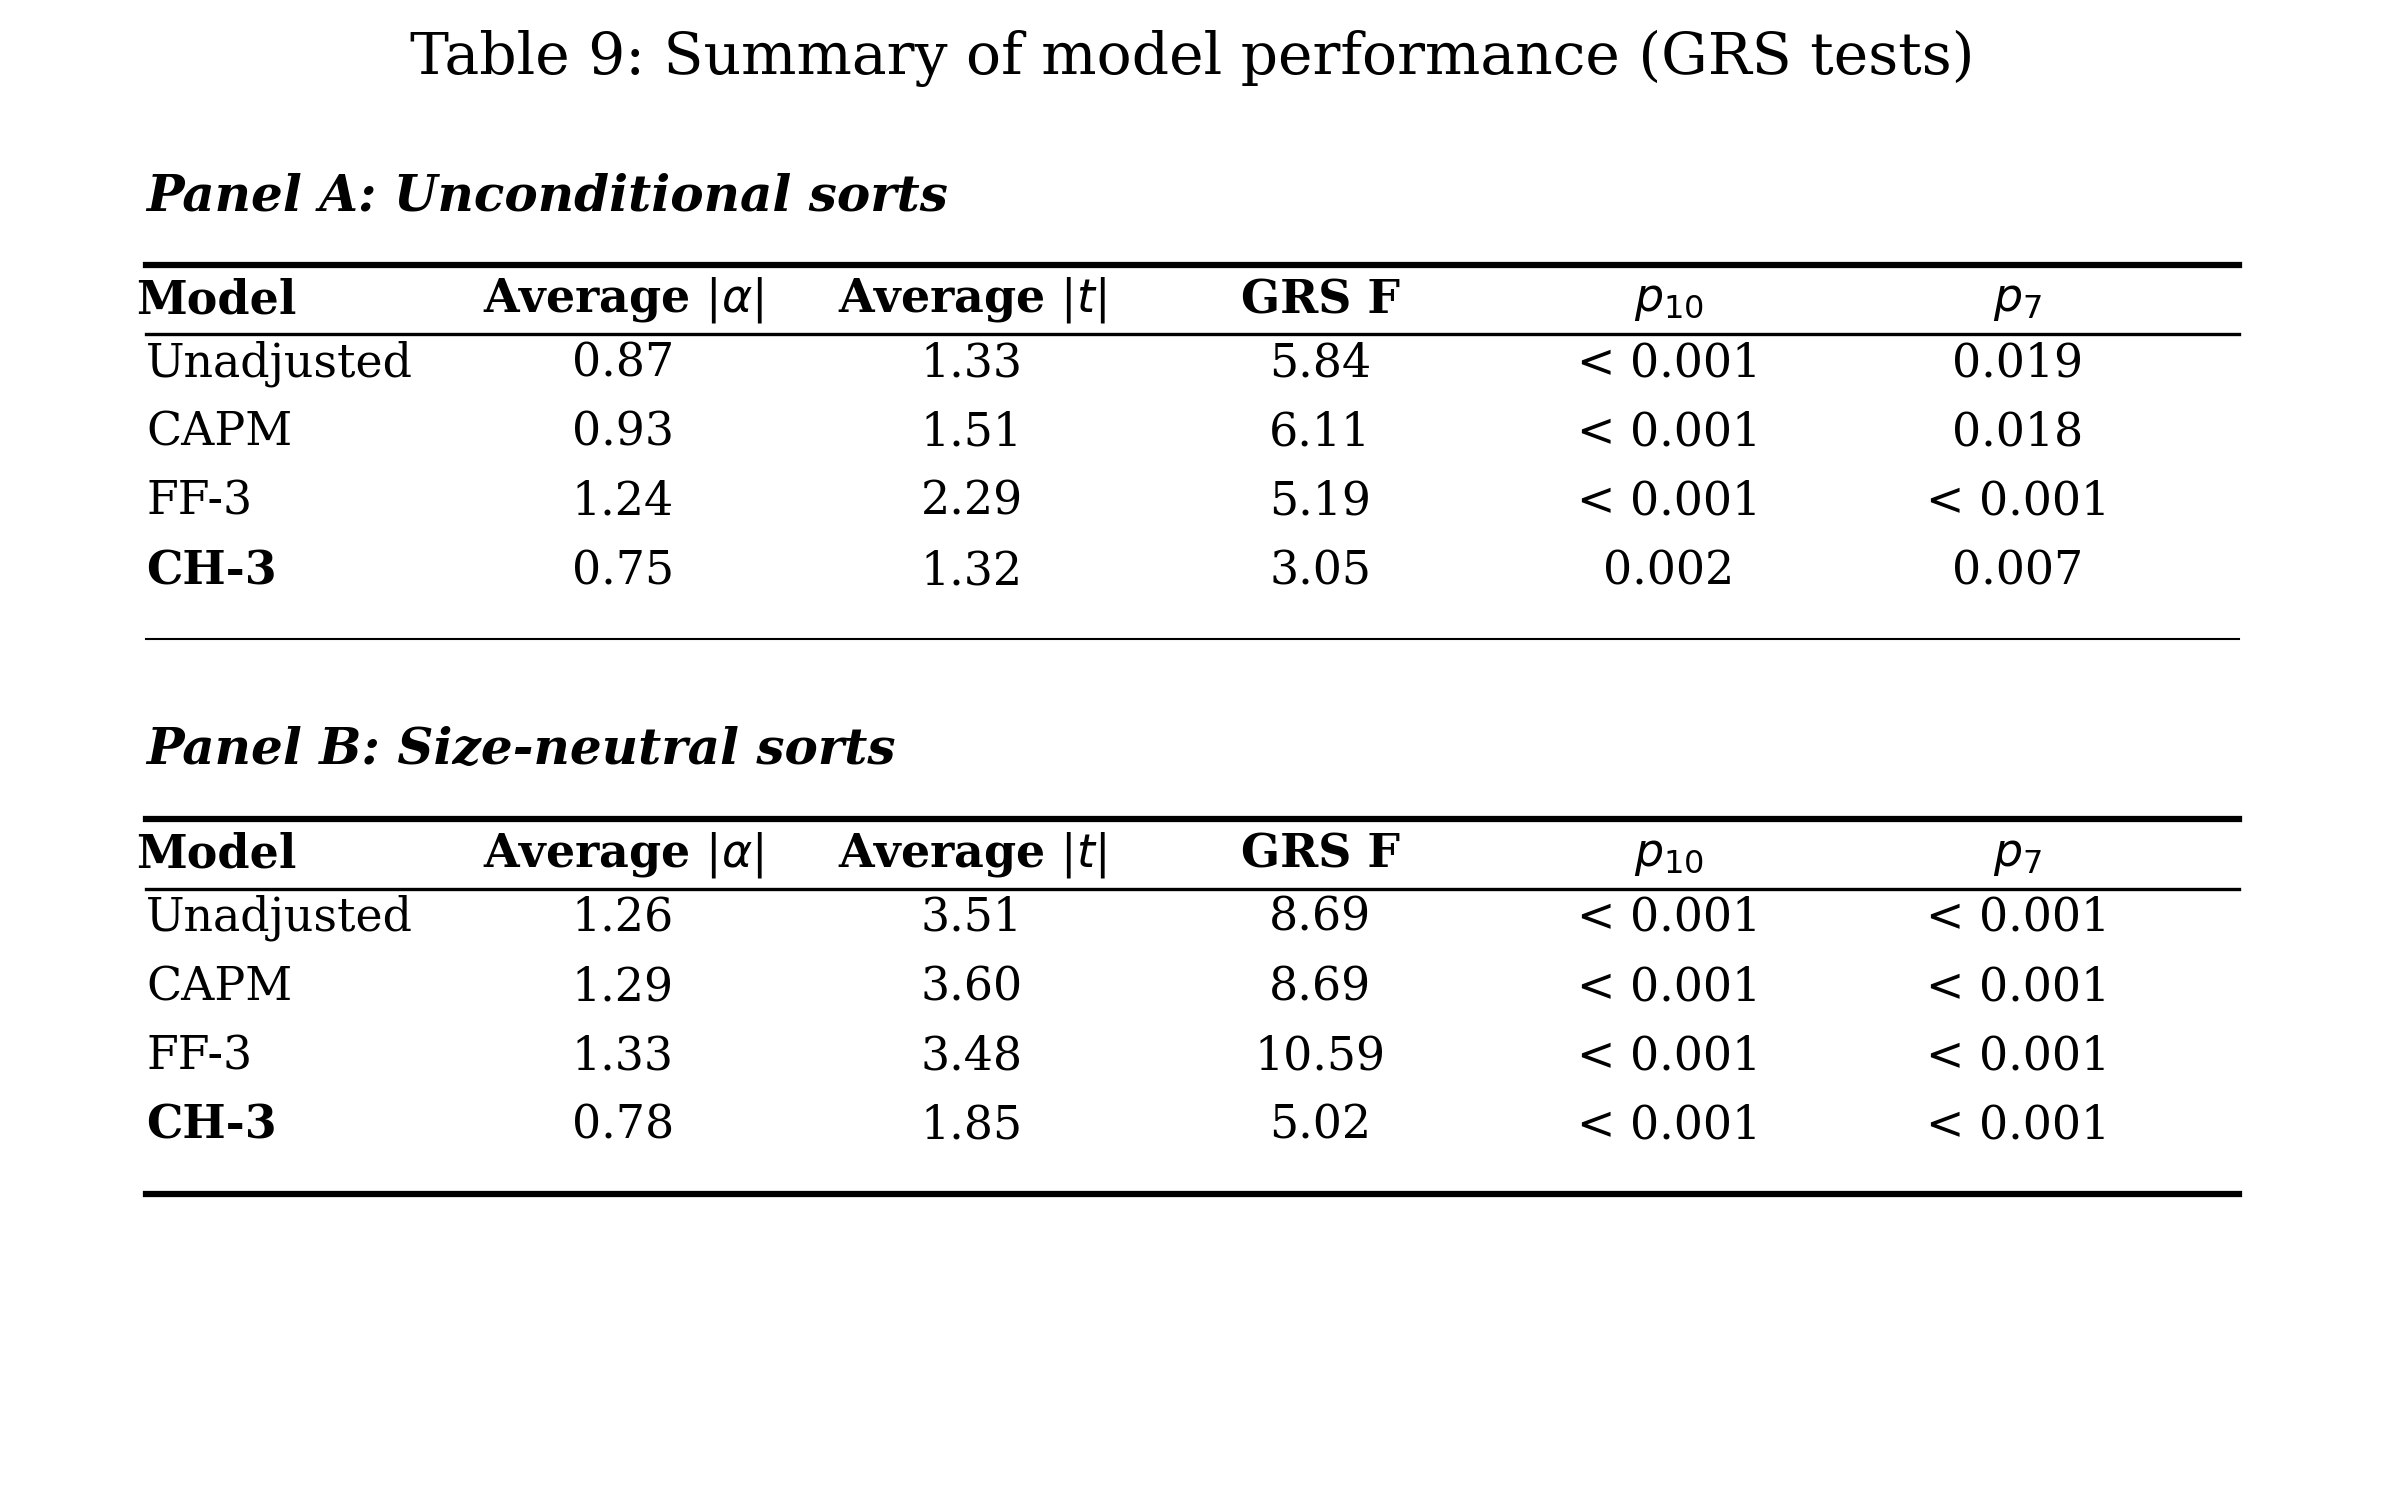

In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import f
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# ==============================================================================
# 0. 数据准备与对齐
# ==============================================================================
print(">>> [Table 9] 准备模型对比数据...")

# 1. 检查异象收益序列
if 'anomaly_ret_dict' not in locals():
    raise ValueError("❌ 错误：内存中未找到 'anomaly_ret_dict'。请先运行 Table 7 的 Step 1 代码！")

# 2. 准备所有因子 (MKT, CH-3, FF-3)
# 我们需要构建一个包含所有因子的宽表
# 尝试从 ch3_factors 和 ff3_factors (build_factors返回的) 合并
try:
    # 假设内存中有之前算好的 ch3_factors 和 ff3 变量
    # 如果没有，尝试从 Table 5 的逻辑重新提取
    # 这里为了稳健，我们假设 factors 变量 (Table 5 生成的) 还在
    if 'factors' in locals() and 'FFSMB' in factors.columns:
        all_factors = factors.copy()
    else:
        # 紧急补救：如果没有 factors 变量，尝试用 ch3_factors 和之前生成的变量拼凑
        # 注意：需要确保索引对齐
        print("⚠️ 未找到集成因子表，正在尝试拼凑...")
        # 假设 ch3_factors 在 (Table 3生成)，需要 FF3
        # 这里如果确实缺失，会报错。请确保 Table 5 运行过。
        raise ValueError("请先运行 Table 5 代码以生成包含 FF-3 的 factors 变量")

    # 确保单位是百分比 (跟异象收益一致)
    # 检查量级：如果均值小于 0.5，说明是小数，乘以 100
    if all_factors['MKT'].abs().mean() < 0.5:
        all_factors *= 100

except Exception as e:
    print(f"❌ 数据准备失败: {e}")
    # 停止运行
    raise e

# 定义要对比的模型
models_config = {
    'Unadjusted': [],          # 原始收益 (Alpha = Mean Ret)
    'CAPM': ['MKT'],
    'FF-3': ['MKT', 'FFSMB', 'FFHML'],
    'CH-3': ['MKT', 'SMB', 'VMG']
}

# ==============================================================================
# 1. 核心计算函数 (GRS & Summary Stats)
# ==============================================================================
def run_model_tests(y_dict, factor_df, model_factors):
    """
    y_dict: {异象名: 收益序列}
    factor_df: 因子宽表
    model_factors: 当前模型使用的因子列名列表
    """
    # 对齐数据
    y_df = pd.DataFrame(y_dict) * 100 # 转百分比
    # 合并 Y 和 X
    if len(model_factors) > 0:
        data = pd.merge(y_df, factor_df[model_factors], left_index=True, right_index=True).dropna()
        X = sm.add_constant(data[model_factors])
    else:
        # Unadjusted: 只有常数项
        data = y_df.dropna()
        X = np.ones((len(data), 1))
        # 这种情况下 data 只有 y，没有因子列，需要注意索引对齐
        # 简单起见，假设 y_df 已经是时间序列

    if len(data) < 50: return np.nan

    T = len(data)
    N = y_df.shape[1]
    K = len(model_factors) # 因子数

    alphas = []
    t_stats = []
    resids = []

    for col in y_df.columns:
        Y = data[col]
        # 普通 OLS (用于 GRS 残差)
        model = sm.OLS(Y, X).fit()
        # Newey-West (用于单变量 t)
        nw_model = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 5})

        # 对于 Unadjusted (Mean)，params[0] 即均值
        # 对于 Factor Model，params['const'] 即 Alpha
        if len(model_factors) > 0:
            alpha = model.params['const']
            t = nw_model.tvalues['const']
        else:
            alpha = model.params[0]
            t = nw_model.tvalues[0]

        alphas.append(alpha)
        t_stats.append(t)
        resids.append(model.resid)

    alphas = np.array(alphas)
    resids = pd.DataFrame(resids).T

    # --- GRS Statistic ---
    # 公式: ((T-N-K)/N) * (alpha' * Sigma^-1 * alpha) / (1 + mu' * Omega^-1 * mu)
    try:
        Sigma = resids.cov()
        Sigma_inv = np.linalg.inv(Sigma)

        if K > 0:
            mu_f = data[model_factors].mean()
            Omega_f = data[model_factors].cov()
            Omega_inv = np.linalg.inv(Omega_f)
            denom = 1 + mu_f.T @ Omega_inv @ mu_f
        else:
            # Unadjusted 模型没有因子，分母为 1
            denom = 1

        numer = (T - N - K) / N
        alpha_part = alphas.T @ Sigma_inv @ alphas

        grs_stat = numer * (alpha_part / denom)
        p_value = 1 - f.cdf(grs_stat, N, T - N - K)

    except:
        grs_stat, p_value = np.nan, np.nan

    # --- Summary Stats ---
    avg_abs_alpha = np.mean(np.abs(alphas))
    avg_abs_t = np.mean(np.abs(t_stats))

    return {
        'Avg |Alpha|': avg_abs_alpha,
        'Avg |t|': avg_abs_t,
        'GRS F': grs_stat,
        'p-val': p_value
    }

# ==============================================================================
# 2. 执行计算
# ==============================================================================
print(">>> [Step 1] 计算 Table 9 统计量...")

table9_rows = []

# 定义测试集合
# GRS10: 所有 10 个异象
anoms_10 = ['Size', 'EP', 'BM', 'CP', 'ROE', 'Vol_1M', 'MAX', 'Rev_1M', 'Turn_12M', 'Abn_Turn']
# GRS7: 剔除 Size, EP, BM (因为它们是因子构建变量)
anoms_7 = [x for x in anoms_10 if x not in ['Size', 'EP', 'BM']]

# 循环 Panel
for sort_type in ['Uncond', 'Neutral']:
    panel_label = 'Panel A: Unconditional sorts' if sort_type == 'Uncond' else 'Panel B: Size-neutral sorts'

    # 准备当前 Panel 的异象数据
    # 注意：Neutral Panel 没有 Size 异象
    current_anoms = anoms_10.copy()
    if sort_type == 'Neutral' and 'Size' in current_anoms:
        current_anoms.remove('Size')

    # 获取数据
    y_dict_all = {k: anomaly_ret_dict[sort_type][k] for k in current_anoms if k in anomaly_ret_dict[sort_type]}
    y_dict_7 = {k: v for k, v in y_dict_all.items() if k in anoms_7}

    # 循环模型
    for m_name, m_factors in models_config.items():
        # 1. 主测试 (Full Set) -> 计算 Avg Alpha, Avg t, GRS
        res_main = run_model_tests(y_dict_all, all_factors, m_factors)

        # 2. 辅助测试 (GRS 7) -> 仅计算 p-value
        res_7 = run_model_tests(y_dict_7, all_factors, m_factors)

        row = {
            'Panel': panel_label,
            'Model': m_name,
            'Avg |Alpha|': res_main['Avg |Alpha|'],
            'Avg |t|': res_main['Avg |t|'],
            'GRS F': res_main['GRS F'],
            'p(10)': res_main['p-val'],
            'p(7)': res_7['p-val']
        }
        table9_rows.append(row)

# ==============================================================================
# 3. 终极绘图 (Paper Style)
# ==============================================================================
final_df = pd.DataFrame(table9_rows)

print("\n=== Table 9 Replication Result ===")
print(final_df.round(3))

def draw_table9_paper(df):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    ax.axis('off')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    font = 'serif'

    # 布局
    y_top = 0.90
    row_h = 0.05
    panel_gap = 0.08

    # 列配置
    # Model | Avg |a| | Avg |t| | GRS F | p(10) | p(7)
    cols_x = [0.05, 0.25, 0.40, 0.55, 0.70, 0.85]
    col_w  = [0.20, 0.15, 0.15, 0.15, 0.15, 0.15]

    # 绘制表头
    def draw_header(y):
        ax.plot([0.05, 0.95], [y, y], 'k-', lw=1.5)
        headers = ['Model', r'Average $|\alpha|$', r'Average $|t|$', 'GRS F', r'$p_{10}$', r'$p_{7}$']
        for i, h in enumerate(headers):
            ax.text(cols_x[i] + col_w[i]/2 - 0.07, y - 0.025, h,
                    ha='center', va='center', weight='bold', fontsize=11, family=font)
        ax.plot([0.05, 0.95], [y - 0.05, y - 0.05], 'k-', lw=0.8)
        return y - 0.08

    curr_y = y_top
    panels = df['Panel'].unique()

    for panel in panels:
        # Title
        ax.text(0.05, curr_y, panel, ha='left', weight='bold', style='italic', fontsize=12, family=font)
        curr_y -= 0.04
        curr_y = draw_header(curr_y)

        # Data
        sub = df[df['Panel'] == panel].copy()

        for _, row in sub.iterrows():
            # Model Name
            model_name = row['Model']
            weight = 'bold' if model_name == 'CH-3' else 'normal' # 高亮 CH-3
            ax.text(cols_x[0], curr_y, model_name, ha='left', fontsize=11, family=font, weight=weight)

            # Values
            vals = [
                row['Avg |Alpha|'],
                row['Avg |t|'],
                row['GRS F'],
                row['p(10)'],
                row['p(7)']
            ]

            for i, val in enumerate(vals):
                # 格式化: GRS F 保留 2 位，p 值保留 3 位
                if i >= 3: # p-values
                    fmt = "{:.3f}"
                    if val < 0.001: txt = "< 0.001"
                    else: txt = fmt.format(val)
                else:
                    txt = "{:.2f}".format(val)

                ax.text(cols_x[i+1] + col_w[i+1]/2 - 0.07, curr_y, txt,
                        ha='center', fontsize=11, family=font)

            curr_y -= row_h

        ax.plot([0.05, 0.95], [curr_y + 0.01, curr_y + 0.01], 'k-', lw=1.5 if panel == panels[-1] else 0.5)
        curr_y -= panel_gap

    plt.title("Table 9: Summary of model performance (GRS tests)", y=0.98, fontsize=14, family=font)
    plt.show()

draw_table9_paper(final_df)

table 10

>>> [Table 10] 开始执行完整流程...
>>> [Step 1] 合成 CH-4 因子...
  因子构建完成，样本数: 117
>>> [Step 2] 运行回归 (提取 10 个统计量)...

Table 10: CH-4 Alphas and Factor Loadings (Full Replication)
                           Panel       Category   Anomaly  Alpha  t_Alpha  b_MKT  t_MKT  b_SMB  t_SMB  b_VMG  t_VMG  b_PMO  t_PMO
0   Panel A: Unconditional sorts           Size      Size   0.58     2.09   0.02   0.55   1.20  25.46  -0.47  -4.20   0.06   0.60
1   Panel A: Unconditional sorts          Value        EP   0.61     1.43  -0.04  -0.78  -0.68  -5.43   0.66   4.78   0.06   0.53
2   Panel A: Unconditional sorts          Value        BM   0.06     0.09   0.04   0.36  -0.27  -1.36   1.12   4.51  -0.10  -0.39
3   Panel A: Unconditional sorts          Value        CP  -0.89    -1.64  -0.09  -0.98  -0.27  -2.51   0.42   2.13   0.34   3.02
4   Panel A: Unconditional sorts  Profitability       ROE   0.60     1.07   0.01   0.08  -0.48  -3.38   0.60   3.91  -0.04  -0.30
5   Panel A: Unconditional sorts     Volatility    V

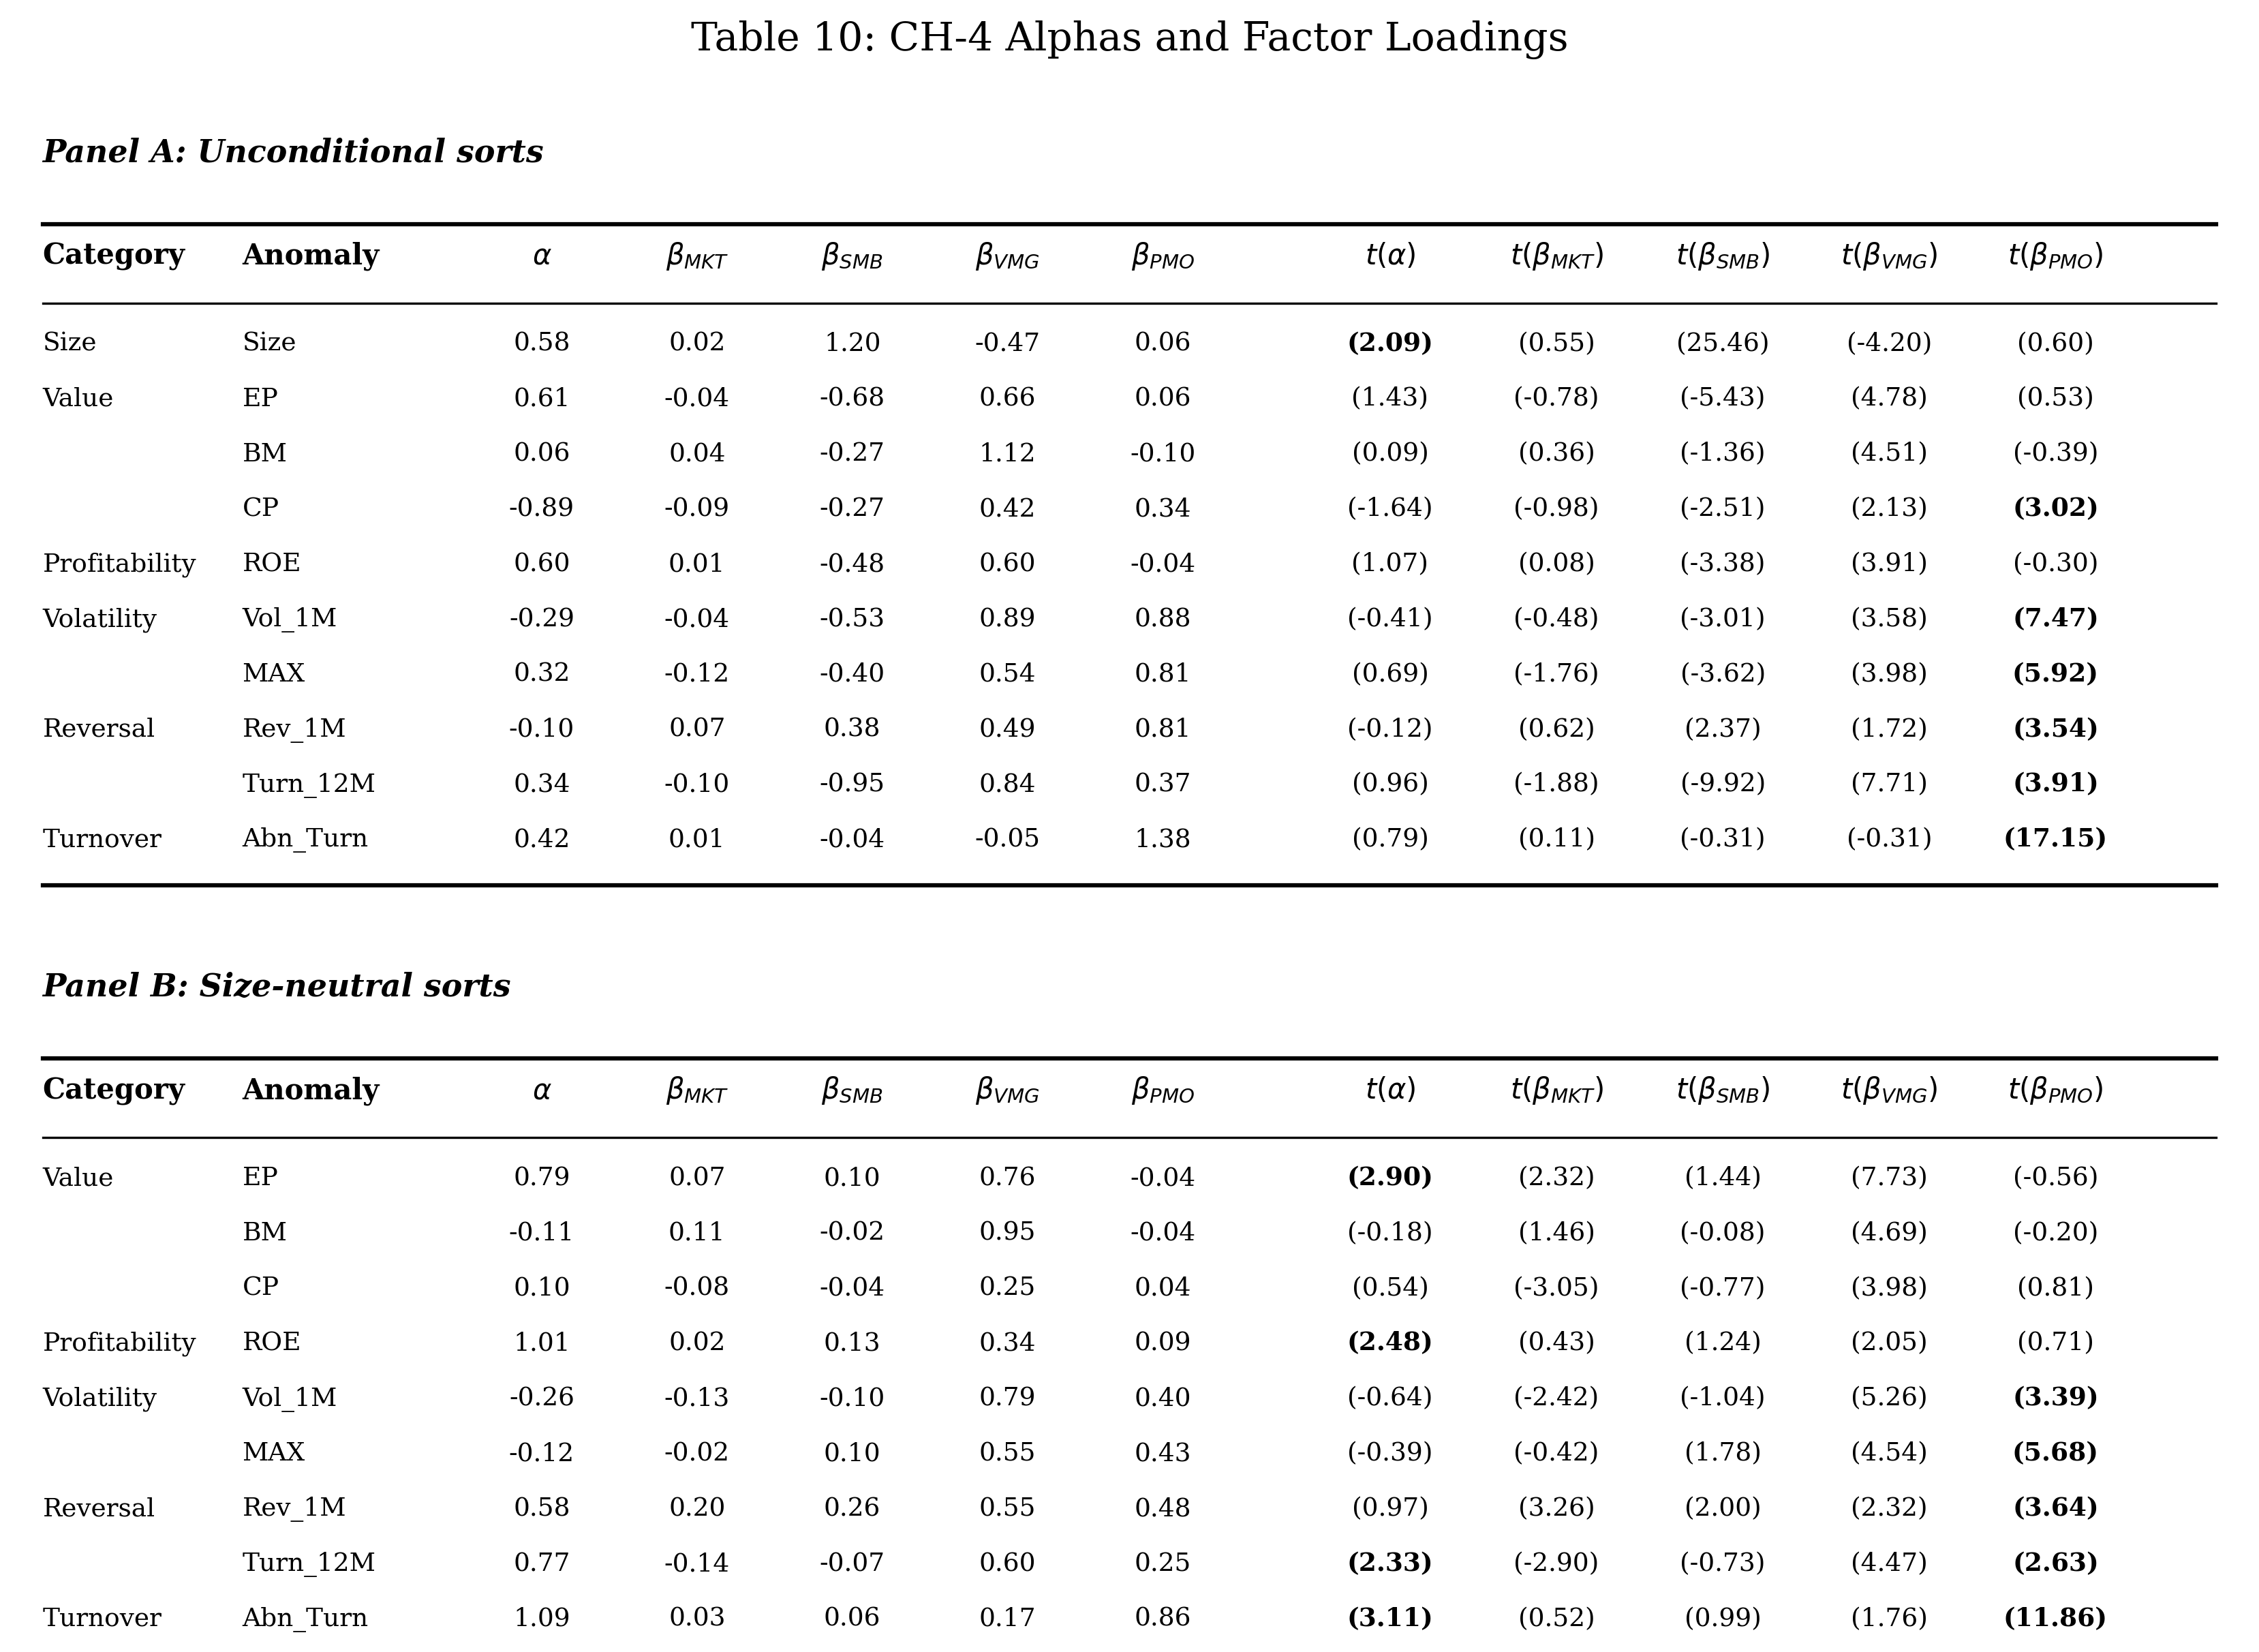

In [18]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os
import warnings

# 忽略警告
warnings.simplefilter(action='ignore', category=FutureWarning)

# ==============================================================================
# 0. 准备工作：检查必要数据
# ==============================================================================
print(">>> [Table 10] 开始执行完整流程...")

# 1. 检查异象收益序列 (来自 Table 6/7)
if 'anomaly_ret_dict' not in locals():
    raise ValueError("❌ 错误：内存中未找到 'anomaly_ret_dict'。请先运行 Table 7 的 Step 1 代码！")

# 2. 检查 PMO 因子数据 (来自 Table 10 Step 1)
# 如果内存里没有 pmo_df，需要先运行构建代码。
# 为了代码完整性，这里假设你已经运行过构建 PMO 的部分。
# 如果没有，请翻阅之前的回答运行 "构建 PMO 因子" 的部分。
if 'pmo_df' not in locals():
    raise ValueError("❌ 错误：内存中未找到 'pmo_df'。请先运行 Table 10 的 Step 1 (构建 PMO) 代码！")

# 3. 准备基础因子 (CH-3)
if 'factors' in locals(): # Table 5 产物
    ch3_base = factors[['MKT', 'SMB', 'VMG']].copy()
elif 'ch3_factors' in locals(): # Table 3 产物
    ch3_base = ch3_factors[['MKT', 'SMB', 'VMG']].copy()
else:
    raise ValueError("❌ 错误：未找到 CH-3 基础因子 (MKT, SMB, VMG)。")

# 统一单位 (转为小数进行计算)
if ch3_base['MKT'].abs().mean() > 0.5: ch3_base /= 100

# ==============================================================================
# 1. 合成 CH-4 因子 (MKT, SMB_New, VMG, PMO)
# ==============================================================================
print(">>> [Step 1] 合成 CH-4 因子...")

# 对齐索引
common_idx = ch3_base.index.intersection(pmo_df.index)
ch4 = pd.merge(ch3_base.loc[common_idx], pmo_df.loc[common_idx], left_index=True, right_index=True)

# 计算新 SMB (论文 7.1: simple average of EP-neutralized SMB and Turnover-neutralized SMB)
# ch3_base['SMB'] 是基于 EP 分组的; pmo_df['SMB_PMO'] 是基于 Turnover 分组的
ch4['SMB_New'] = (ch4['SMB'] + ch4['SMB_PMO']) / 2

# 最终 CH-4 因子组
factors_final = ch4[['MKT', 'SMB_New', 'VMG', 'PMO']].rename(columns={'SMB_New': 'SMB'})
factors_final *= 100 # 转为百分比，与异象收益一致

print(f"  因子构建完成，样本数: {len(factors_final)}")

# ==============================================================================
# 2. 运行完整回归 (Full Variables)
# ==============================================================================
print(">>> [Step 2] 运行回归 (提取 10 个统计量)...")

results_list = []
# 论文顺序
order_keys = ['Size', 'EP', 'BM', 'CP', 'ROE', 'Vol_1M', 'MAX', 'Rev_1M', 'Turn_12M', 'Abn_Turn']

for sort_type in ['Uncond', 'Neutral']:
    panel_name = 'Panel A: Unconditional sorts' if sort_type == 'Uncond' else 'Panel B: Size-neutral sorts'
    anom_dict = anomaly_ret_dict[sort_type]

    current_keys = order_keys.copy()
    if sort_type == 'Neutral': current_keys.remove('Size')

    for anom in current_keys:
        if anom not in anom_dict: continue

        # 准备数据
        y = anom_dict[anom] * 100 # 转百分比
        X = factors_final[['MKT', 'SMB', 'VMG', 'PMO']]

        reg_df = pd.merge(y.rename('Ret'), X, left_index=True, right_index=True).dropna()
        if len(reg_df) < 50: continue

        # Newey-West 回归
        model = sm.OLS(reg_df['Ret'], sm.add_constant(reg_df[X.columns])).fit(cov_type='HAC', cov_kwds={'maxlags': 5})

        # 提取所有系数和 t 值
        row = {
            'Panel': panel_name,
            'Anomaly': anom,
            'Alpha': model.params['const'], 't_Alpha': model.tvalues['const'],
            'b_MKT': model.params['MKT'],   't_MKT': model.tvalues['MKT'],
            'b_SMB': model.params['SMB'],   't_SMB': model.tvalues['SMB'],
            'b_VMG': model.params['VMG'],   't_VMG': model.tvalues['VMG'],
            'b_PMO': model.params['PMO'],   't_PMO': model.tvalues['PMO']
        }
        results_list.append(row)

res_df = pd.DataFrame(results_list)

# 映射分类
cat_map = {
    'Size': 'Size', 'EP': 'Value', 'BM': 'Value', 'CP': 'Value', 'ROE': 'Profitability',
    'Vol_1M': 'Volatility', 'MAX': 'Volatility', 'Rev_1M': 'Reversal',
    'Turn_12M': 'Reversal', 'Abn_Turn': 'Turnover'
}
res_df.insert(1, 'Category', res_df['Anomaly'].map(cat_map))

# ==============================================================================
# 3. 完整数据展示与保存 (关键步骤！)
# ==============================================================================
print("\n" + "="*80)
print("Table 10: CH-4 Alphas and Factor Loadings (Full Replication)")
print("="*80)

# 设置 Pandas 显示选项：强制显示所有行、列，不省略
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# 打印完整 DataFrame
print(res_df)

# 保存到本地 CSV
out_dir = r"C:\Users\Pedro\PycharmProjects\pythonProject1\金融计量学\Replication_of_Liu_2019-main\data\Output"
if not os.path.exists(out_dir): os.makedirs(out_dir)
save_path = os.path.join(out_dir, "Table10_Full_Replication.csv")
res_df.to_csv(save_path, index=False, encoding='utf-8-sig')
print(f"\n✅ 完整数据已保存至: {save_path}")

# ==============================================================================
# 4. 绘图 (仿照论文样式)
# ==============================================================================
def draw_table10_full(df):
    fig, ax = plt.subplots(figsize=(14, 10), dpi=300)
    ax.axis('off')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    font = 'serif'
    y_top = 0.92
    row_h = 0.035
    panel_gap = 0.06

    # 列位置配置
    x_cat = 0.01
    x_anom = 0.10

    # 5个系数的起始和宽度
    x_coef_start = 0.20
    w_coef = 0.07
    x_coefs = [x_coef_start + i*w_coef for i in range(5)]

    # 5个t值的起始和宽度
    x_t_start = 0.58
    w_t = 0.075
    x_ts = [x_t_start + i*w_t for i in range(5)]

    all_x = [x_cat, x_anom] + x_coefs + x_ts

    # 绘制表头
    def draw_header(y):
        ax.plot([0.01, 0.99], [y, y], 'k-', lw=1.5)
        headers = [
            'Category', 'Anomaly',
            r'$\alpha$', r'$\beta_{MKT}$', r'$\beta_{SMB}$', r'$\beta_{VMG}$', r'$\beta_{PMO}$',
            r'$t(\alpha)$', r'$t(\beta_{MKT})$', r'$t(\beta_{SMB})$', r'$t(\beta_{VMG})$', r'$t(\beta_{PMO})$'
        ]
        for i, h in enumerate(headers):
            if i < 2:
                ax.text(all_x[i], y - 0.025, h, ha='left', weight='bold', fontsize=10, family=font)
            else:
                w = w_coef if i < 7 else w_t
                ax.text(all_x[i] + w/2, y - 0.025, h, ha='center', weight='bold', fontsize=10, family=font)
        ax.plot([0.01, 0.99], [y - 0.05, y - 0.05], 'k-', lw=0.8)
        return y - 0.08

    curr_y = y_top
    for panel in df['Panel'].unique():
        ax.text(0.01, curr_y, panel, ha='left', weight='bold', style='italic', fontsize=11, family=font)
        curr_y -= 0.04
        curr_y = draw_header(curr_y)

        sub = df[df['Panel'] == panel].copy()
        prev_cat = ""

        for _, row in sub.iterrows():
            cat = row['Category']
            if cat != prev_cat:
                ax.text(x_cat, curr_y, cat, ha='left', fontsize=9, family=font)
                prev_cat = cat

            ax.text(x_anom, curr_y, row['Anomaly'], ha='left', fontsize=9, family=font)

            vals = [
                row['Alpha'], row['b_MKT'], row['b_SMB'], row['b_VMG'], row['b_PMO'],
                row['t_Alpha'], row['t_MKT'], row['t_SMB'], row['t_VMG'], row['t_PMO']
            ]

            for i, v in enumerate(vals):
                is_t = (i >= 5)
                fmt = "({:.2f})" if is_t else "{:.2f}"

                # 高亮逻辑: Alpha t值(i=5) 和 PMO t值(i=9)
                w = 'bold' if (i==5 or i==9) and abs(v) > 1.96 else 'normal'

                # 计算x坐标
                idx_in_group = i if i < 5 else i - 5
                base_x = x_coefs[idx_in_group] if i < 5 else x_ts[idx_in_group]
                width = w_coef if i < 5 else w_t

                ax.text(base_x + width/2, curr_y, fmt.format(v),
                        ha='center', fontsize=9, family=font, weight=w)

            curr_y -= row_h
        ax.plot([0.01, 0.99], [curr_y + 0.01, curr_y + 0.01], 'k-', lw=1.5)
        curr_y -= panel_gap

    plt.title("Table 10: CH-4 Alphas and Factor Loadings", y=0.98, fontsize=14, family=font)
    plt.show()

draw_table10_full(res_df)